In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score
from itertools import product
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [3]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [4]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Width', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 'Scin_f'
]
base_features = [
    'Observing_band', 'GL', 'GB', 'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [5]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()

        self.activation = activation

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),  # Additional dense layer
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )

        # Classification head for binary classification - tune hyperparameters
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),  # Added extra linear layer
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 4, 1),
        )


    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(mu)
        return recon_x, mu, logvar, class_prob


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [8]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [9]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [10]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [76]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return f1, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [12]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [57]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 128, 2048)
    latent_dim = trial.suggest_int('latent_dim', 5, 40)
    beta = trial.suggest_float('beta', 0.1, 2.0)
    gamma = trial.suggest_float('gamma', 0.1, 2.0)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    scheduler_patience = trial.suggest_int('scheduler_patience', 2, 7)
    class_weight = trial.suggest_float('class_weight', 0.05, 1)
    
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'SELU', 'GELU'])
    activation = get_activation_function(activation_name)
    classification_multiplier = trial.suggest_float('classification_multiplier', 5000, 15000)
    
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)

    model = SupervisedVAE(input_dim, hidden_dim, latent_dim, dropout_rate, activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
    
    all_false_positives = []
    all_false_negatives = []
    all_true_positives = []
    all_true_negatives = []

    num_epochs = 50
    
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(model, optimizer, scheduler, epoch, beta, gamma, pos_weight, classification_multiplier)
        val_loss, _, _, _, val_accuracy = validate_supervised(model, optimizer, scheduler, epoch, beta, gamma, pos_weight, classification_multiplier)
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], stop_patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break
    
    val_f1, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(model, val_loader, device)
    
    tp=val_conf_matrix[1,1]
    tn=val_conf_matrix[0,0]
    fp=val_conf_matrix[0,1]
    fn=val_conf_matrix[1,0]
    print("True Positives: ", tp)
    print("True Negatives: ", tn)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    
    p_ratio=tp/(tp+fn)
    n_ratio = tn/(tn+fp)
    avg_ratio = (p_ratio+ n_ratio)/2
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:\n", val_class_report)
    print("Confusion Matrix:\n", val_conf_matrix)
    
    
    return val_accuracy
    

    
        
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-02-10 21:52:21,644] A new study created in memory with name: no-name-50d92d31-3150-44db-9f8c-47cd25c8c948
[I 2025-02-10 21:53:18,502] Trial 0 finished with value: 0.9417195614541258 and parameters: {'hidden_dim': 2029, 'latent_dim': 17, 'beta': 1.5977918084524714, 'gamma': 1.1167939316820794, 'dropout_rate': 0.47175504704751736, 'lr': 0.00493221238516128, 'scheduler_patience': 7, 'class_weight': 0.39576772863926735, 'activation': 'SELU', 'classification_multiplier': 5745.2961156395595}. Best is trial 0 with value: 0.9417195614541258.


True Positives:  1532
True Negatives:  100
False Positives:  50
False Negatives:  51
Validation Accuracy: 0.9417
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.66      0.67      0.66       150
    Repeater       0.97      0.97      0.97      1583

    accuracy                           0.94      1733
   macro avg       0.82      0.82      0.82      1733
weighted avg       0.94      0.94      0.94      1733

Confusion Matrix:
 [[ 100   50]
 [  51 1532]]


[I 2025-02-10 21:54:08,643] Trial 1 finished with value: 0.8026543566070398 and parameters: {'hidden_dim': 1863, 'latent_dim': 10, 'beta': 0.8921415221833985, 'gamma': 0.1664138267024361, 'dropout_rate': 0.40493620500186245, 'lr': 0.003912390466596942, 'scheduler_patience': 6, 'class_weight': 0.092915877625931, 'activation': 'ReLU', 'classification_multiplier': 13735.015424940339}. Best is trial 0 with value: 0.9417195614541258.


True Positives:  1244
True Negatives:  147
False Positives:  3
False Negatives:  339
Validation Accuracy: 0.8027
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.30      0.98      0.46       150
    Repeater       1.00      0.79      0.88      1583

    accuracy                           0.80      1733
   macro avg       0.65      0.88      0.67      1733
weighted avg       0.94      0.80      0.84      1733

Confusion Matrix:
 [[ 147    3]
 [ 339 1244]]


[I 2025-02-10 21:54:36,584] Trial 2 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 817, 'latent_dim': 6, 'beta': 0.9717122858318765, 'gamma': 0.74953408549325, 'dropout_rate': 0.285402770105302, 'lr': 0.004701035989505038, 'scheduler_patience': 2, 'class_weight': 0.24839914274185254, 'activation': 'ReLU', 'classification_multiplier': 14328.998856425691}. Best is trial 2 with value: 0.9924985574148875.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 21:55:18,283] Trial 3 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1386, 'latent_dim': 32, 'beta': 0.722344839071404, 'gamma': 1.1476263960015871, 'dropout_rate': 0.40182076049342774, 'lr': 0.0019846855598513735, 'scheduler_patience': 5, 'class_weight': 0.951414313310366, 'activation': 'ReLU', 'classification_multiplier': 11231.830954134424}. Best is trial 3 with value: 0.9936526255049047.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 21:56:02,079] Trial 4 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1766, 'latent_dim': 9, 'beta': 0.31933392539799477, 'gamma': 0.930874449926321, 'dropout_rate': 0.12090584178524516, 'lr': 0.0005282787520538332, 'scheduler_patience': 6, 'class_weight': 0.3686896876012565, 'activation': 'ReLU', 'classification_multiplier': 11399.949064079156}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 21:56:29,867] Trial 5 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 335, 'latent_dim': 11, 'beta': 0.7318697752559394, 'gamma': 0.9541622655949316, 'dropout_rate': 0.3489207311431184, 'lr': 0.0029339289762324128, 'scheduler_patience': 2, 'class_weight': 0.6849142915057158, 'activation': 'ReLU', 'classification_multiplier': 5510.927356763903}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1574
True Negatives:  143
False Positives:  7
False Negatives:  9
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.95      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   9 1574]]


[I 2025-02-10 21:57:02,682] Trial 6 finished with value: 0.953260242354299 and parameters: {'hidden_dim': 1224, 'latent_dim': 6, 'beta': 0.7009517461022334, 'gamma': 1.6525974008671571, 'dropout_rate': 0.12397478549539374, 'lr': 0.007594167762763847, 'scheduler_patience': 3, 'class_weight': 0.4027304527535512, 'activation': 'SELU', 'classification_multiplier': 9677.140148163646}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1541
True Negatives:  111
False Positives:  39
False Negatives:  42
Validation Accuracy: 0.9533
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.73      0.74      0.73       150
    Repeater       0.98      0.97      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.85      0.86      0.85      1733
weighted avg       0.95      0.95      0.95      1733

Confusion Matrix:
 [[ 111   39]
 [  42 1541]]


[I 2025-02-10 21:57:30,463] Trial 7 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 701, 'latent_dim': 20, 'beta': 1.3369195443758009, 'gamma': 0.9372373078323737, 'dropout_rate': 0.2676662556327388, 'lr': 0.004770899626850745, 'scheduler_patience': 6, 'class_weight': 0.35924030563531306, 'activation': 'GELU', 'classification_multiplier': 9704.70589059791}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-10 21:58:07,414] Trial 8 finished with value: 0.9174841315637623 and parameters: {'hidden_dim': 1329, 'latent_dim': 27, 'beta': 0.3561522002616695, 'gamma': 1.986048608818804, 'dropout_rate': 0.4302420357668565, 'lr': 0.008938234042669224, 'scheduler_patience': 4, 'class_weight': 0.5810135578798047, 'activation': 'ELU', 'classification_multiplier': 8277.622613799345}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1532
True Negatives:  58
False Positives:  92
False Negatives:  51
Validation Accuracy: 0.9175
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.53      0.39      0.45       150
    Repeater       0.94      0.97      0.96      1583

    accuracy                           0.92      1733
   macro avg       0.74      0.68      0.70      1733
weighted avg       0.91      0.92      0.91      1733

Confusion Matrix:
 [[  58   92]
 [  51 1532]]


[I 2025-02-10 21:58:45,572] Trial 9 finished with value: 0.9105597230236584 and parameters: {'hidden_dim': 1435, 'latent_dim': 5, 'beta': 1.9650594850273593, 'gamma': 0.7510732577444739, 'dropout_rate': 0.36893035900651294, 'lr': 0.004471043201597435, 'scheduler_patience': 4, 'class_weight': 0.24235525129042784, 'activation': 'SELU', 'classification_multiplier': 8532.431875244903}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1462
True Negatives:  116
False Positives:  34
False Negatives:  121
Validation Accuracy: 0.9106
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.49      0.77      0.60       150
    Repeater       0.98      0.92      0.95      1583

    accuracy                           0.91      1733
   macro avg       0.73      0.85      0.77      1733
weighted avg       0.94      0.91      0.92      1733

Confusion Matrix:
 [[ 116   34]
 [ 121 1462]]


[I 2025-02-10 21:59:30,474] Trial 10 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1733, 'latent_dim': 38, 'beta': 0.10252778810825508, 'gamma': 0.28619314939248697, 'dropout_rate': 0.11082769977214908, 'lr': 0.00013448035887861191, 'scheduler_patience': 7, 'class_weight': 0.7825018376908586, 'activation': 'LeakyReLU', 'classification_multiplier': 12165.728446813479}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 22:00:15,638] Trial 11 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1588, 'latent_dim': 31, 'beta': 0.47807990040719406, 'gamma': 1.2000219276089517, 'dropout_rate': 0.19903075820390825, 'lr': 0.0003854355039910474, 'scheduler_patience': 5, 'class_weight': 0.9292390762964127, 'activation': 'ReLU', 'classification_multiplier': 12155.356387873571}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:00:57,047] Trial 12 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1605, 'latent_dim': 27, 'beta': 0.3263272081915171, 'gamma': 1.4091594481407848, 'dropout_rate': 0.18510586992851785, 'lr': 0.0001333526911079526, 'scheduler_patience': 5, 'class_weight': 0.9950007027141309, 'activation': 'ReLU', 'classification_multiplier': 12189.138293377922}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:01:28,233] Trial 13 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 941, 'latent_dim': 23, 'beta': 0.11191201016313146, 'gamma': 1.495772972441066, 'dropout_rate': 0.19231486749460747, 'lr': 0.001457063972976022, 'scheduler_patience': 6, 'class_weight': 0.5572124018333866, 'activation': 'ELU', 'classification_multiplier': 13050.252707647605}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-10 22:02:11,704] Trial 14 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1696, 'latent_dim': 16, 'beta': 0.2961189481955165, 'gamma': 1.4620692149542067, 'dropout_rate': 0.17794772132096381, 'lr': 0.0014077542047798853, 'scheduler_patience': 5, 'class_weight': 0.7710498771141626, 'activation': 'LeakyReLU', 'classification_multiplier': 10825.520532737186}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 22:03:08,088] Trial 15 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 2046, 'latent_dim': 25, 'beta': 1.1882758338189903, 'gamma': 0.39716111997912684, 'dropout_rate': 0.2381818595436851, 'lr': 0.002539596377165214, 'scheduler_patience': 6, 'class_weight': 0.12788091796859144, 'activation': 'GELU', 'classification_multiplier': 12498.023202156035}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1571
True Negatives:  146
False Positives:  4
False Negatives:  12
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.97      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [  12 1571]]


[I 2025-02-10 22:03:41,894] Trial 16 finished with value: 0.9844200807847663 and parameters: {'hidden_dim': 1089, 'latent_dim': 38, 'beta': 0.500233209872075, 'gamma': 0.5734687994201915, 'dropout_rate': 0.14742349997561843, 'lr': 0.00673778736309078, 'scheduler_patience': 4, 'class_weight': 0.4873600734194683, 'activation': 'ReLU', 'classification_multiplier': 14934.650395826626}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1562
True Negatives:  144
False Positives:  6
False Negatives:  21
Validation Accuracy: 0.9844
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.87      0.96      0.91       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.93      0.97      0.95      1733
weighted avg       0.99      0.98      0.98      1733

Confusion Matrix:
 [[ 144    6]
 [  21 1562]]


[I 2025-02-10 22:04:22,361] Trial 17 finished with value: 0.9492210040392384 and parameters: {'hidden_dim': 1548, 'latent_dim': 30, 'beta': 0.3486055683805258, 'gamma': 1.4076863834386004, 'dropout_rate': 0.1016752246841262, 'lr': 0.006393113779527983, 'scheduler_patience': 7, 'class_weight': 0.6705731846073346, 'activation': 'ReLU', 'classification_multiplier': 10956.061028972908}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1548
True Negatives:  97
False Positives:  53
False Negatives:  35
Validation Accuracy: 0.9492
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.73      0.65      0.69       150
    Repeater       0.97      0.98      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.85      0.81      0.83      1733
weighted avg       0.95      0.95      0.95      1733

Confusion Matrix:
 [[  97   53]
 [  35 1548]]


[I 2025-02-10 22:05:12,266] Trial 18 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1875, 'latent_dim': 14, 'beta': 0.5783152714331599, 'gamma': 1.8304914833136823, 'dropout_rate': 0.23028924218628022, 'lr': 0.003282843855504134, 'scheduler_patience': 3, 'class_weight': 0.8589380043456574, 'activation': 'ReLU', 'classification_multiplier': 8080.604499001579}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1576
True Negatives:  143
False Positives:  7
False Negatives:  7
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   7 1576]]


[I 2025-02-10 22:05:38,038] Trial 19 finished with value: 0.9878822850548182 and parameters: {'hidden_dim': 392, 'latent_dim': 21, 'beta': 1.2040405630894977, 'gamma': 1.2840102226915393, 'dropout_rate': 0.16112940221542138, 'lr': 0.000856381091801642, 'scheduler_patience': 5, 'class_weight': 0.2614365233180181, 'activation': 'ELU', 'classification_multiplier': 13482.984193154667}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1568
True Negatives:  144
False Positives:  6
False Negatives:  15
Validation Accuracy: 0.9879
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.96      0.93       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.95      0.98      0.96      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [  15 1568]]


[I 2025-02-10 22:06:13,335] Trial 20 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1144, 'latent_dim': 34, 'beta': 0.24389857793666736, 'gamma': 1.6242640900970897, 'dropout_rate': 0.22643586125159126, 'lr': 0.002178366760119035, 'scheduler_patience': 6, 'class_weight': 0.46286064260059, 'activation': 'LeakyReLU', 'classification_multiplier': 6681.098219537453}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 22:06:55,108] Trial 21 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1593, 'latent_dim': 28, 'beta': 0.5379495244094888, 'gamma': 1.2968653345318908, 'dropout_rate': 0.1900041021593761, 'lr': 0.0004287158830639824, 'scheduler_patience': 5, 'class_weight': 0.9858497038411134, 'activation': 'ReLU', 'classification_multiplier': 11782.522834972862}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 22:07:43,434] Trial 22 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1789, 'latent_dim': 36, 'beta': 0.4570337011269596, 'gamma': 0.8318724161061417, 'dropout_rate': 0.1440690538472276, 'lr': 0.001026354336752396, 'scheduler_patience': 5, 'class_weight': 0.8931598563147481, 'activation': 'ReLU', 'classification_multiplier': 10396.7040347983}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 22:08:33,031] Trial 23 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1849, 'latent_dim': 35, 'beta': 0.8350536783361366, 'gamma': 0.753137930170952, 'dropout_rate': 0.14928652660676403, 'lr': 0.0012446998768400126, 'scheduler_patience': 4, 'class_weight': 0.8633204349754645, 'activation': 'ReLU', 'classification_multiplier': 10311.73948661604}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 22:09:21,350] Trial 24 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1721, 'latent_dim': 39, 'beta': 0.1965500971698333, 'gamma': 0.9004379657679895, 'dropout_rate': 0.3163254486203485, 'lr': 0.00011476760252830957, 'scheduler_patience': 6, 'class_weight': 0.8740909480798782, 'activation': 'ReLU', 'classification_multiplier': 9059.50552345045}. Best is trial 4 with value: 0.9948066935949221.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:09:58,569] Trial 25 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1509, 'latent_dim': 25, 'beta': 0.3901718124276078, 'gamma': 0.5711431341224729, 'dropout_rate': 0.1347732801779895, 'lr': 0.0017197263166813534, 'scheduler_patience': 5, 'class_weight': 0.9958800284477097, 'activation': 'GELU', 'classification_multiplier': 11633.222495539303}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:10:38,234] Trial 26 finished with value: 0.9821119446047317 and parameters: {'hidden_dim': 1475, 'latent_dim': 24, 'beta': 0.37132987147226115, 'gamma': 0.6053857181673371, 'dropout_rate': 0.13743674074251222, 'lr': 0.0034741095644728985, 'scheduler_patience': 7, 'class_weight': 0.9965212189833206, 'activation': 'GELU', 'classification_multiplier': 11521.446736543547}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1566
True Negatives:  136
False Positives:  14
False Negatives:  17
Validation Accuracy: 0.9821
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.89      0.91      0.90       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.94      0.95      0.94      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 136   14]
 [  17 1566]]


[I 2025-02-10 22:11:13,362] Trial 27 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1321, 'latent_dim': 19, 'beta': 0.6185079811741058, 'gamma': 0.5331758213596105, 'dropout_rate': 0.10316370283042467, 'lr': 0.0018234012210646584, 'scheduler_patience': 3, 'class_weight': 0.771347672015274, 'activation': 'GELU', 'classification_multiplier': 12828.18540661581}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  147
False Positives:  3
False Negatives:  5
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.98      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   5 1578]]


[I 2025-02-10 22:11:49,145] Trial 28 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1239, 'latent_dim': 18, 'beta': 0.5922365135622549, 'gamma': 0.5214405118901916, 'dropout_rate': 0.1026975745576764, 'lr': 0.0020054831097303417, 'scheduler_patience': 3, 'class_weight': 0.6590997772375665, 'activation': 'GELU', 'classification_multiplier': 13010.25615239892}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:12:18,339] Trial 29 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 949, 'latent_dim': 18, 'beta': 1.5815761935014478, 'gamma': 0.44366167147640434, 'dropout_rate': 0.10365982520067583, 'lr': 0.005661229925254579, 'scheduler_patience': 3, 'class_weight': 0.635914175169157, 'activation': 'GELU', 'classification_multiplier': 13420.438267979263}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 22:12:51,631] Trial 30 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1276, 'latent_dim': 14, 'beta': 0.6153410326947091, 'gamma': 0.11555437277877317, 'dropout_rate': 0.21656680881692314, 'lr': 0.0038587998339450584, 'scheduler_patience': 3, 'class_weight': 0.7624344661563077, 'activation': 'GELU', 'classification_multiplier': 12701.401663941268}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-10 22:13:26,684] Trial 31 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1257, 'latent_dim': 19, 'beta': 0.6430452830254221, 'gamma': 0.5646008356539228, 'dropout_rate': 0.1278959197946408, 'lr': 0.0019351462471200098, 'scheduler_patience': 2, 'class_weight': 0.741058769046454, 'activation': 'GELU', 'classification_multiplier': 14093.623724272285}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:14:13,438] Trial 32 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1953, 'latent_dim': 9, 'beta': 0.8272629076057483, 'gamma': 0.28555018157164336, 'dropout_rate': 0.16463315095971953, 'lr': 0.0026685528363141857, 'scheduler_patience': 3, 'class_weight': 0.5968618129546115, 'activation': 'GELU', 'classification_multiplier': 12945.620855949597}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:14:42,844] Trial 33 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 979, 'latent_dim': 16, 'beta': 0.9782262757467249, 'gamma': 0.43355508265381576, 'dropout_rate': 0.10264660767903211, 'lr': 0.0017472958574223625, 'scheduler_patience': 2, 'class_weight': 0.8225210071712359, 'activation': 'GELU', 'classification_multiplier': 11652.114745178089}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:15:18,832] Trial 34 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1451, 'latent_dim': 12, 'beta': 0.4482089066517688, 'gamma': 1.0553128511977448, 'dropout_rate': 0.13217782780021747, 'lr': 0.0023321140088375064, 'scheduler_patience': 4, 'class_weight': 0.3411437842307936, 'activation': 'GELU', 'classification_multiplier': 14530.400077629794}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:15:45,246] Trial 35 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 728, 'latent_dim': 22, 'beta': 0.1899156802886537, 'gamma': 0.6557996487416489, 'dropout_rate': 0.1665002554421937, 'lr': 0.0008329808144850715, 'scheduler_patience': 3, 'class_weight': 0.7009669815806596, 'activation': 'GELU', 'classification_multiplier': 13941.915572425307}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 22:16:16,997] Trial 36 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1165, 'latent_dim': 9, 'beta': 0.7524431976108452, 'gamma': 0.27422307429783377, 'dropout_rate': 0.11986512256240511, 'lr': 0.0029585191732653124, 'scheduler_patience': 2, 'class_weight': 0.46671419013364984, 'activation': 'SELU', 'classification_multiplier': 13398.497462828602}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1576
True Negatives:  143
False Positives:  7
False Negatives:  7
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   7 1576]]


[I 2025-02-10 22:16:51,598] Trial 37 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1342, 'latent_dim': 14, 'beta': 1.0803636785229205, 'gamma': 0.48857627473852655, 'dropout_rate': 0.4768140494972809, 'lr': 0.004236901086127998, 'scheduler_patience': 4, 'class_weight': 0.5206516603762606, 'activation': 'GELU', 'classification_multiplier': 11139.31219586842}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-10 22:17:14,691] Trial 38 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 573, 'latent_dim': 17, 'beta': 0.9474442493363173, 'gamma': 0.9933323145136524, 'dropout_rate': 0.26980668852319756, 'lr': 0.0017948824483962147, 'scheduler_patience': 3, 'class_weight': 0.39738751169574205, 'activation': 'GELU', 'classification_multiplier': 10475.415025393631}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 22:17:48,249] Trial 39 finished with value: 0.9342181188690133 and parameters: {'hidden_dim': 1404, 'latent_dim': 7, 'beta': 0.6935071068910212, 'gamma': 0.68045837528306, 'dropout_rate': 0.3202217724778453, 'lr': 0.00555220364143061, 'scheduler_patience': 6, 'class_weight': 0.6315116890455761, 'activation': 'SELU', 'classification_multiplier': 9659.224433264271}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1530
True Negatives:  89
False Positives:  61
False Negatives:  53
Validation Accuracy: 0.9342
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.63      0.59      0.61       150
    Repeater       0.96      0.97      0.96      1583

    accuracy                           0.93      1733
   macro avg       0.79      0.78      0.79      1733
weighted avg       0.93      0.93      0.93      1733

Confusion Matrix:
 [[  89   61]
 [  53 1530]]


[I 2025-02-10 22:18:29,608] Trial 40 finished with value: 0.9486439699942296 and parameters: {'hidden_dim': 1520, 'latent_dim': 20, 'beta': 0.8089990785525603, 'gamma': 0.7941540119441988, 'dropout_rate': 0.12473407615391238, 'lr': 0.008499754406123631, 'scheduler_patience': 2, 'class_weight': 0.7118581175713026, 'activation': 'GELU', 'classification_multiplier': 11808.894806598622}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1522
True Negatives:  122
False Positives:  28
False Negatives:  61
Validation Accuracy: 0.9486
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.67      0.81      0.73       150
    Repeater       0.98      0.96      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.82      0.89      0.85      1733
weighted avg       0.95      0.95      0.95      1733

Confusion Matrix:
 [[ 122   28]
 [  61 1522]]


[I 2025-02-10 22:19:07,383] Trial 41 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1628, 'latent_dim': 26, 'beta': 0.38039646364772217, 'gamma': 1.132531990939554, 'dropout_rate': 0.17382375839491895, 'lr': 0.0007411012327455857, 'scheduler_patience': 5, 'class_weight': 0.9309685010267009, 'activation': 'ELU', 'classification_multiplier': 12412.71142033328}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  143
False Positives:  7
False Negatives:  6
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   6 1577]]


[I 2025-02-10 22:19:43,527] Trial 42 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1360, 'latent_dim': 27, 'beta': 0.3175482209255822, 'gamma': 0.8731932954252111, 'dropout_rate': 0.15014525643529902, 'lr': 0.0013519438237338543, 'scheduler_patience': 5, 'class_weight': 0.8207366108722136, 'activation': 'ReLU', 'classification_multiplier': 12115.534190649372}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 22:20:16,524] Trial 43 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1217, 'latent_dim': 29, 'beta': 0.23883986957608128, 'gamma': 0.3317836843551397, 'dropout_rate': 0.2092618296080887, 'lr': 0.0005641121803279647, 'scheduler_patience': 4, 'class_weight': 0.9259638970545252, 'activation': 'LeakyReLU', 'classification_multiplier': 12945.920602332213}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:20:55,597] Trial 44 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 1629, 'latent_dim': 23, 'beta': 0.42853433956492676, 'gamma': 0.17217427341975772, 'dropout_rate': 0.11705374645693936, 'lr': 0.001836041120842648, 'scheduler_patience': 6, 'class_weight': 0.3003255048259852, 'activation': 'GELU', 'classification_multiplier': 11311.406992915274}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1573
True Negatives:  144
False Positives:  6
False Negatives:  10
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.96      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [  10 1573]]


[I 2025-02-10 22:21:43,866] Trial 45 finished with value: 0.9913444893248702 and parameters: {'hidden_dim': 1910, 'latent_dim': 32, 'beta': 0.5554441830587881, 'gamma': 0.49522092185283495, 'dropout_rate': 0.252448364394792, 'lr': 0.00012529447936654437, 'scheduler_patience': 5, 'class_weight': 0.16980370556065782, 'activation': 'ReLU', 'classification_multiplier': 5066.876764557149}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1573
True Negatives:  145
False Positives:  5
False Negatives:  10
Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.97      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [  10 1573]]


[I 2025-02-10 22:22:23,921] Trial 46 finished with value: 0.9659549913444894 and parameters: {'hidden_dim': 1777, 'latent_dim': 25, 'beta': 0.10341914264222535, 'gamma': 0.9873001522434814, 'dropout_rate': 0.4564985678975665, 'lr': 0.0029831610485482668, 'scheduler_patience': 6, 'class_weight': 0.8085693931114312, 'activation': 'SELU', 'classification_multiplier': 12104.222397054762}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1556
True Negatives:  118
False Positives:  32
False Negatives:  27
Validation Accuracy: 0.9660
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.81      0.79      0.80       150
    Repeater       0.98      0.98      0.98      1583

    accuracy                           0.97      1733
   macro avg       0.90      0.88      0.89      1733
weighted avg       0.97      0.97      0.97      1733

Confusion Matrix:
 [[ 118   32]
 [  27 1556]]


[I 2025-02-10 22:22:54,901] Trial 47 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1046, 'latent_dim': 22, 'beta': 0.634479036857581, 'gamma': 0.6942882184888449, 'dropout_rate': 0.18305901475682546, 'lr': 0.0012565209555500017, 'scheduler_patience': 4, 'class_weight': 0.9506869836943012, 'activation': 'GELU', 'classification_multiplier': 10772.173232069901}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:23:37,595] Trial 48 finished with value: 0.9342181188690133 and parameters: {'hidden_dim': 1677, 'latent_dim': 12, 'beta': 0.27026687919834064, 'gamma': 1.5866797362466654, 'dropout_rate': 0.10027877695142269, 'lr': 0.009933469235938224, 'scheduler_patience': 7, 'class_weight': 0.42538563091468296, 'activation': 'ELU', 'classification_multiplier': 12703.210765203623}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1511
True Negatives:  108
False Positives:  42
False Negatives:  72
Validation Accuracy: 0.9342
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.60      0.72      0.65       150
    Repeater       0.97      0.95      0.96      1583

    accuracy                           0.93      1733
   macro avg       0.79      0.84      0.81      1733
weighted avg       0.94      0.93      0.94      1733

Confusion Matrix:
 [[ 108   42]
 [  72 1511]]


[I 2025-02-10 22:24:13,120] Trial 49 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1475, 'latent_dim': 20, 'beta': 1.9075136260690124, 'gamma': 1.2465467216501482, 'dropout_rate': 0.37573600551938124, 'lr': 0.002503384158779604, 'scheduler_patience': 5, 'class_weight': 0.8980902110945401, 'activation': 'ReLU', 'classification_multiplier': 13177.229075539517}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 22:25:01,372] Trial 50 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1967, 'latent_dim': 32, 'beta': 0.537351938143005, 'gamma': 1.0861357513493837, 'dropout_rate': 0.15476959160236267, 'lr': 0.0006017253205402944, 'scheduler_patience': 4, 'class_weight': 0.540613568272717, 'activation': 'LeakyReLU', 'classification_multiplier': 14485.50327162614}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-10 22:25:47,762] Trial 51 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1813, 'latent_dim': 35, 'beta': 0.4349389241212567, 'gamma': 0.8375083466239253, 'dropout_rate': 0.13262342642924166, 'lr': 0.0010553016504109725, 'scheduler_patience': 5, 'class_weight': 0.9682091133875916, 'activation': 'ReLU', 'classification_multiplier': 9997.958585463879}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-10 22:26:09,409] Trial 52 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 187, 'latent_dim': 18, 'beta': 0.48015422059888285, 'gamma': 1.7528749168017024, 'dropout_rate': 0.1420392616379973, 'lr': 0.0010035132454376532, 'scheduler_patience': 5, 'class_weight': 0.8967626184995053, 'activation': 'ReLU', 'classification_multiplier': 10444.147213635446}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:26:33,508] Trial 53 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 134, 'latent_dim': 17, 'beta': 0.19489806547814115, 'gamma': 1.7555449361407331, 'dropout_rate': 0.11988839588476982, 'lr': 0.0015119982549772135, 'scheduler_patience': 5, 'class_weight': 0.8329907653788272, 'activation': 'ReLU', 'classification_multiplier': 11934.387830767619}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:27:06,936] Trial 54 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1287, 'latent_dim': 15, 'beta': 0.36559810429794093, 'gamma': 1.9962233944077368, 'dropout_rate': 0.19853029931467964, 'lr': 0.002045369026756919, 'scheduler_patience': 6, 'class_weight': 0.9176556997652288, 'activation': 'ReLU', 'classification_multiplier': 9089.528037063536}. Best is trial 25 with value: 0.9953837276399308.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-10 22:27:40,904] Trial 55 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1295, 'latent_dim': 15, 'beta': 0.6907134396790211, 'gamma': 1.848027741592609, 'dropout_rate': 0.20382187977335708, 'lr': 0.0033876428349066583, 'scheduler_patience': 6, 'class_weight': 0.9125954084363589, 'activation': 'ReLU', 'classification_multiplier': 7525.195182515798}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 22:28:08,566] Trial 56 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 879, 'latent_dim': 16, 'beta': 0.732344284897041, 'gamma': 1.9710671936951558, 'dropout_rate': 0.20851238350513585, 'lr': 0.0035429702200810336, 'scheduler_patience': 6, 'class_weight': 0.9249101533554245, 'activation': 'ReLU', 'classification_multiplier': 7170.760572034555}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 22:28:38,957] Trial 57 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1079, 'latent_dim': 15, 'beta': 0.675049984053079, 'gamma': 1.8829496496658311, 'dropout_rate': 0.19826064856092215, 'lr': 0.002059552147897995, 'scheduler_patience': 6, 'class_weight': 0.7944109197594702, 'activation': 'ReLU', 'classification_multiplier': 7772.733198655915}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-10 22:29:02,525] Trial 58 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 586, 'latent_dim': 18, 'beta': 0.6728053977711619, 'gamma': 1.8777811103588953, 'dropout_rate': 0.17573394838853254, 'lr': 0.002865935897104899, 'scheduler_patience': 7, 'class_weight': 0.790231655654956, 'activation': 'GELU', 'classification_multiplier': 6921.9835588661335}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 22:29:34,512] Trial 59 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1150, 'latent_dim': 19, 'beta': 0.9092040057877474, 'gamma': 1.8832593694989788, 'dropout_rate': 0.24816779753761678, 'lr': 0.003967783368240779, 'scheduler_patience': 7, 'class_weight': 0.7416904970582868, 'activation': 'GELU', 'classification_multiplier': 6464.850039973855}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-10 22:30:05,563] Trial 60 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1076, 'latent_dim': 12, 'beta': 0.6875192591425182, 'gamma': 1.8992066807605519, 'dropout_rate': 0.1680210871680252, 'lr': 0.003186047125504576, 'scheduler_patience': 7, 'class_weight': 0.7938606600798943, 'activation': 'GELU', 'classification_multiplier': 7600.257938775965}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:30:31,106] Trial 61 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 477, 'latent_dim': 19, 'beta': 0.5089505990534816, 'gamma': 1.7301423751198555, 'dropout_rate': 0.14152944214664048, 'lr': 0.002657327956684739, 'scheduler_patience': 7, 'class_weight': 0.85353651161603, 'activation': 'GELU', 'classification_multiplier': 5994.52917261432}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-10 22:30:52,759] Trial 62 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 191, 'latent_dim': 18, 'beta': 0.7775365322518513, 'gamma': 1.7859547948243484, 'dropout_rate': 0.17954579529506698, 'lr': 0.002325802965623365, 'scheduler_patience': 6, 'class_weight': 0.6615501272561028, 'activation': 'GELU', 'classification_multiplier': 7838.701809235169}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-10 22:31:17,857] Trial 63 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 271, 'latent_dim': 21, 'beta': 0.7904639982713024, 'gamma': 1.826689253205987, 'dropout_rate': 0.1855780835497903, 'lr': 0.0023255111345252847, 'scheduler_patience': 6, 'class_weight': 0.6558360933196041, 'activation': 'GELU', 'classification_multiplier': 7665.523332288147}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:31:43,991] Trial 64 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 595, 'latent_dim': 15, 'beta': 0.6050825563153677, 'gamma': 1.6833058722129812, 'dropout_rate': 0.21838803753315408, 'lr': 0.003632244106481711, 'scheduler_patience': 6, 'class_weight': 0.597739194730432, 'activation': 'GELU', 'classification_multiplier': 7268.331985098215}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1574
True Negatives:  146
False Positives:  4
False Negatives:  9
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   9 1574]]


[I 2025-02-10 22:32:09,442] Trial 65 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 399, 'latent_dim': 18, 'beta': 0.8747616342251315, 'gamma': 1.8591534576922757, 'dropout_rate': 0.296237754583269, 'lr': 0.002692454438961593, 'scheduler_patience': 7, 'class_weight': 0.7921896156071002, 'activation': 'GELU', 'classification_multiplier': 8713.45866576633}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-10 22:32:33,994] Trial 66 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 788, 'latent_dim': 14, 'beta': 0.6671061475848454, 'gamma': 1.5661066768657117, 'dropout_rate': 0.15696230108094394, 'lr': 0.0021220209996178317, 'scheduler_patience': 6, 'class_weight': 0.7315739192155684, 'activation': 'GELU', 'classification_multiplier': 6674.8218494681805}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:33:06,669] Trial 67 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1205, 'latent_dim': 21, 'beta': 0.999553056864005, 'gamma': 1.8029063639846223, 'dropout_rate': 0.1117073547077733, 'lr': 0.0031860649693534054, 'scheduler_patience': 3, 'class_weight': 0.694961850570457, 'activation': 'GELU', 'classification_multiplier': 8204.958792691907}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 22:33:36,428] Trial 68 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1017, 'latent_dim': 24, 'beta': 0.5797925867476119, 'gamma': 1.9295837619611254, 'dropout_rate': 0.4996296706641531, 'lr': 0.0016404560044701681, 'scheduler_patience': 6, 'class_weight': 0.7550315870132052, 'activation': 'GELU', 'classification_multiplier': 6314.549398992585}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 22:34:10,646] Trial 69 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1304, 'latent_dim': 13, 'beta': 0.7554193346811785, 'gamma': 1.679014935063277, 'dropout_rate': 0.19914088212677256, 'lr': 0.004671614151963042, 'scheduler_patience': 7, 'class_weight': 0.6670109778852277, 'activation': 'ELU', 'classification_multiplier': 7748.948813693957}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  141
False Positives:  9
False Negatives:  3
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.94      0.96       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 141    9]
 [   3 1580]]


[I 2025-02-10 22:34:36,186] Trial 70 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 564, 'latent_dim': 16, 'beta': 1.0731508153456057, 'gamma': 1.5128524026870454, 'dropout_rate': 0.17667370515658892, 'lr': 0.0028947997998123353, 'scheduler_patience': 6, 'class_weight': 0.8462694961440099, 'activation': 'LeakyReLU', 'classification_multiplier': 7089.230414469148}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:35:00,778] Trial 71 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 193, 'latent_dim': 17, 'beta': 0.4991596362873637, 'gamma': 1.7508778308342314, 'dropout_rate': 0.14266594849640102, 'lr': 0.002313663977441462, 'scheduler_patience': 5, 'class_weight': 0.8864391702001347, 'activation': 'ReLU', 'classification_multiplier': 8018.26936031434}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 22:35:22,591] Trial 72 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 228, 'latent_dim': 17, 'beta': 0.6190832997168886, 'gamma': 1.7930159007090367, 'dropout_rate': 0.1593058934423741, 'lr': 0.0021294527466470103, 'scheduler_patience': 3, 'class_weight': 0.9648450182792161, 'activation': 'ReLU', 'classification_multiplier': 7943.896127885092}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:35:47,815] Trial 73 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 316, 'latent_dim': 15, 'beta': 0.6925460178239276, 'gamma': 1.9285311877306186, 'dropout_rate': 0.13300118989581033, 'lr': 0.001582094954892509, 'scheduler_patience': 6, 'class_weight': 0.8734103966199227, 'activation': 'GELU', 'classification_multiplier': 8417.871166835817}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 22:36:12,497] Trial 74 finished with value: 0.9896133871898442 and parameters: {'hidden_dim': 418, 'latent_dim': 19, 'beta': 0.8530955202192663, 'gamma': 0.5640875257997411, 'dropout_rate': 0.22898231453634693, 'lr': 0.0024379804992070574, 'scheduler_patience': 5, 'class_weight': 0.6281758240864791, 'activation': 'SELU', 'classification_multiplier': 8772.097198062593}. Best is trial 55 with value: 0.9959607616849394.


True Positives:  1570
True Negatives:  145
False Positives:  5
False Negatives:  13
Validation Accuracy: 0.9896
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.97      0.94       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [  13 1570]]


[I 2025-02-10 22:36:47,833] Trial 75 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1406, 'latent_dim': 10, 'beta': 0.7804470045495417, 'gamma': 1.6326006669348923, 'dropout_rate': 0.1117451501190548, 'lr': 0.0028140300527375785, 'scheduler_patience': 7, 'class_weight': 0.7752653886659935, 'activation': 'ReLU', 'classification_multiplier': 7431.928769230195}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1582
True Negatives:  145
False Positives:  5
False Negatives:  1
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       1.00      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   1 1582]]


[I 2025-02-10 22:37:23,141] Trial 76 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1393, 'latent_dim': 10, 'beta': 0.7604436054683673, 'gamma': 1.7151117510803082, 'dropout_rate': 0.17474297865208285, 'lr': 0.004169440115773019, 'scheduler_patience': 7, 'class_weight': 0.7761049216587607, 'activation': 'ReLU', 'classification_multiplier': 7340.182159361783}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-10 22:38:01,521] Trial 77 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1534, 'latent_dim': 10, 'beta': 0.7664311332334067, 'gamma': 1.377853123456794, 'dropout_rate': 0.1930193864858493, 'lr': 0.004221485881171938, 'scheduler_patience': 7, 'class_weight': 0.7200136589380225, 'activation': 'ReLU', 'classification_multiplier': 6973.813719313628}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 22:38:24,504] Trial 78 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 480, 'latent_dim': 11, 'beta': 1.131462430019677, 'gamma': 1.367600588228812, 'dropout_rate': 0.19393882342579274, 'lr': 0.004147602824173846, 'scheduler_patience': 7, 'class_weight': 0.7809805323988833, 'activation': 'ReLU', 'classification_multiplier': 6921.897541016897}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:39:05,901] Trial 79 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1552, 'latent_dim': 7, 'beta': 0.9196695906625046, 'gamma': 1.6153180853773232, 'dropout_rate': 0.17057324471857957, 'lr': 0.005057274592032229, 'scheduler_patience': 7, 'class_weight': 0.8262525720727473, 'activation': 'ReLU', 'classification_multiplier': 7475.928399504558}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:39:41,286] Trial 80 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1406, 'latent_dim': 10, 'beta': 0.8027126026947465, 'gamma': 1.6989388842332875, 'dropout_rate': 0.20991477231303798, 'lr': 0.0050772274918068575, 'scheduler_patience': 7, 'class_weight': 0.7246771414761295, 'activation': 'ReLU', 'classification_multiplier': 5903.9536778665315}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:40:19,087] Trial 81 finished with value: 0.9849971148297749 and parameters: {'hidden_dim': 1498, 'latent_dim': 8, 'beta': 0.7609582184136421, 'gamma': 1.5077283378740995, 'dropout_rate': 0.17904915674469898, 'lr': 0.004478340851424594, 'scheduler_patience': 7, 'class_weight': 0.999566620071279, 'activation': 'ReLU', 'classification_multiplier': 7959.089528548038}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1565
True Negatives:  142
False Positives:  8
False Negatives:  18
Validation Accuracy: 0.9850
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.89      0.95      0.92       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.94      0.97      0.95      1733
weighted avg       0.99      0.98      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [  18 1565]]


[I 2025-02-10 22:40:54,177] Trial 82 finished with value: 0.953260242354299 and parameters: {'hidden_dim': 1432, 'latent_dim': 5, 'beta': 0.7235548324914931, 'gamma': 1.8385467963300717, 'dropout_rate': 0.23947689613386217, 'lr': 0.0038362067062366516, 'scheduler_patience': 7, 'class_weight': 0.8776495994373905, 'activation': 'ReLU', 'classification_multiplier': 6941.306293139747}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1543
True Negatives:  109
False Positives:  41
False Negatives:  40
Validation Accuracy: 0.9533
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.73      0.73      0.73       150
    Repeater       0.97      0.97      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.85      0.85      0.85      1733
weighted avg       0.95      0.95      0.95      1733

Confusion Matrix:
 [[ 109   41]
 [  40 1543]]


[I 2025-02-10 22:41:33,390] Trial 83 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1565, 'latent_dim': 10, 'beta': 1.0229270690961578, 'gamma': 1.7631388934260779, 'dropout_rate': 0.14795879600667006, 'lr': 0.003282619072029169, 'scheduler_patience': 7, 'class_weight': 0.7669962856078767, 'activation': 'ReLU', 'classification_multiplier': 7363.337012168785}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  143
False Positives:  7
False Negatives:  4
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   4 1579]]


[I 2025-02-10 22:41:54,483] Trial 84 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 152, 'latent_dim': 13, 'beta': 0.872857034728798, 'gamma': 1.6472788978487707, 'dropout_rate': 0.18919818930109356, 'lr': 0.002880657546472588, 'scheduler_patience': 7, 'class_weight': 0.798186803713189, 'activation': 'ReLU', 'classification_multiplier': 6661.642714151696}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:42:20,927] Trial 85 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 648, 'latent_dim': 13, 'beta': 1.3870444539300864, 'gamma': 1.4342065144380087, 'dropout_rate': 0.21992499887928565, 'lr': 0.0036634645219108517, 'scheduler_patience': 7, 'class_weight': 0.7126974933181467, 'activation': 'ReLU', 'classification_multiplier': 6340.3969339733985}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:42:56,404] Trial 86 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1371, 'latent_dim': 9, 'beta': 0.535114977787377, 'gamma': 1.9203449988925014, 'dropout_rate': 0.20323222099544322, 'lr': 0.0034202278446911673, 'scheduler_patience': 7, 'class_weight': 0.8401847661180419, 'activation': 'ReLU', 'classification_multiplier': 9293.913154727701}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  142
False Positives:  8
False Negatives:  2
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   2 1581]]


[I 2025-02-10 22:43:21,390] Trial 87 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 300, 'latent_dim': 11, 'beta': 0.408033271230816, 'gamma': 1.580708551583931, 'dropout_rate': 0.16408138530078203, 'lr': 0.004273176422476934, 'scheduler_patience': 6, 'class_weight': 0.6871176250842681, 'activation': 'ReLU', 'classification_multiplier': 7892.590212305298}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 22:43:46,194] Trial 88 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 230, 'latent_dim': 8, 'beta': 0.7752822471310528, 'gamma': 1.723595737794649, 'dropout_rate': 0.26917460916012226, 'lr': 0.0023228038278152534, 'scheduler_patience': 7, 'class_weight': 0.9551784258455845, 'activation': 'ReLU', 'classification_multiplier': 5558.36921579561}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 22:44:26,428] Trial 89 finished with value: 0.9342181188690133 and parameters: {'hidden_dim': 1655, 'latent_dim': 12, 'beta': 0.8257983313316742, 'gamma': 1.1890974416693207, 'dropout_rate': 0.17710804096512203, 'lr': 0.005312129067625641, 'scheduler_patience': 6, 'class_weight': 0.9027691395763057, 'activation': 'ReLU', 'classification_multiplier': 8338.807070385541}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1537
True Negatives:  82
False Positives:  68
False Negatives:  46
Validation Accuracy: 0.9342
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.64      0.55      0.59       150
    Repeater       0.96      0.97      0.96      1583

    accuracy                           0.93      1733
   macro avg       0.80      0.76      0.78      1733
weighted avg       0.93      0.93      0.93      1733

Confusion Matrix:
 [[  82   68]
 [  46 1537]]


[I 2025-02-10 22:45:03,865] Trial 90 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1491, 'latent_dim': 6, 'beta': 0.6737595333373686, 'gamma': 1.3624000851167382, 'dropout_rate': 0.12771807780397998, 'lr': 0.003079702677863643, 'scheduler_patience': 7, 'class_weight': 0.803564680581519, 'activation': 'ReLU', 'classification_multiplier': 7454.601434932353}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  143
False Positives:  7
False Negatives:  4
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   4 1579]]


[I 2025-02-10 22:45:39,895] Trial 91 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1407, 'latent_dim': 16, 'beta': 0.648363499194821, 'gamma': 1.7922176667307355, 'dropout_rate': 0.11177052722968045, 'lr': 0.002746263875251201, 'scheduler_patience': 5, 'class_weight': 0.7510058169912981, 'activation': 'ELU', 'classification_multiplier': 6904.967358999968}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  146
False Positives:  4
False Negatives:  8
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   8 1575]]


[I 2025-02-10 22:46:14,303] Trial 92 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1315, 'latent_dim': 17, 'beta': 0.5031318155031113, 'gamma': 1.9565611860413923, 'dropout_rate': 0.1376386820759608, 'lr': 0.0019342918830709706, 'scheduler_patience': 5, 'class_weight': 0.769190669122408, 'activation': 'ReLU', 'classification_multiplier': 6138.100828270576}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 22:46:49,391] Trial 93 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1345, 'latent_dim': 20, 'beta': 0.5846318945548243, 'gamma': 1.8870472874724553, 'dropout_rate': 0.1502586720893533, 'lr': 0.0025000628682976967, 'scheduler_patience': 6, 'class_weight': 0.8192644211302047, 'activation': 'SELU', 'classification_multiplier': 8577.202179974174}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 22:47:25,169] Trial 94 finished with value: 0.9861511829197923 and parameters: {'hidden_dim': 1444, 'latent_dim': 23, 'beta': 0.6945798366744289, 'gamma': 0.3628003866423754, 'dropout_rate': 0.11533535446391864, 'lr': 0.0039950160219524395, 'scheduler_patience': 7, 'class_weight': 0.7194344656827112, 'activation': 'LeakyReLU', 'classification_multiplier': 7723.799978613532}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1567
True Negatives:  142
False Positives:  8
False Negatives:  16
Validation Accuracy: 0.9862
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.90      0.95      0.92       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.95      0.97      0.96      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [  16 1567]]


[I 2025-02-10 22:47:57,958] Trial 95 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1193, 'latent_dim': 15, 'beta': 0.9439970100154905, 'gamma': 1.6413296648163727, 'dropout_rate': 0.16003334884310455, 'lr': 0.0022353539996876333, 'scheduler_patience': 7, 'class_weight': 0.8536545856677376, 'activation': 'ReLU', 'classification_multiplier': 7079.111307675663}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 22:48:38,520] Trial 96 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1592, 'latent_dim': 18, 'beta': 0.7292304978880828, 'gamma': 1.851742277567109, 'dropout_rate': 0.1231023727482249, 'lr': 0.0017371747403513759, 'scheduler_patience': 5, 'class_weight': 0.9443605995250774, 'activation': 'GELU', 'classification_multiplier': 6746.767112658076}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:49:02,331] Trial 97 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 359, 'latent_dim': 26, 'beta': 0.6384639035957014, 'gamma': 1.5498269672725158, 'dropout_rate': 0.18841219737503725, 'lr': 0.0034379363894156984, 'scheduler_patience': 6, 'class_weight': 0.7790384682647028, 'activation': 'ReLU', 'classification_multiplier': 8159.461467697722}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 22:49:34,158] Trial 98 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1118, 'latent_dim': 11, 'beta': 0.5523700108309738, 'gamma': 1.7827316243873708, 'dropout_rate': 0.13752032519887855, 'lr': 0.004405582894256843, 'scheduler_patience': 4, 'class_weight': 0.9750498727854182, 'activation': 'GELU', 'classification_multiplier': 7260.74348485535}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-10 22:50:01,964] Trial 99 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 886, 'latent_dim': 10, 'beta': 0.554586711461162, 'gamma': 1.7698954888618919, 'dropout_rate': 0.1708947872108051, 'lr': 0.004408732210590498, 'scheduler_patience': 4, 'class_weight': 0.9874794384071698, 'activation': 'ReLU', 'classification_multiplier': 7393.779278248263}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 22:50:28,670] Trial 100 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 875, 'latent_dim': 10, 'beta': 0.4745011025187518, 'gamma': 1.8025846105768795, 'dropout_rate': 0.16955627532914833, 'lr': 0.004704951063362178, 'scheduler_patience': 4, 'class_weight': 0.9686419766957122, 'activation': 'ReLU', 'classification_multiplier': 7247.496236294809}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:50:58,221] Trial 101 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1129, 'latent_dim': 8, 'beta': 0.5486682339997436, 'gamma': 1.718604746747819, 'dropout_rate': 0.1408572428648923, 'lr': 0.004845683821935725, 'scheduler_patience': 4, 'class_weight': 0.9737315762540614, 'activation': 'ReLU', 'classification_multiplier': 7582.5022062147045}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 22:51:30,394] Trial 102 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1100, 'latent_dim': 11, 'beta': 0.39047280589705086, 'gamma': 1.779424599071221, 'dropout_rate': 0.19631334472648568, 'lr': 0.0043480315778655736, 'scheduler_patience': 4, 'class_weight': 0.9406107417007613, 'activation': 'ReLU', 'classification_multiplier': 7840.087866561956}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 22:52:00,204] Trial 103 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 998, 'latent_dim': 10, 'beta': 0.44870374052709106, 'gamma': 1.863606884918728, 'dropout_rate': 0.15632961813760032, 'lr': 0.0044836962779241955, 'scheduler_patience': 4, 'class_weight': 0.9790160377728869, 'activation': 'ReLU', 'classification_multiplier': 6455.269977615699}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-10 22:52:27,796] Trial 104 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 771, 'latent_dim': 13, 'beta': 0.578540571845299, 'gamma': 1.745424704628556, 'dropout_rate': 0.18018328386095658, 'lr': 0.003845262933855326, 'scheduler_patience': 4, 'class_weight': 0.9126151992839853, 'activation': 'GELU', 'classification_multiplier': 8068.039075939836}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 22:52:57,005] Trial 105 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 890, 'latent_dim': 12, 'beta': 0.51832405056316, 'gamma': 1.6884669478983951, 'dropout_rate': 0.14815915506871732, 'lr': 0.004120244961646591, 'scheduler_patience': 4, 'class_weight': 0.8825225204850589, 'activation': 'ReLU', 'classification_multiplier': 7434.796202932028}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 22:53:22,154] Trial 106 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 833, 'latent_dim': 14, 'beta': 0.7940804995689944, 'gamma': 1.9566471836927173, 'dropout_rate': 0.13386301480914556, 'lr': 0.0036742221190001695, 'scheduler_patience': 5, 'class_weight': 0.9886184291233108, 'activation': 'GELU', 'classification_multiplier': 7166.0386230595}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 22:53:55,446] Trial 107 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1266, 'latent_dim': 8, 'beta': 0.8383678746884975, 'gamma': 1.8167155567946425, 'dropout_rate': 0.20380782853493953, 'lr': 0.005784765280847669, 'scheduler_patience': 6, 'class_weight': 0.925644244969062, 'activation': 'ReLU', 'classification_multiplier': 6858.990011159624}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 22:54:28,187] Trial 108 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1231, 'latent_dim': 9, 'beta': 0.7123047166265168, 'gamma': 1.6597573106530028, 'dropout_rate': 0.32670224283931526, 'lr': 0.002750657700359939, 'scheduler_patience': 7, 'class_weight': 0.8941794332992266, 'activation': 'GELU', 'classification_multiplier': 7361.705535114043}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 22:54:59,025] Trial 109 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 928, 'latent_dim': 9, 'beta': 0.6078454477940403, 'gamma': 1.8955587246087113, 'dropout_rate': 0.17104240273102117, 'lr': 0.004579519395161653, 'scheduler_patience': 4, 'class_weight': 0.9533617648459436, 'activation': 'ELU', 'classification_multiplier': 6550.365109383338}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-10 22:55:28,801] Trial 110 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1058, 'latent_dim': 11, 'beta': 0.29941471113896145, 'gamma': 1.8333064113918647, 'dropout_rate': 0.21469724084920574, 'lr': 0.0033375400594343255, 'scheduler_patience': 6, 'class_weight': 0.8678533434966413, 'activation': 'LeakyReLU', 'classification_multiplier': 8932.17421000336}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-10 22:56:04,184] Trial 111 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1380, 'latent_dim': 18, 'beta': 0.6431517883119986, 'gamma': 1.6136707659660068, 'dropout_rate': 0.10765421155848146, 'lr': 0.001174453421142517, 'scheduler_patience': 3, 'class_weight': 0.7539829859986119, 'activation': 'GELU', 'classification_multiplier': 7675.140547226827}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 22:56:36,153] Trial 112 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1177, 'latent_dim': 21, 'beta': 0.5531738517593733, 'gamma': 1.7567523221811996, 'dropout_rate': 0.12746301048943354, 'lr': 0.0019557832354644643, 'scheduler_patience': 5, 'class_weight': 0.7356926360341085, 'activation': 'GELU', 'classification_multiplier': 8079.6110006903}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-10 22:57:00,940] Trial 113 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 692, 'latent_dim': 17, 'beta': 0.7398272286334209, 'gamma': 0.6064833656112736, 'dropout_rate': 0.16335321479241838, 'lr': 0.003008232337572475, 'scheduler_patience': 2, 'class_weight': 0.6766582433420424, 'activation': 'GELU', 'classification_multiplier': 7012.971143531042}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-10 22:57:33,096] Trial 114 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1332, 'latent_dim': 14, 'beta': 0.34980470600188945, 'gamma': 1.7076532551050148, 'dropout_rate': 0.10079328716068095, 'lr': 0.0025692026638067353, 'scheduler_patience': 7, 'class_weight': 0.9988853209014206, 'activation': 'GELU', 'classification_multiplier': 7575.895600738715}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-10 22:58:10,446] Trial 115 finished with value: 0.9469128678592037 and parameters: {'hidden_dim': 1458, 'latent_dim': 15, 'beta': 0.4175846397441888, 'gamma': 1.7233382688963754, 'dropout_rate': 0.12151657936637468, 'lr': 0.005256979122897616, 'scheduler_patience': 7, 'class_weight': 0.9836970346311733, 'activation': 'GELU', 'classification_multiplier': 8449.256141956748}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1558
True Negatives:  83
False Positives:  67
False Negatives:  25
Validation Accuracy: 0.9469
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.77      0.55      0.64       150
    Repeater       0.96      0.98      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.86      0.77      0.81      1733
weighted avg       0.94      0.95      0.94      1733

Confusion Matrix:
 [[  83   67]
 [  25 1558]]


[I 2025-02-10 22:58:47,815] Trial 116 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1525, 'latent_dim': 13, 'beta': 0.24397814324785533, 'gamma': 1.529236737307618, 'dropout_rate': 0.1538511196025687, 'lr': 0.0025909267073462383, 'scheduler_patience': 7, 'class_weight': 0.9380217584229453, 'activation': 'ReLU', 'classification_multiplier': 7577.203558369862}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-10 22:59:21,358] Trial 117 finished with value: 0.9365262550490479 and parameters: {'hidden_dim': 1285, 'latent_dim': 11, 'beta': 0.32720826467331027, 'gamma': 1.4708989814914573, 'dropout_rate': 0.18346916067211555, 'lr': 0.002824716229413074, 'scheduler_patience': 7, 'class_weight': 0.05935387145661902, 'activation': 'SELU', 'classification_multiplier': 7252.458682839119}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1476
True Negatives:  147
False Positives:  3
False Negatives:  107
Validation Accuracy: 0.9365
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.58      0.98      0.73       150
    Repeater       1.00      0.93      0.96      1583

    accuracy                           0.94      1733
   macro avg       0.79      0.96      0.85      1733
weighted avg       0.96      0.94      0.94      1733

Confusion Matrix:
 [[ 147    3]
 [ 107 1476]]


[I 2025-02-10 22:59:52,229] Trial 118 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1111, 'latent_dim': 16, 'beta': 0.34591708307105845, 'gamma': 1.8609956872080313, 'dropout_rate': 0.41900682446429965, 'lr': 0.0024041041824459783, 'scheduler_patience': 7, 'class_weight': 0.9606621228876212, 'activation': 'GELU', 'classification_multiplier': 6182.908153068569}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:00:16,035] Trial 119 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 218, 'latent_dim': 12, 'beta': 0.48488799771068775, 'gamma': 1.6061433324905101, 'dropout_rate': 0.14482730443182434, 'lr': 0.0031099516366804875, 'scheduler_patience': 7, 'class_weight': 0.9955547557694716, 'activation': 'ReLU', 'classification_multiplier': 7835.047985696368}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 23:00:49,977] Trial 120 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1333, 'latent_dim': 14, 'beta': 0.7754512107285688, 'gamma': 1.6719606873341768, 'dropout_rate': 0.191574762672644, 'lr': 0.0014502295041595534, 'scheduler_patience': 7, 'class_weight': 0.9108621581681753, 'activation': 'GELU', 'classification_multiplier': 6816.6934870041705}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:01:23,284] Trial 121 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1255, 'latent_dim': 19, 'beta': 0.6711366025267036, 'gamma': 1.9217142329220034, 'dropout_rate': 0.10710047875977523, 'lr': 0.0020566000009028655, 'scheduler_patience': 6, 'class_weight': 0.8058609845520243, 'activation': 'GELU', 'classification_multiplier': 8287.424190565045}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:01:58,833] Trial 122 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 1429, 'latent_dim': 16, 'beta': 0.6133859310387123, 'gamma': 1.9998470806340927, 'dropout_rate': 0.10114071986609238, 'lr': 0.0016501004957329866, 'scheduler_patience': 7, 'class_weight': 0.7816092929889158, 'activation': 'GELU', 'classification_multiplier': 13648.61782223739}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1570
True Negatives:  147
False Positives:  3
False Negatives:  13
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.98      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.99      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [  13 1570]]


[I 2025-02-10 23:02:33,745] Trial 123 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1381, 'latent_dim': 14, 'beta': 0.8992896340863497, 'gamma': 1.7707913916664033, 'dropout_rate': 0.11806214944716574, 'lr': 0.0022405033671012813, 'scheduler_patience': 5, 'class_weight': 0.6991445890278236, 'activation': 'GELU', 'classification_multiplier': 7100.321442697155}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  146
False Positives:  4
False Negatives:  2
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   2 1581]]


[I 2025-02-10 23:03:09,113] Trial 124 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1393, 'latent_dim': 14, 'beta': 0.8767798071493595, 'gamma': 1.8126611506054655, 'dropout_rate': 0.11404403546303041, 'lr': 0.002252770745415217, 'scheduler_patience': 5, 'class_weight': 0.6981851099886096, 'activation': 'GELU', 'classification_multiplier': 7380.678535201106}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-10 23:03:46,589] Trial 125 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1516, 'latent_dim': 7, 'beta': 0.8244494120102769, 'gamma': 1.7745966006408256, 'dropout_rate': 0.13767521059080268, 'lr': 0.002505430351506884, 'scheduler_patience': 5, 'class_weight': 0.5844887567032283, 'activation': 'GELU', 'classification_multiplier': 7238.547947921022}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-10 23:04:16,045] Trial 126 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 957, 'latent_dim': 13, 'beta': 0.7572649656267354, 'gamma': 1.7183231948334645, 'dropout_rate': 0.11872722680791555, 'lr': 0.0043245839003617885, 'scheduler_patience': 5, 'class_weight': 0.6439328569929204, 'activation': 'ReLU', 'classification_multiplier': 7076.719145877391}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:04:53,287] Trial 127 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1486, 'latent_dim': 15, 'beta': 1.810567498399085, 'gamma': 1.8876697647745062, 'dropout_rate': 0.12922120033956525, 'lr': 0.0022141331269188123, 'scheduler_patience': 4, 'class_weight': 0.7094781201520018, 'activation': 'ReLU', 'classification_multiplier': 7557.1513695072645}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 23:05:18,448] Trial 128 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 461, 'latent_dim': 28, 'beta': 0.8967198564973784, 'gamma': 1.7542703137827387, 'dropout_rate': 0.22303165910497053, 'lr': 0.007848671204887272, 'scheduler_patience': 5, 'class_weight': 0.6078049922314442, 'activation': 'GELU', 'classification_multiplier': 6663.984167652415}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 23:05:40,096] Trial 129 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 171, 'latent_dim': 10, 'beta': 0.9660613807615119, 'gamma': 1.6810461666894991, 'dropout_rate': 0.1765716060899064, 'lr': 0.003720710153265582, 'scheduler_patience': 6, 'class_weight': 0.8333392992584645, 'activation': 'ReLU', 'classification_multiplier': 7865.769752861069}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:06:22,398] Trial 130 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1726, 'latent_dim': 25, 'beta': 0.7063247029008698, 'gamma': 1.789361233445112, 'dropout_rate': 0.1615624962184159, 'lr': 0.0032378371494193657, 'scheduler_patience': 7, 'class_weight': 0.7349948523303971, 'activation': 'GELU', 'classification_multiplier': 8027.621831617144}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:06:56,176] Trial 131 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1355, 'latent_dim': 18, 'beta': 0.6594562845616853, 'gamma': 0.4674886726245401, 'dropout_rate': 0.11260884065234285, 'lr': 0.001881512603798405, 'scheduler_patience': 3, 'class_weight': 0.7617226738539494, 'activation': 'GELU', 'classification_multiplier': 12610.35120498199}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:07:30,081] Trial 132 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1316, 'latent_dim': 20, 'beta': 0.565731737608699, 'gamma': 1.8391193026716255, 'dropout_rate': 0.10738631609186644, 'lr': 0.004915497325845673, 'scheduler_patience': 5, 'class_weight': 0.7927572039343207, 'activation': 'GELU', 'classification_multiplier': 7035.819240731752}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:08:02,708] Trial 133 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1231, 'latent_dim': 17, 'beta': 0.5139975689479774, 'gamma': 1.949222981758829, 'dropout_rate': 0.12628944275863724, 'lr': 0.0040158394748028075, 'scheduler_patience': 6, 'class_weight': 0.9954412481796596, 'activation': 'GELU', 'classification_multiplier': 7706.007836348081}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 23:08:41,494] Trial 134 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1572, 'latent_dim': 14, 'beta': 0.45872047945789823, 'gamma': 0.5259247563982564, 'dropout_rate': 0.10176756833486256, 'lr': 0.002620683725759418, 'scheduler_patience': 5, 'class_weight': 0.6880592563940092, 'activation': 'GELU', 'classification_multiplier': 11541.152496916355}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 23:09:17,080] Trial 135 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1423, 'latent_dim': 16, 'beta': 0.7994891476913345, 'gamma': 1.7047569919125234, 'dropout_rate': 0.14277656054309784, 'lr': 0.002128237155861965, 'scheduler_patience': 7, 'class_weight': 0.8144316859946242, 'activation': 'ReLU', 'classification_multiplier': 10703.651806924876}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 23:09:46,565] Trial 136 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1024, 'latent_dim': 16, 'beta': 0.7968649270938047, 'gamma': 1.7057988160286361, 'dropout_rate': 0.14421853640812335, 'lr': 0.0021239434212002835, 'scheduler_patience': 7, 'class_weight': 0.8584594530451767, 'activation': 'ReLU', 'classification_multiplier': 9513.655946554367}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:10:21,895] Trial 137 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1426, 'latent_dim': 12, 'beta': 0.8642585736288635, 'gamma': 1.7463873554545848, 'dropout_rate': 0.15265659951286026, 'lr': 0.0028854876363609504, 'scheduler_patience': 7, 'class_weight': 0.8232764789989877, 'activation': 'ReLU', 'classification_multiplier': 10847.140212976983}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:10:57,623] Trial 138 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1460, 'latent_dim': 11, 'beta': 0.7541659876137594, 'gamma': 1.863589120913613, 'dropout_rate': 0.1355867360522428, 'lr': 0.0023989054480584313, 'scheduler_patience': 7, 'class_weight': 0.9742304316889585, 'activation': 'ReLU', 'classification_multiplier': 11226.149778718123}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1573
True Negatives:  148
False Positives:  2
False Negatives:  10
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.99      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 148    2]
 [  10 1573]]


[I 2025-02-10 23:11:32,887] Trial 139 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1378, 'latent_dim': 15, 'beta': 0.9216659266821466, 'gamma': 1.638430512210268, 'dropout_rate': 0.1680973871977779, 'lr': 0.003532639511538975, 'scheduler_patience': 4, 'class_weight': 0.9400771995360988, 'activation': 'ReLU', 'classification_multiplier': 10668.753994309358}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:11:56,280] Trial 140 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 542, 'latent_dim': 9, 'beta': 0.8306588515053087, 'gamma': 1.289094100380719, 'dropout_rate': 0.1875957405500905, 'lr': 0.0017423844727081912, 'scheduler_patience': 7, 'class_weight': 0.8441108567475419, 'activation': 'ReLU', 'classification_multiplier': 10195.210901602923}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:12:20,943] Trial 141 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 274, 'latent_dim': 18, 'beta': 0.7205993197751913, 'gamma': 1.8081341612429476, 'dropout_rate': 0.11923768501015715, 'lr': 0.0014531391648469844, 'scheduler_patience': 6, 'class_weight': 0.8082647995256002, 'activation': 'ELU', 'classification_multiplier': 7481.7727321977445}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  142
False Positives:  8
False Negatives:  5
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   5 1578]]


[I 2025-02-10 23:12:52,926] Trial 142 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1320, 'latent_dim': 17, 'beta': 0.6799494309217697, 'gamma': 1.7795128644583715, 'dropout_rate': 0.20801291026751212, 'lr': 0.001884133900842299, 'scheduler_patience': 7, 'class_weight': 0.7740820244160174, 'activation': 'ReLU', 'classification_multiplier': 7226.971858218058}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-10 23:13:33,363] Trial 143 finished with value: 0.9890363531448355 and parameters: {'hidden_dim': 1538, 'latent_dim': 10, 'beta': 0.6126739726864536, 'gamma': 0.20746307509279155, 'dropout_rate': 0.13326750572771418, 'lr': 0.0026784709055637295, 'scheduler_patience': 7, 'class_weight': 0.742956479297817, 'activation': 'GELU', 'classification_multiplier': 9837.777320039952}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1570
True Negatives:  144
False Positives:  6
False Negatives:  13
Validation Accuracy: 0.9890
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.96      0.94       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [  13 1570]]


[I 2025-02-10 23:14:07,124] Trial 144 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1291, 'latent_dim': 19, 'beta': 0.3848013753997862, 'gamma': 1.6520453055963573, 'dropout_rate': 0.20045039455541871, 'lr': 0.0021368363380100445, 'scheduler_patience': 5, 'class_weight': 0.7158628680377457, 'activation': 'LeakyReLU', 'classification_multiplier': 6828.327802485622}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:14:46,054] Trial 145 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1615, 'latent_dim': 22, 'beta': 0.786477091556734, 'gamma': 1.5855831705572314, 'dropout_rate': 0.12398886703073393, 'lr': 0.0012894191912512494, 'scheduler_patience': 7, 'class_weight': 0.7626622390515524, 'activation': 'SELU', 'classification_multiplier': 10998.86121999363}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1573
True Negatives:  146
False Positives:  4
False Negatives:  10
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.97      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [  10 1573]]


[I 2025-02-10 23:15:20,927] Trial 146 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1346, 'latent_dim': 15, 'beta': 0.7014628737707487, 'gamma': 0.42235544562524663, 'dropout_rate': 0.2785691685737967, 'lr': 0.002430753280254882, 'scheduler_patience': 2, 'class_weight': 0.9622272545825252, 'activation': 'ReLU', 'classification_multiplier': 11834.733573576143}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 23:15:51,507] Trial 147 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1154, 'latent_dim': 17, 'beta': 0.6403213364511251, 'gamma': 1.7127045361880517, 'dropout_rate': 0.11214565457344068, 'lr': 0.0030098780684477966, 'scheduler_patience': 6, 'class_weight': 0.8905513692721144, 'activation': 'GELU', 'classification_multiplier': 6527.789955430828}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 23:16:27,077] Trial 148 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1384, 'latent_dim': 13, 'beta': 0.5781745236281086, 'gamma': 0.642108969919035, 'dropout_rate': 0.17344321000782892, 'lr': 0.0015802913577323994, 'scheduler_patience': 5, 'class_weight': 0.9229181319944901, 'activation': 'ReLU', 'classification_multiplier': 7431.4132686317835}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:17:04,291] Trial 149 finished with value: 0.9826889786497404 and parameters: {'hidden_dim': 1493, 'latent_dim': 16, 'beta': 0.7509043788654146, 'gamma': 1.8218113785148395, 'dropout_rate': 0.3682766198987666, 'lr': 0.004160093122408373, 'scheduler_patience': 7, 'class_weight': 0.7887547090196686, 'activation': 'GELU', 'classification_multiplier': 7769.444116141477}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1566
True Negatives:  137
False Positives:  13
False Negatives:  17
Validation Accuracy: 0.9827
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.89      0.91      0.90       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.94      0.95      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 137   13]
 [  17 1566]]


[I 2025-02-10 23:17:28,667] Trial 150 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 344, 'latent_dim': 15, 'beta': 0.6638065156159638, 'gamma': 1.9133072553124242, 'dropout_rate': 0.23670823598661228, 'lr': 0.0019889895325393456, 'scheduler_patience': 7, 'class_weight': 0.49961551197390897, 'activation': 'ReLU', 'classification_multiplier': 12384.186892447007}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 23:17:49,516] Trial 151 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 128, 'latent_dim': 18, 'beta': 0.6101768457306594, 'gamma': 0.5145585663592157, 'dropout_rate': 0.101300241001194, 'lr': 0.0018489931188519666, 'scheduler_patience': 3, 'class_weight': 0.6715585009765684, 'activation': 'GELU', 'classification_multiplier': 13266.398002887194}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 23:18:22,729] Trial 152 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1258, 'latent_dim': 19, 'beta': 0.5069371465443915, 'gamma': 0.3752354790238536, 'dropout_rate': 0.11586847792844648, 'lr': 0.002549999690233807, 'scheduler_patience': 3, 'class_weight': 0.6609139570590127, 'activation': 'GELU', 'classification_multiplier': 7009.2946651351995}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-10 23:18:58,635] Trial 153 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1409, 'latent_dim': 16, 'beta': 0.547029445556642, 'gamma': 0.7358215137474574, 'dropout_rate': 0.11017340724416551, 'lr': 0.0022769274388328123, 'scheduler_patience': 3, 'class_weight': 0.615105383327762, 'activation': 'GELU', 'classification_multiplier': 13626.551714593767}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-10 23:19:34,035] Trial 154 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1421, 'latent_dim': 24, 'beta': 0.5444458472695608, 'gamma': 0.6967702211730366, 'dropout_rate': 0.1397742865368125, 'lr': 0.002234469980061848, 'scheduler_patience': 3, 'class_weight': 0.6212071297355964, 'activation': 'GELU', 'classification_multiplier': 7543.461394048962}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:20:10,000] Trial 155 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1447, 'latent_dim': 16, 'beta': 0.42746624201395755, 'gamma': 0.7610289847251527, 'dropout_rate': 0.12734496835143527, 'lr': 0.0028102562242460576, 'scheduler_patience': 3, 'class_weight': 0.9988886016163463, 'activation': 'GELU', 'classification_multiplier': 13863.40507192819}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:20:45,130] Trial 156 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 1375, 'latent_dim': 12, 'beta': 0.4826571374087299, 'gamma': 1.7488291550106752, 'dropout_rate': 0.15119008821731478, 'lr': 0.004556813220322131, 'scheduler_patience': 4, 'class_weight': 0.7486013167878665, 'activation': 'GELU', 'classification_multiplier': 12988.348145046026}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1573
True Negatives:  143
False Positives:  7
False Negatives:  10
Validation Accuracy: 0.9902
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.93      0.95      0.94       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [  10 1573]]


[I 2025-02-10 23:21:19,280] Trial 157 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1188, 'latent_dim': 10, 'beta': 0.7243253546446679, 'gamma': 1.1717025192976571, 'dropout_rate': 0.1817381799926835, 'lr': 0.002340791241413952, 'scheduler_patience': 6, 'class_weight': 0.5577287683852528, 'activation': 'ReLU', 'classification_multiplier': 14870.787383510477}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:21:43,261] Trial 158 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 652, 'latent_dim': 14, 'beta': 0.16403644221556457, 'gamma': 0.9947853620839473, 'dropout_rate': 0.10936769264379273, 'lr': 0.0017483301609972314, 'scheduler_patience': 7, 'class_weight': 0.8054573557089962, 'activation': 'ReLU', 'classification_multiplier': 13515.777656076858}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 23:22:20,223] Trial 159 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1477, 'latent_dim': 17, 'beta': 0.2778409972431798, 'gamma': 0.5528966774499655, 'dropout_rate': 0.1944915958247407, 'lr': 0.002572895562805344, 'scheduler_patience': 3, 'class_weight': 0.7316086134680773, 'activation': 'GELU', 'classification_multiplier': 7248.978512215159}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-10 23:22:54,210] Trial 160 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1300, 'latent_dim': 8, 'beta': 0.8090853659420413, 'gamma': 1.8621066663561665, 'dropout_rate': 0.11987229476659238, 'lr': 0.0020582179630668773, 'scheduler_patience': 4, 'class_weight': 0.6917984651245122, 'activation': 'ReLU', 'classification_multiplier': 14184.842600610777}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-10 23:23:29,712] Trial 161 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1303, 'latent_dim': 8, 'beta': 0.8533620882934577, 'gamma': 1.8518921042578145, 'dropout_rate': 0.12140638987627761, 'lr': 0.002018723195805185, 'scheduler_patience': 4, 'class_weight': 0.6385266647324825, 'activation': 'ReLU', 'classification_multiplier': 14208.908683894828}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-10 23:24:02,852] Trial 162 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1346, 'latent_dim': 9, 'beta': 0.7825692922134759, 'gamma': 1.8854466566066734, 'dropout_rate': 0.13224792139947333, 'lr': 0.002264859565434456, 'scheduler_patience': 4, 'class_weight': 0.707187899699675, 'activation': 'ReLU', 'classification_multiplier': 14410.648553197203}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:24:39,083] Trial 163 finished with value: 0.9826889786497404 and parameters: {'hidden_dim': 1412, 'latent_dim': 6, 'beta': 0.8210359602188105, 'gamma': 0.618217649994524, 'dropout_rate': 0.10856290399708764, 'lr': 0.002078957418689538, 'scheduler_patience': 4, 'class_weight': 0.6797917841651648, 'activation': 'ReLU', 'classification_multiplier': 13698.801960399664}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1559
True Negatives:  144
False Positives:  6
False Negatives:  24
Validation Accuracy: 0.9827
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       1.00      0.98      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.93      0.97      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 144    6]
 [  24 1559]]


[I 2025-02-10 23:25:11,680] Trial 164 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1260, 'latent_dim': 7, 'beta': 0.69316327905543, 'gamma': 1.7994475378119195, 'dropout_rate': 0.14254562071298896, 'lr': 0.002767491021722827, 'scheduler_patience': 4, 'class_weight': 0.6472555390460943, 'activation': 'ReLU', 'classification_multiplier': 14703.95278914515}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:25:49,248] Trial 165 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1528, 'latent_dim': 8, 'beta': 0.5891664855741546, 'gamma': 1.6889836216080722, 'dropout_rate': 0.1180996827671064, 'lr': 0.0016240889912528108, 'scheduler_patience': 3, 'class_weight': 0.6960920139575174, 'activation': 'GELU', 'classification_multiplier': 14092.589103904662}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:26:24,540] Trial 166 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1402, 'latent_dim': 16, 'beta': 1.31514532575241, 'gamma': 1.2403451169194246, 'dropout_rate': 0.16483234980002046, 'lr': 0.004748600104263026, 'scheduler_patience': 4, 'class_weight': 0.9801543901226869, 'activation': 'ReLU', 'classification_multiplier': 13938.397310032966}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-10 23:26:52,387] Trial 167 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 835, 'latent_dim': 11, 'beta': 0.6411265223823436, 'gamma': 1.7520764564050513, 'dropout_rate': 0.15518216921751565, 'lr': 0.002465566184488651, 'scheduler_patience': 7, 'class_weight': 0.7256077432043795, 'activation': 'ELU', 'classification_multiplier': 8246.56824533035}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 23:27:25,138] Trial 168 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1220, 'latent_dim': 14, 'beta': 0.7455508422649099, 'gamma': 1.8375552786824105, 'dropout_rate': 0.12622679635081535, 'lr': 0.0031024724569083326, 'scheduler_patience': 5, 'class_weight': 0.7499250645979892, 'activation': 'ReLU', 'classification_multiplier': 7669.217116187806}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 23:27:48,909] Trial 169 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 196, 'latent_dim': 9, 'beta': 0.9016869059835567, 'gamma': 1.7834784906732026, 'dropout_rate': 0.10127498591506262, 'lr': 0.004406465797985759, 'scheduler_patience': 6, 'class_weight': 0.776520636927058, 'activation': 'GELU', 'classification_multiplier': 7357.132869769697}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-10 23:28:23,211] Trial 170 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1349, 'latent_dim': 15, 'beta': 0.536665524498008, 'gamma': 1.9604332703131935, 'dropout_rate': 0.11533426929575222, 'lr': 0.0039798434542235635, 'scheduler_patience': 5, 'class_weight': 0.8183993292560351, 'activation': 'LeakyReLU', 'classification_multiplier': 8041.988893318015}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:28:53,826] Trial 171 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1281, 'latent_dim': 20, 'beta': 0.5767536282170188, 'gamma': 0.5670822246861698, 'dropout_rate': 0.10066758624307577, 'lr': 0.0020180169305309774, 'scheduler_patience': 3, 'class_weight': 0.6582645582895316, 'activation': 'GELU', 'classification_multiplier': 7065.214181116801}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 23:29:25,950] Trial 172 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1227, 'latent_dim': 18, 'beta': 0.669176499845585, 'gamma': 0.49467494602401524, 'dropout_rate': 0.10889489312009426, 'lr': 0.002295622813445, 'scheduler_patience': 3, 'class_weight': 0.6092024582078741, 'activation': 'GELU', 'classification_multiplier': 12837.071764881373}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:30:02,068] Trial 173 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1455, 'latent_dim': 17, 'beta': 0.8110540870375365, 'gamma': 1.7222474265462007, 'dropout_rate': 0.12113320713731038, 'lr': 0.0017937688012307413, 'scheduler_patience': 3, 'class_weight': 0.6891748555533668, 'activation': 'GELU', 'classification_multiplier': 12293.822253484062}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:30:36,240] Trial 174 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1322, 'latent_dim': 19, 'beta': 0.6428565104551872, 'gamma': 0.45896555747120926, 'dropout_rate': 0.13047358010847432, 'lr': 0.002225448567333116, 'scheduler_patience': 2, 'class_weight': 0.9470411359174367, 'activation': 'GELU', 'classification_multiplier': 13185.074987712662}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:31:07,710] Trial 175 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1109, 'latent_dim': 10, 'beta': 0.7175762205829702, 'gamma': 1.9050208091471756, 'dropout_rate': 0.1861001451590423, 'lr': 0.0018981535726471184, 'scheduler_patience': 3, 'class_weight': 0.6699106773105865, 'activation': 'GELU', 'classification_multiplier': 6712.864679951894}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:31:39,694] Trial 176 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1177, 'latent_dim': 18, 'beta': 0.35924386933137675, 'gamma': 0.8414442760934868, 'dropout_rate': 0.14489871546919075, 'lr': 0.0014798003342556742, 'scheduler_patience': 7, 'class_weight': 0.965552935271566, 'activation': 'ReLU', 'classification_multiplier': 7869.959159893384}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:32:06,059] Trial 177 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 738, 'latent_dim': 16, 'beta': 0.46016868436202296, 'gamma': 1.3785239359244439, 'dropout_rate': 0.17429180323303683, 'lr': 0.002659414141239382, 'scheduler_patience': 3, 'class_weight': 0.719209714976461, 'activation': 'SELU', 'classification_multiplier': 6934.449308854728}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  142
False Positives:  8
False Negatives:  2
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   2 1581]]


[I 2025-02-10 23:32:41,353] Trial 178 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1373, 'latent_dim': 17, 'beta': 0.7730324988708471, 'gamma': 0.6957918313776326, 'dropout_rate': 0.11275683093157735, 'lr': 0.001111191307349032, 'scheduler_patience': 7, 'class_weight': 0.7886587931516498, 'activation': 'ReLU', 'classification_multiplier': 7193.207622590985}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:33:09,960] Trial 179 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1067, 'latent_dim': 13, 'beta': 0.6146588058160748, 'gamma': 1.821573383413591, 'dropout_rate': 0.1387755980931172, 'lr': 0.0024266412949924105, 'scheduler_patience': 4, 'class_weight': 0.7663557370577475, 'activation': 'GELU', 'classification_multiplier': 12560.302456043013}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:33:37,077] Trial 180 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 257, 'latent_dim': 26, 'beta': 0.5197854638115544, 'gamma': 1.8698546210049456, 'dropout_rate': 0.10745839671742952, 'lr': 0.003385178150883637, 'scheduler_patience': 5, 'class_weight': 0.6261665369439263, 'activation': 'ReLU', 'classification_multiplier': 7450.051361828121}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:33:58,831] Trial 181 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 259, 'latent_dim': 18, 'beta': 0.4850743603810084, 'gamma': 1.7674064453928582, 'dropout_rate': 0.134908093463367, 'lr': 0.0010544362388166828, 'scheduler_patience': 5, 'class_weight': 0.8770436913623348, 'activation': 'ReLU', 'classification_multiplier': 10427.37885822707}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-10 23:34:19,753] Trial 182 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 186, 'latent_dim': 40, 'beta': 0.4193098176849096, 'gamma': 1.7637778673871907, 'dropout_rate': 0.12298287353653041, 'lr': 0.0013115200019287497, 'scheduler_patience': 5, 'class_weight': 0.8385483498651574, 'activation': 'ReLU', 'classification_multiplier': 7662.12781919802}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-10 23:34:55,254] Trial 183 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1311, 'latent_dim': 17, 'beta': 0.546765257020883, 'gamma': 1.6784658978762823, 'dropout_rate': 0.15920011199973771, 'lr': 0.002106733440552129, 'scheduler_patience': 5, 'class_weight': 0.924813236080834, 'activation': 'ReLU', 'classification_multiplier': 10622.189184845445}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:35:19,282] Trial 184 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 265, 'latent_dim': 20, 'beta': 0.5807858792346018, 'gamma': 1.730484950452509, 'dropout_rate': 0.13117522024827521, 'lr': 0.002903636429502137, 'scheduler_patience': 5, 'class_weight': 0.8715736255736521, 'activation': 'ReLU', 'classification_multiplier': 9943.368427422529}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-10 23:35:54,893] Trial 185 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1426, 'latent_dim': 18, 'beta': 0.47181329853383597, 'gamma': 0.537353178326407, 'dropout_rate': 0.19344291662580965, 'lr': 0.0038103078026920857, 'scheduler_patience': 5, 'class_weight': 0.9034390499825479, 'activation': 'ReLU', 'classification_multiplier': 13483.467565120798}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:36:27,879] Trial 186 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1283, 'latent_dim': 19, 'beta': 0.38751885418198945, 'gamma': 1.7879406550811063, 'dropout_rate': 0.1151622116872951, 'lr': 0.0007840764906715, 'scheduler_patience': 7, 'class_weight': 0.22223485313017038, 'activation': 'GELU', 'classification_multiplier': 12013.753620238906}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-10 23:37:05,525] Trial 187 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1495, 'latent_dim': 16, 'beta': 0.8470871799309402, 'gamma': 1.6478258349793542, 'dropout_rate': 0.1489461522192963, 'lr': 0.004262645713283764, 'scheduler_patience': 6, 'class_weight': 0.8623258571379594, 'activation': 'ReLU', 'classification_multiplier': 11446.751694672834}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-10 23:37:41,123] Trial 188 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1391, 'latent_dim': 15, 'beta': 0.7360575992251065, 'gamma': 1.832653070930427, 'dropout_rate': 0.20427077553356085, 'lr': 0.0015788576806056364, 'scheduler_patience': 7, 'class_weight': 0.9846040716534895, 'activation': 'GELU', 'classification_multiplier': 14232.502217057123}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  143
False Positives:  7
False Negatives:  2
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   2 1581]]


[I 2025-02-10 23:38:02,887] Trial 189 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 158, 'latent_dim': 10, 'beta': 0.49122879620784127, 'gamma': 1.7000358136413272, 'dropout_rate': 0.13560396558286858, 'lr': 0.0010006565085162594, 'scheduler_patience': 5, 'class_weight': 0.8110648552238143, 'activation': 'ReLU', 'classification_multiplier': 10389.81985147448}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 23:38:26,754] Trial 190 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 225, 'latent_dim': 10, 'beta': 0.44199817136128094, 'gamma': 1.6988971900364316, 'dropout_rate': 0.1424413745330736, 'lr': 0.001272573573018973, 'scheduler_patience': 5, 'class_weight': 0.8014842819156173, 'activation': 'ReLU', 'classification_multiplier': 10189.928554824684}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-10 23:38:51,037] Trial 191 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 134, 'latent_dim': 9, 'beta': 0.4978361615383483, 'gamma': 1.7749814397057124, 'dropout_rate': 0.13400426234647927, 'lr': 0.00041738490560026126, 'scheduler_patience': 5, 'class_weight': 0.8416207161929494, 'activation': 'ReLU', 'classification_multiplier': 10547.780983429733}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-10 23:39:13,218] Trial 192 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 285, 'latent_dim': 11, 'beta': 0.5556093291766315, 'gamma': 1.6262121291704155, 'dropout_rate': 0.12618646995382646, 'lr': 0.0018170142670945546, 'scheduler_patience': 5, 'class_weight': 0.7830240016757988, 'activation': 'ReLU', 'classification_multiplier': 10416.801020953304}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-10 23:39:37,252] Trial 193 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 192, 'latent_dim': 11, 'beta': 0.5039208850055116, 'gamma': 1.6101648049465382, 'dropout_rate': 0.1251379643674677, 'lr': 0.0006300279433484783, 'scheduler_patience': 5, 'class_weight': 0.821360364577183, 'activation': 'ReLU', 'classification_multiplier': 10386.316676493941}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:40:02,256] Trial 194 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 302, 'latent_dim': 12, 'beta': 0.5384245758385602, 'gamma': 1.636658451263105, 'dropout_rate': 0.1589831488889207, 'lr': 0.0010206967742908118, 'scheduler_patience': 5, 'class_weight': 0.7776666472555053, 'activation': 'ReLU', 'classification_multiplier': 10177.841431395082}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:40:24,422] Trial 195 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 233, 'latent_dim': 10, 'beta': 0.6982017954816434, 'gamma': 1.1001098574533108, 'dropout_rate': 0.1369256489121329, 'lr': 0.0009253276266737723, 'scheduler_patience': 5, 'class_weight': 0.7968085706215075, 'activation': 'ReLU', 'classification_multiplier': 9656.999771562012}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:40:49,827] Trial 196 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 415, 'latent_dim': 11, 'beta': 0.8047867713200926, 'gamma': 1.7263526713622392, 'dropout_rate': 0.18100414520614377, 'lr': 0.0019159016452052727, 'scheduler_patience': 5, 'class_weight': 0.757985275291696, 'activation': 'ReLU', 'classification_multiplier': 10848.08813883491}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:41:14,489] Trial 197 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 174, 'latent_dim': 12, 'beta': 0.5965551268887443, 'gamma': 1.5463173780002908, 'dropout_rate': 0.16701880858498214, 'lr': 0.0017352177291157316, 'scheduler_patience': 5, 'class_weight': 0.9997808058850474, 'activation': 'ReLU', 'classification_multiplier': 10998.660287707735}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:41:39,388] Trial 198 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 305, 'latent_dim': 9, 'beta': 0.32988808119372676, 'gamma': 1.6754073491308172, 'dropout_rate': 0.12182608355018609, 'lr': 0.002364354906656212, 'scheduler_patience': 5, 'class_weight': 0.8835068840021483, 'activation': 'ReLU', 'classification_multiplier': 10112.209576838208}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  143
False Positives:  7
False Negatives:  4
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   4 1579]]


[I 2025-02-10 23:42:00,570] Trial 199 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 161, 'latent_dim': 11, 'beta': 0.40960485345384146, 'gamma': 1.7430986220693088, 'dropout_rate': 0.1478921841096177, 'lr': 0.0025539530135786507, 'scheduler_patience': 4, 'class_weight': 0.8187512707088413, 'activation': 'ReLU', 'classification_multiplier': 10422.90723798054}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:42:29,177] Trial 200 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 908, 'latent_dim': 10, 'beta': 0.5552036638892469, 'gamma': 1.8074400506568076, 'dropout_rate': 0.13507975750908868, 'lr': 0.002160846405197151, 'scheduler_patience': 5, 'class_weight': 0.7398982915527984, 'activation': 'ReLU', 'classification_multiplier': 10707.784172184403}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:42:54,533] Trial 201 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 359, 'latent_dim': 17, 'beta': 0.6292000859121374, 'gamma': 1.8615711734795022, 'dropout_rate': 0.10669762632879677, 'lr': 0.002029203588832233, 'scheduler_patience': 7, 'class_weight': 0.7804079725861084, 'activation': 'GELU', 'classification_multiplier': 10405.049608967074}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:43:16,485] Trial 202 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 256, 'latent_dim': 15, 'beta': 0.47332300624341933, 'gamma': 1.7057658325764626, 'dropout_rate': 0.11620729474424737, 'lr': 0.0061848116650700625, 'scheduler_patience': 5, 'class_weight': 0.7011615741852923, 'activation': 'GELU', 'classification_multiplier': 7306.411609680357}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  143
False Positives:  7
False Negatives:  6
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   6 1577]]


[I 2025-02-10 23:43:42,307] Trial 203 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 516, 'latent_dim': 13, 'beta': 0.6672404774022487, 'gamma': 0.4326527010965342, 'dropout_rate': 0.128251572796676, 'lr': 0.00181756013959666, 'scheduler_patience': 7, 'class_weight': 0.949129790244808, 'activation': 'ReLU', 'classification_multiplier': 5138.224476991151}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:44:06,634] Trial 204 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 210, 'latent_dim': 18, 'beta': 0.5733498743278176, 'gamma': 1.77280044859881, 'dropout_rate': 0.10825345080017192, 'lr': 0.0014170390011222127, 'scheduler_patience': 5, 'class_weight': 0.8096220245312336, 'activation': 'GELU', 'classification_multiplier': 7545.0093163231895}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:44:41,269] Trial 205 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1343, 'latent_dim': 8, 'beta': 0.7586844331319027, 'gamma': 0.60434003688228, 'dropout_rate': 0.12020334774394766, 'lr': 0.0022625531448569897, 'scheduler_patience': 6, 'class_weight': 0.8553907110299347, 'activation': 'ReLU', 'classification_multiplier': 7082.777291500307}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:45:16,457] Trial 206 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1370, 'latent_dim': 14, 'beta': 0.5184148043568492, 'gamma': 0.9094512380460871, 'dropout_rate': 0.10269759157957703, 'lr': 0.002743270494263773, 'scheduler_patience': 3, 'class_weight': 0.43570278229055415, 'activation': 'GELU', 'classification_multiplier': 9963.753721674388}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-10 23:45:55,721] Trial 207 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1576, 'latent_dim': 16, 'beta': 0.6123792449436544, 'gamma': 1.890211174483113, 'dropout_rate': 0.11451074929297468, 'lr': 0.001614175335141225, 'scheduler_patience': 4, 'class_weight': 0.6514866986939145, 'activation': 'ELU', 'classification_multiplier': 11117.45194820639}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 23:46:28,896] Trial 208 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1248, 'latent_dim': 9, 'beta': 0.7128009239481687, 'gamma': 1.6634270744157136, 'dropout_rate': 0.21427261223321975, 'lr': 0.005094675068226001, 'scheduler_patience': 7, 'class_weight': 0.9737640489457774, 'activation': 'ReLU', 'classification_multiplier': 7782.389020703173}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-10 23:47:05,267] Trial 209 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1447, 'latent_dim': 19, 'beta': 0.7861801699702406, 'gamma': 0.3208561576041713, 'dropout_rate': 0.1883466840030107, 'lr': 0.002414131068317015, 'scheduler_patience': 6, 'class_weight': 0.7645812653609897, 'activation': 'GELU', 'classification_multiplier': 13359.794685217968}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:47:28,823] Trial 210 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 627, 'latent_dim': 11, 'beta': 0.6634419473028174, 'gamma': 1.5898237845281769, 'dropout_rate': 0.1002345575835953, 'lr': 0.002042053352986694, 'scheduler_patience': 4, 'class_weight': 0.8349274529113354, 'activation': 'ReLU', 'classification_multiplier': 11703.458986097557}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-10 23:47:55,172] Trial 211 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 186, 'latent_dim': 18, 'beta': 0.4620858998164284, 'gamma': 1.7448505389229556, 'dropout_rate': 0.1425698027620002, 'lr': 0.0009737927569628501, 'scheduler_patience': 5, 'class_weight': 0.8914898112576382, 'activation': 'ReLU', 'classification_multiplier': 10454.403103567729}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-10 23:48:16,646] Trial 212 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 145, 'latent_dim': 17, 'beta': 0.48336719052703825, 'gamma': 1.8110493168011712, 'dropout_rate': 0.12980607918493708, 'lr': 0.0011179677765637238, 'scheduler_patience': 5, 'class_weight': 0.9131017467483997, 'activation': 'ReLU', 'classification_multiplier': 10295.576182814108}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:48:47,236] Trial 213 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 969, 'latent_dim': 16, 'beta': 0.5410808154039175, 'gamma': 1.718538695175884, 'dropout_rate': 0.1502992581025637, 'lr': 0.0007274982058452031, 'scheduler_patience': 5, 'class_weight': 0.9326411707428278, 'activation': 'ReLU', 'classification_multiplier': 10656.764633247718}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:49:11,808] Trial 214 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 227, 'latent_dim': 19, 'beta': 0.5751606080357443, 'gamma': 1.77203082019201, 'dropout_rate': 0.173205667909965, 'lr': 0.004636056151908478, 'scheduler_patience': 5, 'class_weight': 0.6816846908703001, 'activation': 'LeakyReLU', 'classification_multiplier': 6828.3229239630555}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-10 23:49:45,940] Trial 215 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1308, 'latent_dim': 18, 'beta': 0.4448405446298262, 'gamma': 1.829584814870056, 'dropout_rate': 0.13752262265535045, 'lr': 0.0018764712980934098, 'scheduler_patience': 5, 'class_weight': 0.7901005590814538, 'activation': 'ReLU', 'classification_multiplier': 13091.150699356442}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:50:21,762] Trial 216 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1402, 'latent_dim': 21, 'beta': 0.5167107122700182, 'gamma': 1.924856069583383, 'dropout_rate': 0.1216140686113903, 'lr': 0.002234665104888597, 'scheduler_patience': 7, 'class_weight': 0.8998532132964995, 'activation': 'GELU', 'classification_multiplier': 7340.15238191151}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-10 23:50:44,111] Trial 217 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 290, 'latent_dim': 15, 'beta': 0.3862731733288381, 'gamma': 1.627665439590128, 'dropout_rate': 0.1979165245279484, 'lr': 0.0024816850953596013, 'scheduler_patience': 5, 'class_weight': 0.7377412520562259, 'activation': 'SELU', 'classification_multiplier': 9792.104424062856}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  141
False Positives:  9
False Negatives:  7
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.94      0.95       150
    Repeater       0.99      1.00      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 141    9]
 [   7 1576]]


[I 2025-02-10 23:51:09,124] Trial 218 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 247, 'latent_dim': 17, 'beta': 0.8344557786200755, 'gamma': 0.4921170950296272, 'dropout_rate': 0.11163660442145903, 'lr': 0.001330190069006909, 'scheduler_patience': 3, 'class_weight': 0.8750222601344979, 'activation': 'ReLU', 'classification_multiplier': 12812.574061257274}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-10 23:51:44,369] Trial 219 finished with value: 0.964800923254472 and parameters: {'hidden_dim': 1357, 'latent_dim': 10, 'beta': 0.6109690150536482, 'gamma': 1.6880386934773197, 'dropout_rate': 0.15511369685881338, 'lr': 0.009946477798470191, 'scheduler_patience': 7, 'class_weight': 0.9624849514154414, 'activation': 'ReLU', 'classification_multiplier': 8025.3251316453}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1542
True Negatives:  130
False Positives:  20
False Negatives:  41
Validation Accuracy: 0.9648
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.76      0.87      0.81       150
    Repeater       0.99      0.97      0.98      1583

    accuracy                           0.96      1733
   macro avg       0.87      0.92      0.90      1733
weighted avg       0.97      0.96      0.97      1733

Confusion Matrix:
 [[ 130   20]
 [  41 1542]]


[I 2025-02-10 23:52:08,153] Trial 220 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 170, 'latent_dim': 17, 'beta': 0.7459079758121115, 'gamma': 1.7498898208606208, 'dropout_rate': 0.142961009001739, 'lr': 0.0003027184951549435, 'scheduler_patience': 3, 'class_weight': 0.7217814686247598, 'activation': 'GELU', 'classification_multiplier': 7508.4003096373335}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-10 23:52:42,009] Trial 221 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1262, 'latent_dim': 15, 'beta': 0.31596283351936877, 'gamma': 1.9695888547850284, 'dropout_rate': 0.20281767811441154, 'lr': 0.0020960350570182413, 'scheduler_patience': 6, 'class_weight': 0.9184114997186977, 'activation': 'ReLU', 'classification_multiplier': 7147.713987089028}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-10 23:53:16,717] Trial 222 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1319, 'latent_dim': 14, 'beta': 0.3626314363352498, 'gamma': 1.8484506397639657, 'dropout_rate': 0.17889311076871997, 'lr': 0.0017070124762025496, 'scheduler_patience': 6, 'class_weight': 0.5715402013431826, 'activation': 'ReLU', 'classification_multiplier': 8537.720758775842}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  147
False Positives:  3
False Negatives:  5
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.98      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   5 1578]]


[I 2025-02-10 23:53:49,118] Trial 223 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1133, 'latent_dim': 16, 'beta': 0.42612182151869105, 'gamma': 1.7917900717052495, 'dropout_rate': 0.18826626286230058, 'lr': 0.001949394291799399, 'scheduler_patience': 6, 'class_weight': 0.9459970766658639, 'activation': 'ReLU', 'classification_multiplier': 14582.911485239594}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:54:22,962] Trial 224 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1282, 'latent_dim': 15, 'beta': 0.4891491812500237, 'gamma': 0.5860744030638512, 'dropout_rate': 0.30721956278699036, 'lr': 0.004041506358827969, 'scheduler_patience': 6, 'class_weight': 0.9827849524001356, 'activation': 'ReLU', 'classification_multiplier': 8874.085726325846}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-10 23:54:55,709] Trial 225 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1207, 'latent_dim': 13, 'beta': 0.24518763815133068, 'gamma': 1.9168171152262927, 'dropout_rate': 0.12644254777290273, 'lr': 0.00442673576699797, 'scheduler_patience': 6, 'class_weight': 0.8959859688692045, 'activation': 'ReLU', 'classification_multiplier': 13735.101151399314}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:55:31,268] Trial 226 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1419, 'latent_dim': 18, 'beta': 0.5538475194037634, 'gamma': 1.9779537734660417, 'dropout_rate': 0.20861084398533622, 'lr': 0.0026002974479113245, 'scheduler_patience': 5, 'class_weight': 0.7902097660797416, 'activation': 'GELU', 'classification_multiplier': 9109.619458059402}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1572
True Negatives:  147
False Positives:  3
False Negatives:  11
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.93      0.98      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [  11 1572]]


[I 2025-02-10 23:55:52,906] Trial 227 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 131, 'latent_dim': 30, 'beta': 0.2855599742133595, 'gamma': 1.709889608835571, 'dropout_rate': 0.1947692460508769, 'lr': 0.0022263566352383386, 'scheduler_patience': 7, 'class_weight': 0.6662562185532295, 'activation': 'ReLU', 'classification_multiplier': 9398.999734774423}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-10 23:56:30,907] Trial 228 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1529, 'latent_dim': 16, 'beta': 0.3632046076900775, 'gamma': 1.8830195045897893, 'dropout_rate': 0.16319903373543876, 'lr': 0.0008885496228397264, 'scheduler_patience': 6, 'class_weight': 0.8092410091051268, 'activation': 'GELU', 'classification_multiplier': 10049.582312595981}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-10 23:57:05,594] Trial 229 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1331, 'latent_dim': 14, 'beta': 0.6737163609424079, 'gamma': 1.994733143308758, 'dropout_rate': 0.11522082110271402, 'lr': 0.0015618813567591927, 'scheduler_patience': 5, 'class_weight': 0.8613825423647543, 'activation': 'ReLU', 'classification_multiplier': 7683.270885005892}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-10 23:57:42,007] Trial 230 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1467, 'latent_dim': 14, 'beta': 0.6438149202036065, 'gamma': 1.7992865638054887, 'dropout_rate': 0.11604346262828552, 'lr': 0.0015199925283292588, 'scheduler_patience': 5, 'class_weight': 0.8546253608633477, 'activation': 'ReLU', 'classification_multiplier': 7954.634058297551}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-10 23:58:16,571] Trial 231 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1332, 'latent_dim': 14, 'beta': 0.6864758582136168, 'gamma': 1.9831172166094084, 'dropout_rate': 0.33708814212856414, 'lr': 0.0017874122549479572, 'scheduler_patience': 5, 'class_weight': 0.8699709499074124, 'activation': 'ReLU', 'classification_multiplier': 7738.873248175692}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-10 23:58:49,847] Trial 232 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1277, 'latent_dim': 12, 'beta': 0.7235173093230791, 'gamma': 1.7572398656449857, 'dropout_rate': 0.10947691091828003, 'lr': 0.001142394151678924, 'scheduler_patience': 5, 'class_weight': 0.8337607650818326, 'activation': 'ReLU', 'classification_multiplier': 7576.918200830649}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-10 23:59:24,919] Trial 233 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1368, 'latent_dim': 10, 'beta': 0.7680114196941549, 'gamma': 1.9616559733201187, 'dropout_rate': 0.1337691779286527, 'lr': 0.001993162452859143, 'scheduler_patience': 5, 'class_weight': 0.8801100357793857, 'activation': 'ReLU', 'classification_multiplier': 10557.477083887909}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-11 00:00:00,006] Trial 234 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1366, 'latent_dim': 10, 'beta': 0.7837335258401278, 'gamma': 1.9260219472148266, 'dropout_rate': 0.13409946666244166, 'lr': 0.001958384399890718, 'scheduler_patience': 5, 'class_weight': 0.8742078455808721, 'activation': 'ReLU', 'classification_multiplier': 10771.911332805488}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:00:37,716] Trial 235 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1405, 'latent_dim': 11, 'beta': 0.7686419260247174, 'gamma': 1.8669257708506306, 'dropout_rate': 0.12721573060350574, 'lr': 0.0015566448026194325, 'scheduler_patience': 5, 'class_weight': 0.8547128203376299, 'activation': 'ReLU', 'classification_multiplier': 10500.823360028027}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:01:11,765] Trial 236 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1332, 'latent_dim': 8, 'beta': 0.8870051399365733, 'gamma': 1.95335234779608, 'dropout_rate': 0.13886051263227195, 'lr': 0.004219118512572429, 'scheduler_patience': 5, 'class_weight': 0.8282673205952885, 'activation': 'ReLU', 'classification_multiplier': 10249.204573686611}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:01:46,309] Trial 237 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1344, 'latent_dim': 7, 'beta': 0.8763283969143075, 'gamma': 1.9947596091051047, 'dropout_rate': 0.10028292201268355, 'lr': 0.004270932567790463, 'scheduler_patience': 5, 'class_weight': 0.8322354191341601, 'activation': 'GELU', 'classification_multiplier': 7373.191343583983}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 00:02:21,653] Trial 238 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1365, 'latent_dim': 8, 'beta': 0.9905569666854005, 'gamma': 1.9273170997667906, 'dropout_rate': 0.12017772018474324, 'lr': 0.0038972751082141798, 'scheduler_patience': 5, 'class_weight': 0.8069856991523968, 'activation': 'ReLU', 'classification_multiplier': 10214.972425639316}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:02:54,908] Trial 239 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1320, 'latent_dim': 9, 'beta': 0.8360371119716705, 'gamma': 1.9610364105874132, 'dropout_rate': 0.13575862799720145, 'lr': 0.004798137707084496, 'scheduler_patience': 5, 'class_weight': 0.778045979542165, 'activation': 'ReLU', 'classification_multiplier': 6950.018847822267}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:03:31,023] Trial 240 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1436, 'latent_dim': 10, 'beta': 0.9493528662686321, 'gamma': 1.9521870111994264, 'dropout_rate': 0.11410198275462732, 'lr': 0.0021390323439674165, 'scheduler_patience': 5, 'class_weight': 0.8150398100642449, 'activation': 'GELU', 'classification_multiplier': 10321.016062331868}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  147
False Positives:  3
False Negatives:  5
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.98      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   5 1578]]


[I 2025-02-11 00:04:08,550] Trial 241 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1380, 'latent_dim': 8, 'beta': 0.8008009023186149, 'gamma': 1.3225586800989515, 'dropout_rate': 0.13839500079469516, 'lr': 0.004187917938104863, 'scheduler_patience': 5, 'class_weight': 0.8938512557722169, 'activation': 'ReLU', 'classification_multiplier': 10525.675354536175}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  147
False Positives:  3
False Negatives:  3
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   3 1580]]


[I 2025-02-11 00:04:44,248] Trial 242 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1397, 'latent_dim': 8, 'beta': 0.8731194458942911, 'gamma': 1.8940834273139053, 'dropout_rate': 0.12951538860428077, 'lr': 0.004265854415377458, 'scheduler_patience': 5, 'class_weight': 0.8868253602049911, 'activation': 'ReLU', 'classification_multiplier': 10919.149206656271}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 00:05:18,555] Trial 243 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1309, 'latent_dim': 7, 'beta': 0.82214034410894, 'gamma': 1.2328495581832295, 'dropout_rate': 0.14598536118630204, 'lr': 0.004048841653458764, 'scheduler_patience': 5, 'class_weight': 0.862603068214529, 'activation': 'ReLU', 'classification_multiplier': 10596.32135898003}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:05:54,336] Trial 244 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1387, 'latent_dim': 9, 'beta': 0.913615510159939, 'gamma': 1.325475685418771, 'dropout_rate': 0.13912694409037674, 'lr': 0.004636474575962232, 'scheduler_patience': 5, 'class_weight': 0.842161844912924, 'activation': 'ReLU', 'classification_multiplier': 10583.7847545677}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:06:29,156] Trial 245 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1360, 'latent_dim': 9, 'beta': 0.7986591875077691, 'gamma': 0.5422841146594038, 'dropout_rate': 0.12437455074654316, 'lr': 0.004465465183247403, 'scheduler_patience': 5, 'class_weight': 0.767474625716891, 'activation': 'ReLU', 'classification_multiplier': 7182.00475399864}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 00:07:05,510] Trial 246 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1447, 'latent_dim': 8, 'beta': 0.7382745781769616, 'gamma': 1.5013319375438114, 'dropout_rate': 0.10675698442539158, 'lr': 0.003640948010586591, 'scheduler_patience': 5, 'class_weight': 0.6965892102830213, 'activation': 'ReLU', 'classification_multiplier': 10286.801201582}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 00:07:42,837] Trial 247 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1484, 'latent_dim': 11, 'beta': 0.7060506933362609, 'gamma': 1.1446693493295208, 'dropout_rate': 0.1326869258054319, 'lr': 0.004114345733574576, 'scheduler_patience': 5, 'class_weight': 0.7882702831163678, 'activation': 'GELU', 'classification_multiplier': 7678.89573598386}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 00:08:17,170] Trial 248 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1294, 'latent_dim': 9, 'beta': 0.7676462038804989, 'gamma': 0.962545473823716, 'dropout_rate': 0.15095704253481315, 'lr': 0.002327688146364507, 'scheduler_patience': 7, 'class_weight': 0.823307167613269, 'activation': 'ReLU', 'classification_multiplier': 11244.528259676319}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:08:51,766] Trial 249 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1332, 'latent_dim': 6, 'beta': 0.6809135724711463, 'gamma': 1.9427114298919412, 'dropout_rate': 0.12117192027937844, 'lr': 0.001739121046162206, 'scheduler_patience': 3, 'class_weight': 0.9972273135857459, 'activation': 'ReLU', 'classification_multiplier': 9997.641702068448}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 00:09:24,823] Trial 250 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1229, 'latent_dim': 11, 'beta': 1.0251457232884837, 'gamma': 0.6596955600550469, 'dropout_rate': 0.14128759753175357, 'lr': 0.002017565805233846, 'scheduler_patience': 4, 'class_weight': 0.7512017589369975, 'activation': 'GELU', 'classification_multiplier': 7457.210872561543}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:09:55,029] Trial 251 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1004, 'latent_dim': 24, 'beta': 0.7919340902638213, 'gamma': 1.9966133253774787, 'dropout_rate': 0.11572815488919319, 'lr': 0.0029323143070219813, 'scheduler_patience': 5, 'class_weight': 0.9086086582271121, 'activation': 'ReLU', 'classification_multiplier': 14028.505105243832}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  142
False Positives:  8
False Negatives:  5
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   5 1578]]


[I 2025-02-11 00:10:30,778] Trial 252 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1414, 'latent_dim': 5, 'beta': 0.632921898008717, 'gamma': 1.400683764054692, 'dropout_rate': 0.12983594195451928, 'lr': 0.009156696469307116, 'scheduler_patience': 7, 'class_weight': 0.6411408466305288, 'activation': 'LeakyReLU', 'classification_multiplier': 7842.327994315485}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 00:11:05,803] Trial 253 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 1338, 'latent_dim': 10, 'beta': 0.8632209477720425, 'gamma': 1.8403539267404674, 'dropout_rate': 0.17215930590622436, 'lr': 0.0023638428974667785, 'scheduler_patience': 5, 'class_weight': 0.8475267264490757, 'activation': 'ELU', 'classification_multiplier': 7289.393810021163}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1571
True Negatives:  146
False Positives:  4
False Negatives:  12
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.97      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [  12 1571]]


[I 2025-02-11 00:11:40,774] Trial 254 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1381, 'latent_dim': 7, 'beta': 0.5950607049496183, 'gamma': 0.7912034863655377, 'dropout_rate': 0.10593761201448418, 'lr': 0.004255973436619325, 'scheduler_patience': 5, 'class_weight': 0.8832512976948173, 'activation': 'GELU', 'classification_multiplier': 10781.308517477291}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:12:14,527] Trial 255 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1260, 'latent_dim': 10, 'beta': 1.1178591191795455, 'gamma': 1.3223991354856526, 'dropout_rate': 0.1000390715627172, 'lr': 0.0026401526770305386, 'scheduler_patience': 7, 'class_weight': 0.7940110751123165, 'activation': 'ReLU', 'classification_multiplier': 10424.872157667907}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:12:39,984] Trial 256 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 775, 'latent_dim': 12, 'beta': 0.7487306679805914, 'gamma': 1.6752829064308918, 'dropout_rate': 0.18347554622487053, 'lr': 0.003884336708961521, 'scheduler_patience': 3, 'class_weight': 0.9689601082609051, 'activation': 'SELU', 'classification_multiplier': 7050.0286853245}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-11 00:13:14,231] Trial 257 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1306, 'latent_dim': 9, 'beta': 0.8252719478294972, 'gamma': 1.890368045904816, 'dropout_rate': 0.12071395082914066, 'lr': 0.002122413226080998, 'scheduler_patience': 4, 'class_weight': 0.5189845531208871, 'activation': 'ReLU', 'classification_multiplier': 7497.989457149757}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:13:56,258] Trial 258 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1654, 'latent_dim': 13, 'beta': 0.7018494090229791, 'gamma': 1.7078820300181021, 'dropout_rate': 0.1402440137174186, 'lr': 0.0018200242585077763, 'scheduler_patience': 5, 'class_weight': 0.8159681904106902, 'activation': 'GELU', 'classification_multiplier': 8215.620277113214}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-11 00:14:30,177] Trial 259 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1431, 'latent_dim': 10, 'beta': 0.6598153074620708, 'gamma': 1.4325166916403445, 'dropout_rate': 0.14802145749280257, 'lr': 0.003161970336357427, 'scheduler_patience': 7, 'class_weight': 0.7649954139091305, 'activation': 'ReLU', 'classification_multiplier': 10128.639006317217}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:15:01,285] Trial 260 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1052, 'latent_dim': 15, 'beta': 0.5756675436918962, 'gamma': 1.7997407602088202, 'dropout_rate': 0.11097522273550225, 'lr': 0.004493061239715361, 'scheduler_patience': 4, 'class_weight': 0.6762482576834371, 'activation': 'GELU', 'classification_multiplier': 6553.20467926592}. Best is trial 75 with value: 0.996537795729948.


True Positives:  1580
True Negatives:  147
False Positives:  3
False Negatives:  3
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   3 1580]]


[I 2025-02-11 00:15:31,899] Trial 261 finished with value: 0.9971148297749567 and parameters: {'hidden_dim': 1060, 'latent_dim': 15, 'beta': 0.556066849630894, 'gamma': 1.028589573645326, 'dropout_rate': 0.13107914006971386, 'lr': 0.00458414460664942, 'scheduler_patience': 4, 'class_weight': 0.7171123349525421, 'activation': 'ReLU', 'classification_multiplier': 6355.785108343389}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  147
False Positives:  3
False Negatives:  2
Validation Accuracy: 0.9971
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   2 1581]]


[I 2025-02-11 00:16:02,329] Trial 262 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1040, 'latent_dim': 15, 'beta': 0.5426714356599062, 'gamma': 1.8231129512727495, 'dropout_rate': 0.12979189018430076, 'lr': 0.004573479077704421, 'scheduler_patience': 4, 'class_weight': 0.6876859610331681, 'activation': 'ReLU', 'classification_multiplier': 6689.985115066207}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:16:31,942] Trial 263 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 987, 'latent_dim': 15, 'beta': 0.5102560173425011, 'gamma': 1.7836865364734715, 'dropout_rate': 0.13608632827215292, 'lr': 0.005045020178350225, 'scheduler_patience': 4, 'class_weight': 0.7111452264985532, 'activation': 'ReLU', 'classification_multiplier': 6738.362707565598}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:17:03,496] Trial 264 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1113, 'latent_dim': 14, 'beta': 1.5895093192349998, 'gamma': 1.009675521605667, 'dropout_rate': 0.15167677896450205, 'lr': 0.004443762304600387, 'scheduler_patience': 4, 'class_weight': 0.3672835732819595, 'activation': 'ReLU', 'classification_multiplier': 6008.037937080356}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 00:17:31,927] Trial 265 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1084, 'latent_dim': 15, 'beta': 0.7980615571884102, 'gamma': 1.7264129260480412, 'dropout_rate': 0.12539746011105843, 'lr': 0.004156461754355524, 'scheduler_patience': 4, 'class_weight': 0.6706179351570035, 'activation': 'ReLU', 'classification_multiplier': 6360.192449045042}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:18:02,630] Trial 266 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1032, 'latent_dim': 14, 'beta': 0.755496764318039, 'gamma': 1.8586257880059682, 'dropout_rate': 0.1654026442680982, 'lr': 0.0048275547127459555, 'scheduler_patience': 4, 'class_weight': 0.7012513646485043, 'activation': 'ReLU', 'classification_multiplier': 6222.915428268157}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-11 00:18:33,783] Trial 267 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1082, 'latent_dim': 16, 'beta': 0.5722750048914195, 'gamma': 1.462741458747576, 'dropout_rate': 0.1368225256093223, 'lr': 0.00434470400249035, 'scheduler_patience': 4, 'class_weight': 0.9989171883409929, 'activation': 'ReLU', 'classification_multiplier': 6896.061785734173}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:19:05,843] Trial 268 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1146, 'latent_dim': 15, 'beta': 0.8442046337392844, 'gamma': 0.8829398425641497, 'dropout_rate': 0.16022899062266702, 'lr': 0.0046382733703219416, 'scheduler_patience': 4, 'class_weight': 0.7167520716460444, 'activation': 'ReLU', 'classification_multiplier': 7210.708932386673}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 00:19:44,509] Trial 269 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 1536, 'latent_dim': 8, 'beta': 0.89530304380153, 'gamma': 1.0821008387553623, 'dropout_rate': 0.14312830215606032, 'lr': 0.004406497258306005, 'scheduler_patience': 4, 'class_weight': 0.871804727170773, 'activation': 'ReLU', 'classification_multiplier': 6512.350528532757}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  142
False Positives:  8
False Negatives:  9
Validation Accuracy: 0.9902
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.95      0.94       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   9 1574]]


[I 2025-02-11 00:20:22,211] Trial 270 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1497, 'latent_dim': 12, 'beta': 0.5140744565987148, 'gamma': 1.7605601305688945, 'dropout_rate': 0.11694444982566363, 'lr': 0.004152688205421961, 'scheduler_patience': 4, 'class_weight': 0.7309061145930436, 'activation': 'ReLU', 'classification_multiplier': 6370.386649974436}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-11 00:20:43,116] Trial 271 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 209, 'latent_dim': 13, 'beta': 0.5323172312634307, 'gamma': 1.7708729689432876, 'dropout_rate': 0.11414746222988605, 'lr': 0.0041629614273794415, 'scheduler_patience': 4, 'class_weight': 0.7301722081206135, 'activation': 'ReLU', 'classification_multiplier': 6561.09867737255}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:21:22,717] Trial 272 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1484, 'latent_dim': 12, 'beta': 0.4891318005526745, 'gamma': 1.0413123992503148, 'dropout_rate': 0.11991321466399311, 'lr': 0.0038711337312026944, 'scheduler_patience': 4, 'class_weight': 0.7255895974910965, 'activation': 'ReLU', 'classification_multiplier': 5932.21858688622}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-11 00:21:49,041] Trial 273 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 946, 'latent_dim': 11, 'beta': 0.5701986134640984, 'gamma': 1.8034233329162106, 'dropout_rate': 0.4381494678322035, 'lr': 0.004490861726492916, 'scheduler_patience': 4, 'class_weight': 0.7426667699375508, 'activation': 'ReLU', 'classification_multiplier': 6185.853123069857}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1573
True Negatives:  144
False Positives:  6
False Negatives:  10
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.96      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [  10 1573]]


[I 2025-02-11 00:22:16,379] Trial 274 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 709, 'latent_dim': 14, 'beta': 0.7288718571158431, 'gamma': 1.7340883148506254, 'dropout_rate': 0.1265639812874951, 'lr': 0.004072613348099285, 'scheduler_patience': 4, 'class_weight': 0.6852621074881483, 'activation': 'ReLU', 'classification_multiplier': 7609.409372381568}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:22:46,779] Trial 275 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1044, 'latent_dim': 10, 'beta': 0.6016619777245478, 'gamma': 1.6601139269280871, 'dropout_rate': 0.17639922439006553, 'lr': 0.004874479809015782, 'scheduler_patience': 4, 'class_weight': 0.7499613905298247, 'activation': 'ReLU', 'classification_multiplier': 6517.695103667565}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:23:23,641] Trial 276 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1394, 'latent_dim': 13, 'beta': 0.5242437066272152, 'gamma': 1.8242317030502426, 'dropout_rate': 0.11111279356837893, 'lr': 0.0036724140953029974, 'scheduler_patience': 4, 'class_weight': 0.703168390550544, 'activation': 'ReLU', 'classification_multiplier': 5596.482702941418}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:23:47,582] Trial 277 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 322, 'latent_dim': 12, 'beta': 0.6915644245521971, 'gamma': 1.7659314871591316, 'dropout_rate': 0.11816836233611358, 'lr': 0.0042264938170347285, 'scheduler_patience': 7, 'class_weight': 0.8527823709867577, 'activation': 'ReLU', 'classification_multiplier': 6258.720781824961}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:24:15,748] Trial 278 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 865, 'latent_dim': 14, 'beta': 0.800028684121117, 'gamma': 1.9173242385162603, 'dropout_rate': 0.12772856505383165, 'lr': 0.004644014980784551, 'scheduler_patience': 4, 'class_weight': 0.8277755650337846, 'activation': 'ReLU', 'classification_multiplier': 6360.693843878015}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:24:52,317] Trial 279 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1463, 'latent_dim': 16, 'beta': 0.766057031575451, 'gamma': 1.8589492053485495, 'dropout_rate': 0.1346074541933686, 'lr': 0.004373076096338666, 'scheduler_patience': 7, 'class_weight': 0.8015442435701222, 'activation': 'ReLU', 'classification_multiplier': 6810.117637444058}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-11 00:25:23,013] Trial 280 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1067, 'latent_dim': 11, 'beta': 0.6346724934098485, 'gamma': 1.5704335885161451, 'dropout_rate': 0.19125939899173983, 'lr': 0.0027404511225693085, 'scheduler_patience': 4, 'class_weight': 0.9053268749123471, 'activation': 'ReLU', 'classification_multiplier': 6979.373123755315}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:25:58,996] Trial 281 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1434, 'latent_dim': 16, 'beta': 0.4561271865877069, 'gamma': 1.626566285716407, 'dropout_rate': 0.1552810210073303, 'lr': 0.005446980533485708, 'scheduler_patience': 7, 'class_weight': 0.6580074561056912, 'activation': 'ReLU', 'classification_multiplier': 7426.2938690140445}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:26:21,525] Trial 282 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 270, 'latent_dim': 12, 'beta': 1.499460513403168, 'gamma': 1.739508757803325, 'dropout_rate': 0.38611047902721884, 'lr': 0.003944097871088465, 'scheduler_patience': 4, 'class_weight': 0.7744321017410286, 'activation': 'ELU', 'classification_multiplier': 7886.019855487017}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1573
True Negatives:  143
False Positives:  7
False Negatives:  10
Validation Accuracy: 0.9902
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.93      0.95      0.94       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [  10 1573]]


[I 2025-02-11 00:27:03,736] Trial 283 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1557, 'latent_dim': 10, 'beta': 0.5530345707795291, 'gamma': 1.8055820573909813, 'dropout_rate': 0.11648003448274381, 'lr': 0.002482592146593885, 'scheduler_patience': 5, 'class_weight': 0.8866406709611484, 'activation': 'ReLU', 'classification_multiplier': 7232.201825968949}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 00:27:26,677] Trial 284 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 374, 'latent_dim': 8, 'beta': 0.4992586049352544, 'gamma': 1.6997572737430258, 'dropout_rate': 0.1092986494856591, 'lr': 0.004500709226122321, 'scheduler_patience': 7, 'class_weight': 0.7195504598722116, 'activation': 'ReLU', 'classification_multiplier': 7758.582213133342}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:27:47,367] Trial 285 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 169, 'latent_dim': 11, 'beta': 0.7308126572287529, 'gamma': 1.9447706480460478, 'dropout_rate': 0.25247608194657284, 'lr': 0.0069593147633597715, 'scheduler_patience': 5, 'class_weight': 0.8304520316343443, 'activation': 'LeakyReLU', 'classification_multiplier': 6662.666482273218}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-11 00:28:12,857] Trial 286 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 452, 'latent_dim': 13, 'beta': 0.803328594408228, 'gamma': 1.8889762825270795, 'dropout_rate': 0.12443972645834896, 'lr': 0.004238465959959974, 'scheduler_patience': 4, 'class_weight': 0.6814030786090675, 'activation': 'ReLU', 'classification_multiplier': 10474.98356751409}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:28:50,553] Trial 287 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1508, 'latent_dim': 15, 'beta': 0.8478042287110603, 'gamma': 1.7714830881583885, 'dropout_rate': 0.18078682089242143, 'lr': 0.0023722276257145936, 'scheduler_patience': 7, 'class_weight': 0.8580263379296692, 'activation': 'ReLU', 'classification_multiplier': 7039.746759336071}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:29:25,639] Trial 288 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1363, 'latent_dim': 9, 'beta': 0.9324393354304057, 'gamma': 1.196462489689284, 'dropout_rate': 0.14288467509439964, 'lr': 0.0028394285215587673, 'scheduler_patience': 5, 'class_weight': 0.9296805242248624, 'activation': 'ReLU', 'classification_multiplier': 7645.151208303302}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 00:30:00,773] Trial 289 finished with value: 0.9411425274091172 and parameters: {'hidden_dim': 1392, 'latent_dim': 7, 'beta': 0.5972718222625588, 'gamma': 1.8360984540328067, 'dropout_rate': 0.13275374747432256, 'lr': 0.003450707554849921, 'scheduler_patience': 5, 'class_weight': 0.7439171173169503, 'activation': 'SELU', 'classification_multiplier': 10264.601248447228}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1540
True Negatives:  91
False Positives:  59
False Negatives:  43
Validation Accuracy: 0.9411
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.68      0.61      0.64       150
    Repeater       0.96      0.97      0.97      1583

    accuracy                           0.94      1733
   macro avg       0.82      0.79      0.80      1733
weighted avg       0.94      0.94      0.94      1733

Confusion Matrix:
 [[  91   59]
 [  43 1540]]


[I 2025-02-11 00:30:33,015] Trial 290 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1169, 'latent_dim': 10, 'beta': 0.6641926432881221, 'gamma': 1.6603535142820052, 'dropout_rate': 0.10881232164385034, 'lr': 0.004064447839756094, 'scheduler_patience': 7, 'class_weight': 0.7949111426856039, 'activation': 'ReLU', 'classification_multiplier': 8064.017184174794}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:30:57,732] Trial 291 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 233, 'latent_dim': 14, 'beta': 1.7797107774329293, 'gamma': 1.7025695108235877, 'dropout_rate': 0.12215516462784277, 'lr': 0.004749914519329976, 'scheduler_patience': 5, 'class_weight': 0.8712861971119592, 'activation': 'ReLU', 'classification_multiplier': 10696.006090807066}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:31:34,177] Trial 292 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1459, 'latent_dim': 11, 'beta': 0.7671761937365421, 'gamma': 1.7861856213395302, 'dropout_rate': 0.19899235093991233, 'lr': 0.0022315782500000464, 'scheduler_patience': 2, 'class_weight': 0.7033217244085836, 'activation': 'ReLU', 'classification_multiplier': 7355.615787635473}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:32:03,714] Trial 293 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 996, 'latent_dim': 16, 'beta': 0.5606006537617776, 'gamma': 1.7392679182361281, 'dropout_rate': 0.16827908930481913, 'lr': 0.0025299916200088673, 'scheduler_patience': 4, 'class_weight': 0.7608767407697006, 'activation': 'GELU', 'classification_multiplier': 6017.679441417345}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:32:39,409] Trial 294 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1420, 'latent_dim': 15, 'beta': 0.7084313083755097, 'gamma': 1.8614704968375486, 'dropout_rate': 0.29104139783816163, 'lr': 0.003835153543194383, 'scheduler_patience': 5, 'class_weight': 0.6193145053020557, 'activation': 'ReLU', 'classification_multiplier': 6883.513854237651}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 00:33:08,293] Trial 295 finished with value: 0.9971148297749567 and parameters: {'hidden_dim': 1109, 'latent_dim': 9, 'beta': 0.5099917480005619, 'gamma': 1.9141722067234226, 'dropout_rate': 0.14835033165127762, 'lr': 0.004331286630776773, 'scheduler_patience': 7, 'class_weight': 0.8994335467954593, 'activation': 'ReLU', 'classification_multiplier': 7188.682049607758}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  147
False Positives:  3
False Negatives:  2
Validation Accuracy: 0.9971
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   2 1581]]


[I 2025-02-11 00:33:42,427] Trial 296 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1109, 'latent_dim': 9, 'beta': 0.8874579146254482, 'gamma': 1.9007190704386825, 'dropout_rate': 0.1501848757957817, 'lr': 0.004537496912186655, 'scheduler_patience': 7, 'class_weight': 0.9123845213952326, 'activation': 'GELU', 'classification_multiplier': 7169.995368318569}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:34:14,169] Trial 297 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1158, 'latent_dim': 8, 'beta': 0.6201600005263632, 'gamma': 1.9408958210352765, 'dropout_rate': 0.15635636321764113, 'lr': 0.0030163080936264123, 'scheduler_patience': 7, 'class_weight': 0.32970953552025617, 'activation': 'ReLU', 'classification_multiplier': 7421.193654137292}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 00:34:42,664] Trial 298 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1074, 'latent_dim': 9, 'beta': 0.8234438430426796, 'gamma': 1.9760135384086, 'dropout_rate': 0.1484155202698753, 'lr': 0.002231685297156108, 'scheduler_patience': 7, 'class_weight': 0.8957971013667578, 'activation': 'ReLU', 'classification_multiplier': 7311.224124506953}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:35:13,900] Trial 299 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1105, 'latent_dim': 7, 'beta': 0.4686337229014242, 'gamma': 1.9177948575862442, 'dropout_rate': 0.13870198250021584, 'lr': 0.004380563691099829, 'scheduler_patience': 7, 'class_weight': 0.844545564779774, 'activation': 'GELU', 'classification_multiplier': 9898.342914155013}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  146
False Positives:  4
False Negatives:  8
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   8 1575]]


[I 2025-02-11 00:35:44,707] Trial 300 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1023, 'latent_dim': 9, 'beta': 0.7389141345993311, 'gamma': 1.995548005015878, 'dropout_rate': 0.17251100875399117, 'lr': 0.0049754318573615825, 'scheduler_patience': 7, 'class_weight': 0.9276794837964434, 'activation': 'ReLU', 'classification_multiplier': 7720.337200510186}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-11 00:36:16,783] Trial 301 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1200, 'latent_dim': 17, 'beta': 0.6705946381828074, 'gamma': 1.832228535827139, 'dropout_rate': 0.1850518138535996, 'lr': 0.0027047091883511862, 'scheduler_patience': 7, 'class_weight': 0.880385940886271, 'activation': 'ReLU', 'classification_multiplier': 7027.161705250462}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-11 00:36:43,268] Trial 302 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 601, 'latent_dim': 8, 'beta': 0.5346819398762719, 'gamma': 1.8840786382849657, 'dropout_rate': 0.1453116599145324, 'lr': 0.0020684353828408887, 'scheduler_patience': 5, 'class_weight': 0.12994193149654976, 'activation': 'GELU', 'classification_multiplier': 10952.252894060928}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-11 00:37:07,366] Trial 303 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 195, 'latent_dim': 17, 'beta': 0.7915382594152651, 'gamma': 1.943535156378641, 'dropout_rate': 0.13152250510588726, 'lr': 0.0033099184411357345, 'scheduler_patience': 7, 'class_weight': 0.814820969590575, 'activation': 'ReLU', 'classification_multiplier': 7573.175412886782}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:37:42,344] Trial 304 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 1356, 'latent_dim': 10, 'beta': 0.5773212856974752, 'gamma': 1.8150691518698885, 'dropout_rate': 0.157260127194893, 'lr': 0.004731351273645945, 'scheduler_patience': 5, 'class_weight': 0.8624895752118298, 'activation': 'ReLU', 'classification_multiplier': 9696.893495530236}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  143
False Positives:  7
False Negatives:  9
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.95      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   9 1574]]


[I 2025-02-11 00:38:16,368] Trial 305 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1293, 'latent_dim': 8, 'beta': 0.4401719446241992, 'gamma': 1.641695077389011, 'dropout_rate': 0.13726118667501291, 'lr': 0.0024606356044451425, 'scheduler_patience': 7, 'class_weight': 0.9576341559284822, 'activation': 'ELU', 'classification_multiplier': 10535.850836198044}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  142
False Positives:  8
False Negatives:  3
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.96       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   3 1580]]


[I 2025-02-11 00:38:39,642] Trial 306 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 518, 'latent_dim': 9, 'beta': 0.8617247803239709, 'gamma': 1.879629519432705, 'dropout_rate': 0.14408874909778321, 'lr': 0.0052683761116324845, 'scheduler_patience': 5, 'class_weight': 0.90665974996301, 'activation': 'ReLU', 'classification_multiplier': 7137.230837172397}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:39:14,167] Trial 307 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1332, 'latent_dim': 16, 'beta': 0.7199758798930507, 'gamma': 1.7046227393664755, 'dropout_rate': 0.1269282433110072, 'lr': 0.00195900792061236, 'scheduler_patience': 7, 'class_weight': 0.8407715515474536, 'activation': 'GELU', 'classification_multiplier': 10271.719204452742}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:39:45,716] Trial 308 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1121, 'latent_dim': 10, 'beta': 0.6178456402824476, 'gamma': 1.617715753259256, 'dropout_rate': 0.16709139190253236, 'lr': 0.004346277801955579, 'scheduler_patience': 6, 'class_weight': 0.8880306331534018, 'activation': 'LeakyReLU', 'classification_multiplier': 7913.400077469564}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:40:16,539] Trial 309 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1063, 'latent_dim': 16, 'beta': 0.495155556061335, 'gamma': 1.9525924687509761, 'dropout_rate': 0.13250139126094845, 'lr': 0.0013726469208419456, 'scheduler_patience': 6, 'class_weight': 0.6693940108178054, 'activation': 'ReLU', 'classification_multiplier': 7465.552802777388}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-11 00:40:51,910] Trial 310 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1377, 'latent_dim': 15, 'beta': 0.7874746187443048, 'gamma': 1.2558831084566728, 'dropout_rate': 0.16119180301427113, 'lr': 0.002265612258427661, 'scheduler_patience': 5, 'class_weight': 0.7845323344309864, 'activation': 'ReLU', 'classification_multiplier': 6844.606041656914}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:41:19,969] Trial 311 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 818, 'latent_dim': 14, 'beta': 0.6928634288740554, 'gamma': 1.8512002616779393, 'dropout_rate': 0.11184502982692732, 'lr': 0.0006565796295669811, 'scheduler_patience': 5, 'class_weight': 0.8014800799282202, 'activation': 'GELU', 'classification_multiplier': 8261.078154108694}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:41:53,214] Trial 312 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1249, 'latent_dim': 9, 'beta': 0.7512934839466177, 'gamma': 1.7982422519495405, 'dropout_rate': 0.19370199988952208, 'lr': 0.0025145908609436815, 'scheduler_patience': 7, 'class_weight': 0.6469776936053717, 'activation': 'ReLU', 'classification_multiplier': 10043.609557055403}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:42:14,674] Trial 313 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 157, 'latent_dim': 37, 'beta': 0.5658118925221086, 'gamma': 0.931220172855022, 'dropout_rate': 0.1779784552828273, 'lr': 0.0018685631096873078, 'scheduler_patience': 5, 'class_weight': 0.9344942038726606, 'activation': 'SELU', 'classification_multiplier': 7587.470076594901}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-11 00:42:44,038] Trial 314 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 954, 'latent_dim': 6, 'beta': 0.5276224232098051, 'gamma': 1.7403094402219936, 'dropout_rate': 0.14106049216658495, 'lr': 0.0040108840023695864, 'scheduler_patience': 7, 'class_weight': 0.8260248684356617, 'activation': 'ReLU', 'classification_multiplier': 7260.872788056633}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  147
False Positives:  3
False Negatives:  3
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   3 1580]]


[I 2025-02-11 00:43:13,511] Trial 315 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 982, 'latent_dim': 10, 'beta': 0.5333501972214586, 'gamma': 1.7243504577754512, 'dropout_rate': 0.1507641991410396, 'lr': 0.003652820020005742, 'scheduler_patience': 7, 'class_weight': 0.8673791560018778, 'activation': 'GELU', 'classification_multiplier': 7288.999010412436}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  146
False Positives:  4
False Negatives:  2
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   2 1581]]


[I 2025-02-11 00:43:42,735] Trial 316 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 927, 'latent_dim': 5, 'beta': 0.524980871509443, 'gamma': 1.6827119393738474, 'dropout_rate': 0.1555366892805229, 'lr': 0.003651986359405751, 'scheduler_patience': 7, 'class_weight': 0.9815237976617246, 'activation': 'GELU', 'classification_multiplier': 14981.027563010102}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:44:12,003] Trial 317 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 982, 'latent_dim': 6, 'beta': 0.4735889167361637, 'gamma': 1.7328046135008397, 'dropout_rate': 0.16555476111525017, 'lr': 0.003551097302101467, 'scheduler_patience': 7, 'class_weight': 0.8539473416762723, 'activation': 'GELU', 'classification_multiplier': 7269.517848775166}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-11 00:44:40,928] Trial 318 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 944, 'latent_dim': 6, 'beta': 0.14123487253865077, 'gamma': 1.7451617846425669, 'dropout_rate': 0.1490804595036971, 'lr': 0.004004807091376594, 'scheduler_patience': 7, 'class_weight': 0.8213011990831156, 'activation': 'GELU', 'classification_multiplier': 7164.302996686557}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  148
False Positives:  2
False Negatives:  8
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.99      0.97       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 148    2]
 [   8 1575]]


[I 2025-02-11 00:45:08,069] Trial 319 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 989, 'latent_dim': 17, 'beta': 0.5322159123452229, 'gamma': 1.7812019850791427, 'dropout_rate': 0.18596013382455331, 'lr': 0.0037602218317487317, 'scheduler_patience': 7, 'class_weight': 0.8092461052598289, 'activation': 'GELU', 'classification_multiplier': 7383.879777019621}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:45:37,797] Trial 320 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 888, 'latent_dim': 15, 'beta': 0.5953701345375632, 'gamma': 1.6962222141472532, 'dropout_rate': 0.14564736291406385, 'lr': 0.003143887586162925, 'scheduler_patience': 7, 'class_weight': 0.7751689992538241, 'activation': 'GELU', 'classification_multiplier': 6674.8801698286925}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:46:07,995] Trial 321 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1029, 'latent_dim': 11, 'beta': 0.5059493999502679, 'gamma': 1.6682190450620464, 'dropout_rate': 0.17253024556397242, 'lr': 0.00379864281328065, 'scheduler_patience': 7, 'class_weight': 0.8975453380206976, 'activation': 'GELU', 'classification_multiplier': 7032.761782664586}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:46:37,547] Trial 322 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 974, 'latent_dim': 10, 'beta': 0.5481141864114625, 'gamma': 1.726742855497331, 'dropout_rate': 0.12297150084489103, 'lr': 0.004076404213277138, 'scheduler_patience': 7, 'class_weight': 0.6921616226001839, 'activation': 'GELU', 'classification_multiplier': 7812.209743842056}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  146
False Positives:  4
False Negatives:  8
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   8 1575]]


[I 2025-02-11 00:47:06,045] Trial 323 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1068, 'latent_dim': 18, 'beta': 0.44033893289278697, 'gamma': 1.7708140108844694, 'dropout_rate': 0.15808514684548658, 'lr': 0.0035110839891893085, 'scheduler_patience': 7, 'class_weight': 0.9498464601606473, 'activation': 'GELU', 'classification_multiplier': 7316.922015302769}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:47:35,887] Trial 324 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1024, 'latent_dim': 13, 'beta': 0.5886855001009681, 'gamma': 1.5370594495419596, 'dropout_rate': 0.10562480377985906, 'lr': 0.0033488367879778995, 'scheduler_patience': 7, 'class_weight': 0.8443179619617239, 'activation': 'GELU', 'classification_multiplier': 7627.712505319053}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 00:48:06,417] Trial 325 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 964, 'latent_dim': 14, 'beta': 0.6423916392139617, 'gamma': 1.8195745977642748, 'dropout_rate': 0.13923931721894345, 'lr': 0.0038679596854828877, 'scheduler_patience': 7, 'class_weight': 0.8629576297017898, 'activation': 'ReLU', 'classification_multiplier': 6913.670014415728}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:48:33,024] Trial 326 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 928, 'latent_dim': 17, 'beta': 0.4955829791908669, 'gamma': 1.6540059131185134, 'dropout_rate': 0.11607394622204795, 'lr': 0.004508994999390333, 'scheduler_patience': 7, 'class_weight': 0.5420550433423891, 'activation': 'ReLU', 'classification_multiplier': 7075.129728530877}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 00:49:05,155] Trial 327 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1140, 'latent_dim': 11, 'beta': 0.5487880775176287, 'gamma': 1.7501753778676856, 'dropout_rate': 0.20318075968130195, 'lr': 0.0028186428653993252, 'scheduler_patience': 7, 'class_weight': 0.675787119775876, 'activation': 'ReLU', 'classification_multiplier': 7369.482462572118}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 00:49:35,571] Trial 328 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1045, 'latent_dim': 7, 'beta': 0.4662223784999684, 'gamma': 1.7137543600498135, 'dropout_rate': 0.1516478928218455, 'lr': 0.004185608209628281, 'scheduler_patience': 7, 'class_weight': 0.6328509725973213, 'activation': 'GELU', 'classification_multiplier': 8025.7397791739895}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  147
False Positives:  3
False Negatives:  8
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   8 1575]]


[I 2025-02-11 00:50:00,441] Trial 329 finished with value: 0.9913444893248702 and parameters: {'hidden_dim': 255, 'latent_dim': 15, 'beta': 0.6155987523659213, 'gamma': 1.796298945228564, 'dropout_rate': 0.4792059538724636, 'lr': 0.003983280080017471, 'scheduler_patience': 6, 'class_weight': 0.9138407705165328, 'activation': 'ReLU', 'classification_multiplier': 14295.95952948772}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  144
False Positives:  6
False Negatives:  9
Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   9 1574]]


[I 2025-02-11 00:50:25,123] Trial 330 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 199, 'latent_dim': 16, 'beta': 0.5796247656431747, 'gamma': 0.10310347145419407, 'dropout_rate': 0.10007447458671326, 'lr': 0.004329457590196031, 'scheduler_patience': 6, 'class_weight': 0.7965842531583791, 'activation': 'ReLU', 'classification_multiplier': 6768.595827012835}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  145
False Positives:  5
False Negatives:  9
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.97      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   9 1574]]


[I 2025-02-11 00:50:47,445] Trial 331 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 330, 'latent_dim': 9, 'beta': 0.4210077215614728, 'gamma': 1.6759083273016002, 'dropout_rate': 0.1275387557954844, 'lr': 0.004686305962361208, 'scheduler_patience': 7, 'class_weight': 0.7542918123096921, 'activation': 'GELU', 'classification_multiplier': 7531.448190679485}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 00:51:11,609] Trial 332 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 131, 'latent_dim': 10, 'beta': 0.6496304773961326, 'gamma': 1.7509613150871277, 'dropout_rate': 0.1805478176318994, 'lr': 0.003033269891744284, 'scheduler_patience': 7, 'class_weight': 0.8272795215581963, 'activation': 'ELU', 'classification_multiplier': 7251.895625481543}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  139
False Positives:  11
False Negatives:  3
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.93      0.95       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.96      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 139   11]
 [   3 1580]]


[I 2025-02-11 00:51:42,532] Trial 333 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1072, 'latent_dim': 15, 'beta': 0.5127582843097767, 'gamma': 1.8177962707257653, 'dropout_rate': 0.14203130084626026, 'lr': 0.0022866051325760722, 'scheduler_patience': 7, 'class_weight': 0.7788217094666054, 'activation': 'ReLU', 'classification_multiplier': 7765.339805673348}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 00:52:12,612] Trial 334 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1010, 'latent_dim': 12, 'beta': 0.5524715064213815, 'gamma': 1.8493385324165243, 'dropout_rate': 0.12133026983621642, 'lr': 0.0009362121304555645, 'scheduler_patience': 4, 'class_weight': 0.5942708625693346, 'activation': 'ReLU', 'classification_multiplier': 6587.897952058026}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:52:34,810] Trial 335 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 287, 'latent_dim': 14, 'beta': 0.6941212702117974, 'gamma': 1.5849222262685057, 'dropout_rate': 0.10996278404486493, 'lr': 0.0025967922891939428, 'scheduler_patience': 7, 'class_weight': 0.9702732205013243, 'activation': 'GELU', 'classification_multiplier': 7474.892076305636}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 00:53:03,252] Trial 336 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 862, 'latent_dim': 11, 'beta': 0.4909806112451975, 'gamma': 1.3515041316871517, 'dropout_rate': 0.16292606050006983, 'lr': 0.0036843628247410394, 'scheduler_patience': 6, 'class_weight': 0.7073177722670759, 'activation': 'LeakyReLU', 'classification_multiplier': 7134.114697550606}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 00:53:28,183] Trial 337 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 213, 'latent_dim': 17, 'beta': 0.6509945131910205, 'gamma': 1.6218549548317756, 'dropout_rate': 0.1354073447023014, 'lr': 0.0012334903373516374, 'scheduler_patience': 4, 'class_weight': 0.8732724091174755, 'activation': 'ReLU', 'classification_multiplier': 6916.243626546006}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:53:55,149] Trial 338 finished with value: 0.9821119446047317 and parameters: {'hidden_dim': 673, 'latent_dim': 6, 'beta': 0.6193343461898311, 'gamma': 1.7175579839869715, 'dropout_rate': 0.1272324348252958, 'lr': 0.0016412093060846405, 'scheduler_patience': 7, 'class_weight': 0.8083249644213419, 'activation': 'SELU', 'classification_multiplier': 7641.772591622043}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1557
True Negatives:  145
False Positives:  5
False Negatives:  26
Validation Accuracy: 0.9821
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.85      0.97      0.90       150
    Repeater       1.00      0.98      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.92      0.98      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 145    5]
 [  26 1557]]


[I 2025-02-11 00:54:21,313] Trial 339 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 917, 'latent_dim': 16, 'beta': 0.405911085618606, 'gamma': 1.7788185056953931, 'dropout_rate': 0.22504490682500863, 'lr': 0.0044250497680457974, 'scheduler_patience': 7, 'class_weight': 0.8964396620010734, 'activation': 'ReLU', 'classification_multiplier': 7219.766071471773}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 00:55:04,724] Trial 340 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1697, 'latent_dim': 10, 'beta': 0.5281943399726337, 'gamma': 1.6926955865390014, 'dropout_rate': 0.11619040963228694, 'lr': 0.004064510990287613, 'scheduler_patience': 4, 'class_weight': 0.7319902580606781, 'activation': 'GELU', 'classification_multiplier': 14747.977666076715}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-11 00:55:36,412] Trial 341 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1124, 'latent_dim': 16, 'beta': 0.5813572948729404, 'gamma': 1.7546078666827043, 'dropout_rate': 0.1509137575638594, 'lr': 0.0026525890433689338, 'scheduler_patience': 7, 'class_weight': 0.6505945202068448, 'activation': 'ReLU', 'classification_multiplier': 7844.200198583803}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-11 00:56:03,565] Trial 342 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1008, 'latent_dim': 9, 'beta': 0.45098428750173725, 'gamma': 0.7373463247531412, 'dropout_rate': 0.191657192693802, 'lr': 0.00214040485284436, 'scheduler_patience': 4, 'class_weight': 0.8401284586979882, 'activation': 'ReLU', 'classification_multiplier': 7420.825321711571}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:56:37,298] Trial 343 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1176, 'latent_dim': 14, 'beta': 0.7237706643427871, 'gamma': 1.806961085704054, 'dropout_rate': 0.21511753495632002, 'lr': 0.004609404025328653, 'scheduler_patience': 6, 'class_weight': 0.9397905392661281, 'activation': 'GELU', 'classification_multiplier': 7056.30482012292}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 00:57:08,379] Trial 344 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1087, 'latent_dim': 13, 'beta': 0.48449402083590903, 'gamma': 1.1424102463439039, 'dropout_rate': 0.14223703624464715, 'lr': 0.0024568105994892155, 'scheduler_patience': 7, 'class_weight': 0.7822825291632801, 'activation': 'ReLU', 'classification_multiplier': 8030.109108298857}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 00:57:44,123] Trial 345 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1417, 'latent_dim': 19, 'beta': 0.823903259500001, 'gamma': 1.8674513829817476, 'dropout_rate': 0.1704801868297852, 'lr': 0.004253875822079021, 'scheduler_patience': 4, 'class_weight': 0.9819617938694907, 'activation': 'ReLU', 'classification_multiplier': 6498.708415266713}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 00:58:13,427] Trial 346 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 956, 'latent_dim': 18, 'beta': 0.6830359296929993, 'gamma': 0.8461151197305827, 'dropout_rate': 0.13090729316957414, 'lr': 0.0032895469338210075, 'scheduler_patience': 7, 'class_weight': 0.7619358240446042, 'activation': 'GELU', 'classification_multiplier': 6746.574166506797}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 00:58:35,239] Trial 347 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 172, 'latent_dim': 11, 'beta': 0.5601643786467758, 'gamma': 1.6615257369806358, 'dropout_rate': 0.10850378052983733, 'lr': 0.00394810210386736, 'scheduler_patience': 6, 'class_weight': 0.8674098235614515, 'activation': 'ReLU', 'classification_multiplier': 7550.786726750222}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-11 00:58:59,807] Trial 348 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 239, 'latent_dim': 15, 'beta': 0.5251635070383995, 'gamma': 1.7339228262965096, 'dropout_rate': 0.12232862409335776, 'lr': 0.004872384631315169, 'scheduler_patience': 7, 'class_weight': 0.9139812160947024, 'activation': 'ReLU', 'classification_multiplier': 8368.354026878433}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 00:59:35,479] Trial 349 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1414, 'latent_dim': 10, 'beta': 0.6042470022246532, 'gamma': 1.8368722064921255, 'dropout_rate': 0.25754166700531717, 'lr': 0.002853800258195279, 'scheduler_patience': 4, 'class_weight': 0.675720880376937, 'activation': 'GELU', 'classification_multiplier': 7297.228672522653}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-11 01:00:03,046] Trial 350 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1049, 'latent_dim': 7, 'beta': 1.1763011262427028, 'gamma': 1.7824018442618417, 'dropout_rate': 0.18079806296365092, 'lr': 0.002109706014814273, 'scheduler_patience': 7, 'class_weight': 0.7128977205873919, 'activation': 'ReLU', 'classification_multiplier': 7714.444547100751}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 01:00:38,481] Trial 351 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1275, 'latent_dim': 34, 'beta': 0.7547341528654904, 'gamma': 1.6037140914052912, 'dropout_rate': 0.15697133628412635, 'lr': 0.002353968011768059, 'scheduler_patience': 2, 'class_weight': 0.8834989578666781, 'activation': 'ReLU', 'classification_multiplier': 6897.789078312626}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-11 01:01:03,375] Trial 352 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 424, 'latent_dim': 8, 'beta': 0.22321833000292146, 'gamma': 1.7025675644881635, 'dropout_rate': 0.13501220029103156, 'lr': 0.0018016646685742998, 'scheduler_patience': 7, 'class_weight': 0.8170624412881506, 'activation': 'GELU', 'classification_multiplier': 7220.993933889501}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:01:38,970] Trial 353 finished with value: 0.9890363531448355 and parameters: {'hidden_dim': 1384, 'latent_dim': 16, 'beta': 0.6583533911530709, 'gamma': 1.8937457690543795, 'dropout_rate': 0.3488916632503451, 'lr': 0.0035345142475380225, 'scheduler_patience': 4, 'class_weight': 0.8447031961606093, 'activation': 'ReLU', 'classification_multiplier': 8629.012142920777}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  140
False Positives:  10
False Negatives:  9
Validation Accuracy: 0.9890
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.93      0.94       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.96      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 140   10]
 [   9 1574]]


[I 2025-02-11 01:02:11,968] Trial 354 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1214, 'latent_dim': 20, 'beta': 0.8024044432061032, 'gamma': 1.289138701524875, 'dropout_rate': 0.14758003736811637, 'lr': 0.0014903435779993878, 'scheduler_patience': 7, 'class_weight': 0.7939285357074962, 'activation': 'ReLU', 'classification_multiplier': 7552.845275425577}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 01:02:38,015] Trial 355 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 570, 'latent_dim': 15, 'beta': 0.5598389404701248, 'gamma': 1.0503471722776796, 'dropout_rate': 0.11369281001562537, 'lr': 0.0003911615408207477, 'scheduler_patience': 5, 'class_weight': 0.7459379108979513, 'activation': 'GELU', 'classification_multiplier': 7015.813252452318}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  143
False Positives:  7
False Negatives:  4
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   4 1579]]


[I 2025-02-11 01:03:09,511] Trial 356 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1095, 'latent_dim': 9, 'beta': 0.4868238318433547, 'gamma': 1.765313793903151, 'dropout_rate': 0.12228796695521717, 'lr': 0.0011247348800193042, 'scheduler_patience': 5, 'class_weight': 0.8293174043173357, 'activation': 'ReLU', 'classification_multiplier': 7856.08548097332}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:03:42,954] Trial 357 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1454, 'latent_dim': 5, 'beta': 0.7107974667178851, 'gamma': 1.847184991986666, 'dropout_rate': 0.131199600420513, 'lr': 0.0042952616520001265, 'scheduler_patience': 7, 'class_weight': 0.9997790425652726, 'activation': 'ReLU', 'classification_multiplier': 7431.612953026666}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 01:04:14,267] Trial 358 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1001, 'latent_dim': 14, 'beta': 0.6022846922121594, 'gamma': 1.4699882603278756, 'dropout_rate': 0.16384189156315504, 'lr': 0.0020080462481100077, 'scheduler_patience': 4, 'class_weight': 0.6957006816874094, 'activation': 'GELU', 'classification_multiplier': 7165.163344919658}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:04:48,412] Trial 359 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 1302, 'latent_dim': 11, 'beta': 0.7710819905023237, 'gamma': 1.8053019080153483, 'dropout_rate': 0.1867125892311437, 'lr': 0.004489776313827136, 'scheduler_patience': 7, 'class_weight': 0.9552012024983243, 'activation': 'ELU', 'classification_multiplier': 14482.409236382426}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-11 01:05:13,196] Trial 360 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 211, 'latent_dim': 17, 'beta': 0.5164195834749314, 'gamma': 0.23828952969615153, 'dropout_rate': 0.14150966978139579, 'lr': 0.002358934727986716, 'scheduler_patience': 6, 'class_weight': 0.46004833805068956, 'activation': 'ReLU', 'classification_multiplier': 6788.921160742779}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-11 01:05:47,931] Trial 361 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1333, 'latent_dim': 10, 'beta': 0.6361901105052783, 'gamma': 1.7219128979943443, 'dropout_rate': 0.17216769482622388, 'lr': 0.003842680766960942, 'scheduler_patience': 5, 'class_weight': 0.6590758942180008, 'activation': 'ReLU', 'classification_multiplier': 8087.620502164231}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 01:06:15,591] Trial 362 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1046, 'latent_dim': 12, 'beta': 0.43875442156126465, 'gamma': 1.42978552069422, 'dropout_rate': 0.10810148935222735, 'lr': 0.00415743922439481, 'scheduler_patience': 7, 'class_weight': 0.9222417969997652, 'activation': 'LeakyReLU', 'classification_multiplier': 7720.456486148514}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:06:40,132] Trial 363 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 168, 'latent_dim': 13, 'beta': 0.831907868723215, 'gamma': 1.6486345162817302, 'dropout_rate': 0.11724742500857858, 'lr': 0.0027256753030450703, 'scheduler_patience': 5, 'class_weight': 0.8577857893031491, 'activation': 'GELU', 'classification_multiplier': 7317.579199619742}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:07:12,500] Trial 364 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1140, 'latent_dim': 17, 'beta': 0.7270977143506999, 'gamma': 1.6838597663464283, 'dropout_rate': 0.20658284445914685, 'lr': 0.0031541288934858313, 'scheduler_patience': 4, 'class_weight': 0.7670736887720265, 'activation': 'ReLU', 'classification_multiplier': 10795.996091756115}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:07:51,734] Trial 365 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 1616, 'latent_dim': 9, 'beta': 0.6781305040239579, 'gamma': 1.7434577875671018, 'dropout_rate': 0.19498472690655627, 'lr': 0.001683930155803733, 'scheduler_patience': 6, 'class_weight': 0.8875154355576437, 'activation': 'SELU', 'classification_multiplier': 6369.327198710496}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  138
False Positives:  12
False Negatives:  5
Validation Accuracy: 0.9902
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.92      0.94       150
    Repeater       0.99      1.00      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.96      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 138   12]
 [   5 1578]]


[I 2025-02-11 01:08:16,749] Trial 366 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 302, 'latent_dim': 16, 'beta': 0.5492124383157309, 'gamma': 1.821370619524071, 'dropout_rate': 0.15176294196364729, 'lr': 0.002183789121138135, 'scheduler_patience': 7, 'class_weight': 0.7219908605396941, 'activation': 'ReLU', 'classification_multiplier': 6616.599927236263}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-11 01:08:52,148] Trial 367 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1359, 'latent_dim': 18, 'beta': 0.5858983057945716, 'gamma': 1.5679722358211583, 'dropout_rate': 0.12801137672557908, 'lr': 0.00259097901566301, 'scheduler_patience': 5, 'class_weight': 0.7962959888722003, 'activation': 'GELU', 'classification_multiplier': 7072.3429731102}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  148
False Positives:  2
False Negatives:  7
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.99      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 148    2]
 [   7 1576]]


[I 2025-02-11 01:09:16,349] Trial 368 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 129, 'latent_dim': 8, 'beta': 0.47362197539851014, 'gamma': 1.7792066358955767, 'dropout_rate': 0.13821354445312106, 'lr': 0.004609172991754202, 'scheduler_patience': 7, 'class_weight': 0.6855459783977246, 'activation': 'ReLU', 'classification_multiplier': 7501.290723168598}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-11 01:09:42,321] Trial 369 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 896, 'latent_dim': 11, 'beta': 0.5113409688155107, 'gamma': 1.8686047241645372, 'dropout_rate': 0.10183207560053023, 'lr': 0.004347061420464937, 'scheduler_patience': 5, 'class_weight': 0.8188334918693884, 'activation': 'ReLU', 'classification_multiplier': 6912.489430112681}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-11 01:10:29,659] Trial 370 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1847, 'latent_dim': 15, 'beta': 0.7555983796639997, 'gamma': 1.9162016343472161, 'dropout_rate': 0.14462261073440164, 'lr': 0.004077860908970703, 'scheduler_patience': 4, 'class_weight': 0.8741903480664728, 'activation': 'GELU', 'classification_multiplier': 7384.6810546692395}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:11:05,585] Trial 371 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1418, 'latent_dim': 14, 'beta': 0.627391960934368, 'gamma': 1.7269150376264237, 'dropout_rate': 0.1186251701238487, 'lr': 0.002910930642119778, 'scheduler_patience': 7, 'class_weight': 0.5706373598195695, 'activation': 'ReLU', 'classification_multiplier': 11125.260373392619}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  143
False Positives:  7
False Negatives:  2
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   2 1581]]


[I 2025-02-11 01:11:27,955] Trial 372 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 245, 'latent_dim': 10, 'beta': 1.2654939324900143, 'gamma': 1.625231446202895, 'dropout_rate': 0.15750286581735132, 'lr': 0.0007131895264706901, 'scheduler_patience': 7, 'class_weight': 0.9777687019189584, 'activation': 'ReLU', 'classification_multiplier': 9202.340519399437}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:11:54,815] Trial 373 finished with value: 0.9971148297749567 and parameters: {'hidden_dim': 725, 'latent_dim': 9, 'beta': 0.4035445156288269, 'gamma': 1.7824100150260564, 'dropout_rate': 0.13000030018737213, 'lr': 0.0036843212016700044, 'scheduler_patience': 5, 'class_weight': 0.9067575096842097, 'activation': 'GELU', 'classification_multiplier': 7927.893229175901}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1582
True Negatives:  146
False Positives:  4
False Negatives:  1
Validation Accuracy: 0.9971
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       1.00      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   1 1582]]


[I 2025-02-11 01:12:22,317] Trial 374 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 756, 'latent_dim': 9, 'beta': 0.38410101152478715, 'gamma': 1.7751691139875942, 'dropout_rate': 0.13462325583849735, 'lr': 0.003775917276630186, 'scheduler_patience': 6, 'class_weight': 0.932072312793858, 'activation': 'GELU', 'classification_multiplier': 7885.448893146583}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  147
False Positives:  3
False Negatives:  5
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.98      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   5 1578]]


[I 2025-02-11 01:12:49,229] Trial 375 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 772, 'latent_dim': 8, 'beta': 0.41106408584539694, 'gamma': 1.8033302655757657, 'dropout_rate': 0.1479945772480241, 'lr': 0.003650212001090984, 'scheduler_patience': 4, 'class_weight': 0.9045862934163695, 'activation': 'GELU', 'classification_multiplier': 13873.531485720261}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:13:14,486] Trial 376 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 853, 'latent_dim': 7, 'beta': 0.4667844682079384, 'gamma': 1.701526001860728, 'dropout_rate': 0.12739605812537666, 'lr': 0.003298900456483245, 'scheduler_patience': 5, 'class_weight': 0.9400811083402023, 'activation': 'GELU', 'classification_multiplier': 8234.12914744287}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 01:13:41,747] Trial 377 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 705, 'latent_dim': 9, 'beta': 0.3606647044724468, 'gamma': 1.7484642782341822, 'dropout_rate': 0.27849304730932534, 'lr': 0.0035670101174486183, 'scheduler_patience': 7, 'class_weight': 0.9129500305206172, 'activation': 'GELU', 'classification_multiplier': 8047.329542041352}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-11 01:14:07,944] Trial 378 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 647, 'latent_dim': 10, 'beta': 0.32115642229470065, 'gamma': 1.840152531772434, 'dropout_rate': 0.13850997401039006, 'lr': 0.0034260143743537635, 'scheduler_patience': 4, 'class_weight': 0.9544253751412215, 'activation': 'GELU', 'classification_multiplier': 10468.118922838794}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:14:36,528] Trial 379 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 832, 'latent_dim': 11, 'beta': 0.41475096973323394, 'gamma': 1.7958387425139024, 'dropout_rate': 0.17371670118754293, 'lr': 0.0024963335500288067, 'scheduler_patience': 7, 'class_weight': 0.6195578085723932, 'activation': 'GELU', 'classification_multiplier': 6174.811071556513}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:14:59,830] Trial 380 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 614, 'latent_dim': 6, 'beta': 0.342929517362281, 'gamma': 1.6611488272291537, 'dropout_rate': 0.1313749458875366, 'lr': 0.0039917855278150255, 'scheduler_patience': 5, 'class_weight': 0.7743261225371025, 'activation': 'GELU', 'classification_multiplier': 7179.598013219309}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:15:25,145] Trial 381 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 493, 'latent_dim': 8, 'beta': 0.4390353073351505, 'gamma': 1.754437241175282, 'dropout_rate': 0.16422384016345498, 'lr': 0.003757102403469561, 'scheduler_patience': 6, 'class_weight': 0.8929915630256688, 'activation': 'GELU', 'classification_multiplier': 7548.7648518882}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:15:54,378] Trial 382 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 930, 'latent_dim': 10, 'beta': 0.5376010376724911, 'gamma': 1.718277364822305, 'dropout_rate': 0.14603911963855926, 'lr': 0.005039612439921635, 'scheduler_patience': 5, 'class_weight': 0.7360028902458606, 'activation': 'GELU', 'classification_multiplier': 6814.953976103518}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:16:23,683] Trial 383 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 970, 'latent_dim': 18, 'beta': 0.4818296813770726, 'gamma': 0.9605527398364081, 'dropout_rate': 0.2008821493259207, 'lr': 0.0030174778320854506, 'scheduler_patience': 7, 'class_weight': 0.7540181712779274, 'activation': 'GELU', 'classification_multiplier': 10707.103171212942}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  146
False Positives:  4
False Negatives:  8
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   8 1575]]


[I 2025-02-11 01:16:55,591] Trial 384 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1104, 'latent_dim': 10, 'beta': 0.3877966245819855, 'gamma': 1.2195320618143215, 'dropout_rate': 0.18489132897024987, 'lr': 0.004208879376070076, 'scheduler_patience': 5, 'class_weight': 0.703686146110494, 'activation': 'GELU', 'classification_multiplier': 6469.671782358376}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:17:25,503] Trial 385 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1039, 'latent_dim': 9, 'beta': 0.8080202725797612, 'gamma': 1.517428589737886, 'dropout_rate': 0.15580824832875914, 'lr': 0.0022426455701976, 'scheduler_patience': 4, 'class_weight': 0.666281706667735, 'activation': 'ELU', 'classification_multiplier': 8468.333142321404}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-11 01:18:13,124] Trial 386 finished with value: 0.9492210040392384 and parameters: {'hidden_dim': 1954, 'latent_dim': 9, 'beta': 0.857200993281459, 'gamma': 1.8389671127831713, 'dropout_rate': 0.12199594702288089, 'lr': 0.004728152867929229, 'scheduler_patience': 7, 'class_weight': 0.8048464105933919, 'activation': 'ReLU', 'classification_multiplier': 5678.451781147544}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1539
True Negatives:  106
False Positives:  44
False Negatives:  44
Validation Accuracy: 0.9492
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.71      0.71      0.71       150
    Repeater       0.97      0.97      0.97      1583

    accuracy                           0.95      1733
   macro avg       0.84      0.84      0.84      1733
weighted avg       0.95      0.95      0.95      1733

Confusion Matrix:
 [[ 106   44]
 [  44 1539]]


[I 2025-02-11 01:18:50,655] Trial 387 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1487, 'latent_dim': 19, 'beta': 0.5193862313766424, 'gamma': 1.7895822969011284, 'dropout_rate': 0.13805387219930948, 'lr': 0.003953925262206159, 'scheduler_patience': 6, 'class_weight': 0.7835894328262601, 'activation': 'ReLU', 'classification_multiplier': 7009.374335519478}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 01:19:20,745] Trial 388 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 993, 'latent_dim': 16, 'beta': 0.2991213485908904, 'gamma': 1.100468743492568, 'dropout_rate': 0.17646310108116062, 'lr': 0.004445550152122527, 'scheduler_patience': 7, 'class_weight': 0.908784940132214, 'activation': 'LeakyReLU', 'classification_multiplier': 7731.958305423193}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:19:48,050] Trial 389 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 738, 'latent_dim': 12, 'beta': 0.5696996064720639, 'gamma': 1.683107516171556, 'dropout_rate': 0.12708430963854078, 'lr': 0.0026617012075518982, 'scheduler_patience': 4, 'class_weight': 0.9659321619592868, 'activation': 'GELU', 'classification_multiplier': 7325.876814274512}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:20:14,017] Trial 390 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 898, 'latent_dim': 8, 'beta': 0.46083407038008056, 'gamma': 1.8730069744987403, 'dropout_rate': 0.106723585105962, 'lr': 0.0023878203177703197, 'scheduler_patience': 5, 'class_weight': 0.685936008252415, 'activation': 'ReLU', 'classification_multiplier': 7902.600147698726}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:20:39,000] Trial 391 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 273, 'latent_dim': 17, 'beta': 0.7810582473664976, 'gamma': 1.7466416412294379, 'dropout_rate': 0.1418421861730463, 'lr': 0.00419840145785551, 'scheduler_patience': 7, 'class_weight': 0.9222788818681715, 'activation': 'SELU', 'classification_multiplier': 9464.501916675008}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-11 01:21:11,375] Trial 392 finished with value: 0.9780727062896711 and parameters: {'hidden_dim': 1173, 'latent_dim': 11, 'beta': 0.5351304842656405, 'gamma': 1.8221308704454655, 'dropout_rate': 0.19169906981472573, 'lr': 0.007950998464364586, 'scheduler_patience': 5, 'class_weight': 0.6360458568346912, 'activation': 'ReLU', 'classification_multiplier': 10095.27568523468}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1557
True Negatives:  138
False Positives:  12
False Negatives:  26
Validation Accuracy: 0.9781
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.84      0.92      0.88       150
    Repeater       0.99      0.98      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.92      0.95      0.93      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 138   12]
 [  26 1557]]


[I 2025-02-11 01:21:39,371] Trial 393 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 807, 'latent_dim': 7, 'beta': 0.49636014346471524, 'gamma': 1.7065920869228532, 'dropout_rate': 0.15352762347916932, 'lr': 0.002853363729142692, 'scheduler_patience': 7, 'class_weight': 0.7636220885116907, 'activation': 'GELU', 'classification_multiplier': 14165.35229860189}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:22:04,101] Trial 394 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 192, 'latent_dim': 10, 'beta': 0.5788220015439607, 'gamma': 0.7954507765634087, 'dropout_rate': 0.11431252365418668, 'lr': 0.0035284193088397165, 'scheduler_patience': 2, 'class_weight': 0.9838261797762644, 'activation': 'ReLU', 'classification_multiplier': 6680.509858313909}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:22:40,290] Trial 395 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1450, 'latent_dim': 15, 'beta': 0.4369345788240356, 'gamma': 1.7735102142042418, 'dropout_rate': 0.1317606132485061, 'lr': 0.0038886612794218627, 'scheduler_patience': 5, 'class_weight': 0.7331196762925561, 'activation': 'ReLU', 'classification_multiplier': 5821.553178176972}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:23:02,307] Trial 396 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 345, 'latent_dim': 18, 'beta': 0.8023535348673057, 'gamma': 1.6680014836616968, 'dropout_rate': 0.10025415310963452, 'lr': 0.0031959788314245324, 'scheduler_patience': 7, 'class_weight': 0.26002758126263387, 'activation': 'GELU', 'classification_multiplier': 10365.68114043283}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  142
False Positives:  8
False Negatives:  2
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       0.99      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   2 1581]]


[I 2025-02-11 01:23:33,346] Trial 397 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1059, 'latent_dim': 9, 'beta': 0.5019271755483439, 'gamma': 1.6182959952695755, 'dropout_rate': 0.12309683980868125, 'lr': 0.0043699335500238445, 'scheduler_patience': 4, 'class_weight': 0.8879623906385885, 'activation': 'ReLU', 'classification_multiplier': 7154.481464496811}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:23:59,649] Trial 398 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 558, 'latent_dim': 17, 'beta': 0.9781308605815018, 'gamma': 1.8879211252428552, 'dropout_rate': 0.23266195116057223, 'lr': 0.0020967402432342432, 'scheduler_patience': 4, 'class_weight': 0.8164202011511801, 'activation': 'ReLU', 'classification_multiplier': 7553.277102798614}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 01:24:28,917] Trial 399 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 951, 'latent_dim': 16, 'beta': 1.0422591688615896, 'gamma': 1.3977019685103675, 'dropout_rate': 0.16581393494761965, 'lr': 0.004860760953432087, 'scheduler_patience': 7, 'class_weight': 0.7864949915642211, 'activation': 'GELU', 'classification_multiplier': 8214.736382091036}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 01:24:51,025] Trial 400 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 219, 'latent_dim': 10, 'beta': 0.8472434155968608, 'gamma': 1.172796277039965, 'dropout_rate': 0.1437749946013635, 'lr': 0.00023483660541455897, 'scheduler_patience': 7, 'class_weight': 0.7041031863612137, 'activation': 'ReLU', 'classification_multiplier': 11379.000810585549}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-11 01:25:22,299] Trial 401 finished with value: 0.9555683785343335 and parameters: {'hidden_dim': 1100, 'latent_dim': 12, 'beta': 0.5530884128854421, 'gamma': 1.3360773327219286, 'dropout_rate': 0.13318653080702425, 'lr': 0.00962409843784652, 'scheduler_patience': 5, 'class_weight': 0.8455967235877596, 'activation': 'ReLU', 'classification_multiplier': 6950.546714901387}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1546
True Negatives:  110
False Positives:  40
False Negatives:  37
Validation Accuracy: 0.9556
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.75      0.73      0.74       150
    Repeater       0.97      0.98      0.98      1583

    accuracy                           0.96      1733
   macro avg       0.86      0.85      0.86      1733
weighted avg       0.96      0.96      0.96      1733

Confusion Matrix:
 [[ 110   40]
 [  37 1546]]


[I 2025-02-11 01:26:14,976] Trial 402 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 2044, 'latent_dim': 8, 'beta': 0.7493364506855356, 'gamma': 1.8094890225947582, 'dropout_rate': 0.21267856324627257, 'lr': 0.002430059785643154, 'scheduler_patience': 6, 'class_weight': 0.9325502323132469, 'activation': 'GELU', 'classification_multiplier': 7390.0707085321665}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  143
False Positives:  7
False Negatives:  2
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   2 1581]]


[I 2025-02-11 01:26:50,607] Trial 403 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1395, 'latent_dim': 20, 'beta': 0.724816966476647, 'gamma': 1.734104126213791, 'dropout_rate': 0.1809153576290393, 'lr': 0.00413875485296343, 'scheduler_patience': 5, 'class_weight': 0.8007367784984377, 'activation': 'ReLU', 'classification_multiplier': 7680.582991512554}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 01:27:20,673] Trial 404 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1013, 'latent_dim': 11, 'beta': 0.6080700928074666, 'gamma': 1.7685719964112037, 'dropout_rate': 0.11592711508637578, 'lr': 0.004542175166970294, 'scheduler_patience': 4, 'class_weight': 0.997201356336057, 'activation': 'GELU', 'classification_multiplier': 9806.00439658601}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  143
False Positives:  7
False Negatives:  4
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   4 1579]]


[I 2025-02-11 01:27:59,980] Trial 405 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1594, 'latent_dim': 15, 'beta': 0.9181124272551563, 'gamma': 1.8476595542039238, 'dropout_rate': 0.14747604797470054, 'lr': 0.00192553392064948, 'scheduler_patience': 7, 'class_weight': 0.6607950016824718, 'activation': 'ReLU', 'classification_multiplier': 7280.787496465242}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 01:28:32,365] Trial 406 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1140, 'latent_dim': 22, 'beta': 0.39854881957098737, 'gamma': 1.6964136418083209, 'dropout_rate': 0.1983312147358195, 'lr': 0.003666687129106893, 'scheduler_patience': 5, 'class_weight': 0.8746697320680175, 'activation': 'ReLU', 'classification_multiplier': 7101.93651662706}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  146
False Positives:  4
False Negatives:  2
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   2 1581]]


[I 2025-02-11 01:29:04,378] Trial 407 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1124, 'latent_dim': 21, 'beta': 0.37369567922240743, 'gamma': 1.7014688077720017, 'dropout_rate': 0.19440374522912945, 'lr': 0.003667443458646262, 'scheduler_patience': 4, 'class_weight': 0.8773291810905106, 'activation': 'ReLU', 'classification_multiplier': 7081.642620741361}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:29:34,488] Trial 408 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1203, 'latent_dim': 19, 'beta': 0.3576731478570273, 'gamma': 1.7333271366715595, 'dropout_rate': 0.20673030653673097, 'lr': 0.003426511963951157, 'scheduler_patience': 7, 'class_weight': 0.8960085265929094, 'activation': 'GELU', 'classification_multiplier': 6721.213450022188}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 01:30:08,070] Trial 409 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1151, 'latent_dim': 19, 'beta': 0.39022978531340696, 'gamma': 1.7957217035906197, 'dropout_rate': 0.1882881043738808, 'lr': 0.003728474772376601, 'scheduler_patience': 5, 'class_weight': 0.858088790959287, 'activation': 'ReLU', 'classification_multiplier': 6897.5036478308275}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:30:39,281] Trial 410 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1092, 'latent_dim': 16, 'beta': 0.42169833656609124, 'gamma': 1.7634215740930173, 'dropout_rate': 0.21915905460554191, 'lr': 0.00389969613822119, 'scheduler_patience': 6, 'class_weight': 0.6046289442134054, 'activation': 'GELU', 'classification_multiplier': 7150.823776995272}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-11 01:31:10,313] Trial 411 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1071, 'latent_dim': 18, 'beta': 0.33698889559982315, 'gamma': 1.6827013603641794, 'dropout_rate': 0.1986685125968196, 'lr': 0.0034279099082246676, 'scheduler_patience': 7, 'class_weight': 0.897441000796015, 'activation': 'ReLU', 'classification_multiplier': 7386.266946297196}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-11 01:31:40,716] Trial 412 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1021, 'latent_dim': 25, 'beta': 0.4492787594059223, 'gamma': 1.8188279092631854, 'dropout_rate': 0.17725146475238768, 'lr': 0.003219266161151312, 'scheduler_patience': 5, 'class_weight': 0.870509135836742, 'activation': 'ReLU', 'classification_multiplier': 7932.618122134675}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:32:13,038] Trial 413 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1188, 'latent_dim': 6, 'beta': 0.7713057213805841, 'gamma': 1.9001817184329706, 'dropout_rate': 0.31257810879566544, 'lr': 0.003950042689947173, 'scheduler_patience': 6, 'class_weight': 0.8375839528860984, 'activation': 'GELU', 'classification_multiplier': 7525.736812666934}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  143
False Positives:  7
False Negatives:  7
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   7 1576]]


[I 2025-02-11 01:32:45,008] Trial 414 finished with value: 0.9913444893248702 and parameters: {'hidden_dim': 1136, 'latent_dim': 21, 'beta': 0.40590962302431804, 'gamma': 1.2632183618537156, 'dropout_rate': 0.2083854382564788, 'lr': 0.002998558256353734, 'scheduler_patience': 7, 'class_weight': 0.9193646350548592, 'activation': 'ELU', 'classification_multiplier': 7005.929545060641}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  143
False Positives:  7
False Negatives:  8
Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   8 1575]]


[I 2025-02-11 01:33:15,778] Trial 415 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1255, 'latent_dim': 15, 'beta': 0.8306711311252065, 'gamma': 1.022196341238117, 'dropout_rate': 0.16245309637661426, 'lr': 0.0036249096906827583, 'scheduler_patience': 4, 'class_weight': 0.954407512572142, 'activation': 'LeakyReLU', 'classification_multiplier': 6452.65363342805}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  143
False Positives:  7
False Negatives:  6
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   6 1577]]


[I 2025-02-11 01:33:55,424] Trial 416 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 1536, 'latent_dim': 17, 'beta': 0.27816971101223054, 'gamma': 1.8659647945659732, 'dropout_rate': 0.20037129195987213, 'lr': 0.004150456960229467, 'scheduler_patience': 7, 'class_weight': 0.8704762303195019, 'activation': 'ReLU', 'classification_multiplier': 7256.400005014317}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  143
False Positives:  7
False Negatives:  7
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   7 1576]]


[I 2025-02-11 01:34:30,722] Trial 417 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1376, 'latent_dim': 22, 'beta': 0.4670488361556058, 'gamma': 1.7252858506843822, 'dropout_rate': 0.18498286043230955, 'lr': 0.0043371749097704795, 'scheduler_patience': 5, 'class_weight': 0.7187212788855011, 'activation': 'ReLU', 'classification_multiplier': 13573.690793836575}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  147
False Positives:  3
False Negatives:  4
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   4 1579]]


[I 2025-02-11 01:35:06,323] Trial 418 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1417, 'latent_dim': 16, 'beta': 0.6736713114435611, 'gamma': 1.7821239532405941, 'dropout_rate': 0.1558512538453293, 'lr': 0.003801596152226266, 'scheduler_patience': 7, 'class_weight': 0.6876163465816626, 'activation': 'GELU', 'classification_multiplier': 7628.503984905316}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:35:37,244] Trial 419 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1061, 'latent_dim': 9, 'beta': 0.5148854592893835, 'gamma': 1.8290021199628461, 'dropout_rate': 0.17147738768858573, 'lr': 0.0027055155715326523, 'scheduler_patience': 5, 'class_weight': 0.832533473023745, 'activation': 'ReLU', 'classification_multiplier': 6660.142782778973}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:36:13,866] Trial 420 finished with value: 0.9428736295441431 and parameters: {'hidden_dim': 1467, 'latent_dim': 24, 'beta': 0.7049291437546402, 'gamma': 1.7494014128433333, 'dropout_rate': 0.10865699077654814, 'lr': 0.004620101037166692, 'scheduler_patience': 7, 'class_weight': 0.9041122236809735, 'activation': 'SELU', 'classification_multiplier': 7793.033325384299}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1554
True Negatives:  80
False Positives:  70
False Negatives:  29
Validation Accuracy: 0.9429
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.73      0.53      0.62       150
    Repeater       0.96      0.98      0.97      1583

    accuracy                           0.94      1733
   macro avg       0.85      0.76      0.79      1733
weighted avg       0.94      0.94      0.94      1733

Confusion Matrix:
 [[  80   70]
 [  29 1554]]


[I 2025-02-11 01:36:48,930] Trial 421 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1279, 'latent_dim': 18, 'beta': 0.8828788985623077, 'gamma': 1.6958946071779422, 'dropout_rate': 0.13725613303173104, 'lr': 0.004070011087686402, 'scheduler_patience': 4, 'class_weight': 0.8520664273741261, 'activation': 'GELU', 'classification_multiplier': 5417.7476361434}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:37:15,589] Trial 422 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 683, 'latent_dim': 27, 'beta': 1.0830032767049265, 'gamma': 1.6496808668068874, 'dropout_rate': 0.19270038211658172, 'lr': 0.003315450094157925, 'scheduler_patience': 5, 'class_weight': 0.9380614816447145, 'activation': 'ReLU', 'classification_multiplier': 12124.812961744517}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:37:50,261] Trial 423 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1343, 'latent_dim': 7, 'beta': 0.7711631130487132, 'gamma': 1.797102235543341, 'dropout_rate': 0.14923118757370835, 'lr': 0.0004857722669017043, 'scheduler_patience': 7, 'class_weight': 0.9761356325216864, 'activation': 'ReLU', 'classification_multiplier': 7164.597852056383}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:38:32,613] Trial 424 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1773, 'latent_dim': 23, 'beta': 0.4720272065986636, 'gamma': 1.857627198929562, 'dropout_rate': 0.1223325727537386, 'lr': 0.0008652484739918203, 'scheduler_patience': 4, 'class_weight': 0.882384561150001, 'activation': 'GELU', 'classification_multiplier': 6815.813143590711}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:39:02,799] Trial 425 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 982, 'latent_dim': 22, 'beta': 0.80844626210076, 'gamma': 1.725882722201423, 'dropout_rate': 0.18171447427675047, 'lr': 0.004468675857181098, 'scheduler_patience': 6, 'class_weight': 0.6516600038019097, 'activation': 'ReLU', 'classification_multiplier': 7476.3924389902895}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 01:39:34,097] Trial 426 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1101, 'latent_dim': 13, 'beta': 0.42364125844038386, 'gamma': 1.9045749087641979, 'dropout_rate': 0.13688004383833413, 'lr': 0.003553366122072577, 'scheduler_patience': 5, 'class_weight': 0.49293212193446956, 'activation': 'ReLU', 'classification_multiplier': 7322.64316323434}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:40:04,299] Trial 427 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1236, 'latent_dim': 8, 'beta': 0.7345792898395228, 'gamma': 1.7628105164786374, 'dropout_rate': 0.16807365660941706, 'lr': 0.0025315955214726474, 'scheduler_patience': 7, 'class_weight': 0.7188628788219767, 'activation': 'GELU', 'classification_multiplier': 6141.854974016164}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  147
False Positives:  3
False Negatives:  6
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   6 1577]]


[I 2025-02-11 01:40:36,508] Trial 428 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1145, 'latent_dim': 9, 'beta': 0.5180143283750445, 'gamma': 1.8286121405466904, 'dropout_rate': 0.11275215417088992, 'lr': 0.0030469836430601985, 'scheduler_patience': 3, 'class_weight': 0.9103588584414435, 'activation': 'ReLU', 'classification_multiplier': 6924.630901973869}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:41:01,042] Trial 429 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 156, 'latent_dim': 15, 'beta': 0.6367108696047196, 'gamma': 1.6776991715642706, 'dropout_rate': 0.1284555743293823, 'lr': 0.005779877822449136, 'scheduler_patience': 7, 'class_weight': 0.8600217707308839, 'activation': 'GELU', 'classification_multiplier': 7963.270904921124}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 01:41:29,913] Trial 430 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 904, 'latent_dim': 17, 'beta': 0.32374799999931714, 'gamma': 1.7857930382524703, 'dropout_rate': 0.15047655629868872, 'lr': 0.004301446111585221, 'scheduler_patience': 5, 'class_weight': 0.6767706708494046, 'activation': 'ReLU', 'classification_multiplier': 7099.575801007595}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 01:42:05,238] Trial 431 finished with value: 0.983266012694749 and parameters: {'hidden_dim': 1392, 'latent_dim': 14, 'beta': 0.5904433145355084, 'gamma': 1.720793154289503, 'dropout_rate': 0.20173428992534656, 'lr': 0.004031434824289789, 'scheduler_patience': 4, 'class_weight': 0.22717321613244468, 'activation': 'ReLU', 'classification_multiplier': 7666.008657508005}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1559
True Negatives:  145
False Positives:  5
False Negatives:  24
Validation Accuracy: 0.9833
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.97      0.91       150
    Repeater       1.00      0.98      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.93      0.98      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 145    5]
 [  24 1559]]


[I 2025-02-11 01:42:39,250] Trial 432 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1312, 'latent_dim': 16, 'beta': 0.8431385556084091, 'gamma': 1.7583857221871646, 'dropout_rate': 0.24273979255617853, 'lr': 0.003817346458601701, 'scheduler_patience': 7, 'class_weight': 0.966849751050639, 'activation': 'GELU', 'classification_multiplier': 6570.530544374345}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:43:09,549] Trial 433 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1031, 'latent_dim': 10, 'beta': 0.550001746253757, 'gamma': 1.8453543286475318, 'dropout_rate': 0.15953093065692944, 'lr': 0.0023042168991223096, 'scheduler_patience': 6, 'class_weight': 0.8915388653234864, 'activation': 'ReLU', 'classification_multiplier': 14689.247376359888}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:43:43,414] Trial 434 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1436, 'latent_dim': 15, 'beta': 0.4891205874061498, 'gamma': 1.6485400970179145, 'dropout_rate': 0.13900663902684313, 'lr': 0.002861174838607306, 'scheduler_patience': 5, 'class_weight': 0.393644236812026, 'activation': 'ReLU', 'classification_multiplier': 7482.123490119496}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:44:14,717] Trial 435 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 950, 'latent_dim': 7, 'beta': 0.3882556603817906, 'gamma': 1.6889979645377393, 'dropout_rate': 0.41731759285184844, 'lr': 0.0026293755417604978, 'scheduler_patience': 7, 'class_weight': 0.9991554164762573, 'activation': 'GELU', 'classification_multiplier': 8786.508543239084}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:44:47,830] Trial 436 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1360, 'latent_dim': 9, 'beta': 0.700623186263664, 'gamma': 1.8781513430160324, 'dropout_rate': 0.10716634060851819, 'lr': 0.00497053152211749, 'scheduler_patience': 5, 'class_weight': 0.7445068724073503, 'activation': 'ReLU', 'classification_multiplier': 8129.845619412143}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-11 01:45:19,647] Trial 437 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1191, 'latent_dim': 10, 'beta': 1.8419075166464527, 'gamma': 1.8144195867699202, 'dropout_rate': 0.11887641909582997, 'lr': 0.004756808920265815, 'scheduler_patience': 4, 'class_weight': 0.9236663330520014, 'activation': 'ELU', 'classification_multiplier': 7280.581871120194}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-11 01:45:59,080] Trial 438 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1515, 'latent_dim': 5, 'beta': 0.7905591609831017, 'gamma': 1.7399431103422904, 'dropout_rate': 0.14454535429421658, 'lr': 0.004265113823312785, 'scheduler_patience': 7, 'class_weight': 0.8323817892904487, 'activation': 'ReLU', 'classification_multiplier': 6992.164822656896}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:46:30,674] Trial 439 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1076, 'latent_dim': 8, 'beta': 0.7389341460837453, 'gamma': 1.788388050518812, 'dropout_rate': 0.189979973649535, 'lr': 0.004581407945266568, 'scheduler_patience': 5, 'class_weight': 0.6985534696078812, 'activation': 'GELU', 'classification_multiplier': 7746.09291383433}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 01:47:04,612] Trial 440 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1298, 'latent_dim': 16, 'beta': 0.43873421338132174, 'gamma': 0.7323475301524407, 'dropout_rate': 0.12765988297100478, 'lr': 0.003670125938109644, 'scheduler_patience': 4, 'class_weight': 0.8068190491406917, 'activation': 'ReLU', 'classification_multiplier': 7478.8766740317915}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  143
False Positives:  7
False Negatives:  3
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   3 1580]]


[I 2025-02-11 01:47:35,133] Trial 441 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1030, 'latent_dim': 20, 'beta': 0.6411827409387509, 'gamma': 1.9133608132534488, 'dropout_rate': 0.17341258232237036, 'lr': 0.0021818644411494394, 'scheduler_patience': 7, 'class_weight': 0.8814186356012359, 'activation': 'LeakyReLU', 'classification_multiplier': 6789.448199955373}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 01:48:10,454] Trial 442 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1410, 'latent_dim': 17, 'beta': 0.5807948145550881, 'gamma': 0.9148200349923308, 'dropout_rate': 0.13237996996903226, 'lr': 0.003977882000344781, 'scheduler_patience': 7, 'class_weight': 0.6355352766215049, 'activation': 'GELU', 'classification_multiplier': 14330.362978412593}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-11 01:48:35,466] Trial 443 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 793, 'latent_dim': 14, 'beta': 0.5282854029224061, 'gamma': 1.7081605319913375, 'dropout_rate': 0.15947967592304635, 'lr': 0.002462878905275056, 'scheduler_patience': 5, 'class_weight': 0.9529169462897967, 'activation': 'ReLU', 'classification_multiplier': 7221.25025916826}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 01:49:05,287] Trial 444 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 971, 'latent_dim': 26, 'beta': 0.47791116374998727, 'gamma': 1.7515807757564335, 'dropout_rate': 0.12245761969820354, 'lr': 0.0034421501252371567, 'scheduler_patience': 6, 'class_weight': 0.8503418227494817, 'activation': 'SELU', 'classification_multiplier': 7036.251445530486}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-11 01:49:41,701] Trial 445 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1456, 'latent_dim': 10, 'beta': 0.8756531608754644, 'gamma': 1.8142463017598693, 'dropout_rate': 0.11256007718306897, 'lr': 0.004145638129156333, 'scheduler_patience': 2, 'class_weight': 0.8208695171159498, 'activation': 'ReLU', 'classification_multiplier': 10996.749818184035}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 01:50:10,043] Trial 446 finished with value: 0.9919215233698788 and parameters: {'hidden_dim': 875, 'latent_dim': 15, 'beta': 0.8016204074948537, 'gamma': 1.653467672584992, 'dropout_rate': 0.10180462397015912, 'lr': 0.004426744197364336, 'scheduler_patience': 4, 'class_weight': 0.7604718760974236, 'activation': 'GELU', 'classification_multiplier': 7366.944962614243}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  144
False Positives:  6
False Negatives:  8
Validation Accuracy: 0.9919
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   8 1575]]


[I 2025-02-11 01:50:42,286] Trial 447 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1116, 'latent_dim': 29, 'beta': 0.5490270867888327, 'gamma': 1.858890981727029, 'dropout_rate': 0.1400361495302524, 'lr': 0.002831087388619912, 'scheduler_patience': 7, 'class_weight': 0.9417315391182491, 'activation': 'ReLU', 'classification_multiplier': 8349.624603338165}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 01:51:17,053] Trial 448 finished with value: 0.9826889786497404 and parameters: {'hidden_dim': 1338, 'latent_dim': 9, 'beta': 0.6922881442619219, 'gamma': 1.7147820663780027, 'dropout_rate': 0.1792576720582096, 'lr': 0.0038174071988098485, 'scheduler_patience': 5, 'class_weight': 0.8736824488584466, 'activation': 'ReLU', 'classification_multiplier': 6298.211776087915}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1559
True Negatives:  144
False Positives:  6
False Negatives:  24
Validation Accuracy: 0.9827
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       1.00      0.98      0.99      1583

    accuracy                           0.98      1733
   macro avg       0.93      0.97      0.95      1733
weighted avg       0.98      0.98      0.98      1733

Confusion Matrix:
 [[ 144    6]
 [  24 1559]]


[I 2025-02-11 01:51:41,379] Trial 449 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 155, 'latent_dim': 13, 'beta': 0.7649322407850089, 'gamma': 1.7746028165583108, 'dropout_rate': 0.15171045587446316, 'lr': 0.0022490468763338325, 'scheduler_patience': 7, 'class_weight': 0.667146791086232, 'activation': 'GELU', 'classification_multiplier': 7833.615242529764}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  143
False Positives:  7
False Negatives:  5
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   5 1578]]


[I 2025-02-11 01:52:14,225] Trial 450 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 1227, 'latent_dim': 8, 'beta': 0.36126774519838206, 'gamma': 1.5903419616116243, 'dropout_rate': 0.1960316523421571, 'lr': 0.003244732386667332, 'scheduler_patience': 3, 'class_weight': 0.9014922294917007, 'activation': 'ReLU', 'classification_multiplier': 7602.755596289615}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  146
False Positives:  4
False Negatives:  3
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   3 1580]]


[I 2025-02-11 01:52:35,619] Trial 451 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 129, 'latent_dim': 11, 'beta': 0.6120988207350957, 'gamma': 1.3703306738750964, 'dropout_rate': 0.13152147353257862, 'lr': 0.0020702795883183025, 'scheduler_patience': 4, 'class_weight': 0.18229664279201147, 'activation': 'GELU', 'classification_multiplier': 13787.180599009864}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  146
False Positives:  4
False Negatives:  9
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   9 1574]]


[I 2025-02-11 01:53:10,664] Trial 452 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1372, 'latent_dim': 17, 'beta': 0.5099873075107844, 'gamma': 1.9142728062990764, 'dropout_rate': 0.1430061998643081, 'lr': 0.00262952000335246, 'scheduler_patience': 7, 'class_weight': 0.7127244293499098, 'activation': 'ReLU', 'classification_multiplier': 6643.522826203568}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:53:43,248] Trial 453 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1156, 'latent_dim': 16, 'beta': 0.9491818170377451, 'gamma': 1.6886619007725856, 'dropout_rate': 0.11779452343719554, 'lr': 0.00427382854519486, 'scheduler_patience': 5, 'class_weight': 0.777547195661063, 'activation': 'ReLU', 'classification_multiplier': 7188.522702632501}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:54:05,970] Trial 454 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 453, 'latent_dim': 18, 'beta': 1.992202474422669, 'gamma': 1.8343868048684786, 'dropout_rate': 0.16419122705997224, 'lr': 0.004713267622882128, 'scheduler_patience': 7, 'class_weight': 0.8395206252861661, 'activation': 'GELU', 'classification_multiplier': 6877.459339549388}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 01:54:37,292] Trial 455 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1000, 'latent_dim': 9, 'beta': 0.4595762214458404, 'gamma': 1.0657583985558319, 'dropout_rate': 0.21637879546441335, 'lr': 0.0039644210195677295, 'scheduler_patience': 5, 'class_weight': 0.8059783758627622, 'activation': 'ReLU', 'classification_multiplier': 7381.74906189064}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  146
False Positives:  4
False Negatives:  7
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   7 1576]]


[I 2025-02-11 01:55:01,954] Trial 456 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 197, 'latent_dim': 14, 'beta': 0.5719177178890352, 'gamma': 0.8686936613675396, 'dropout_rate': 0.10002798333419863, 'lr': 0.0024285455308101778, 'scheduler_patience': 4, 'class_weight': 0.9800228421384598, 'activation': 'ReLU', 'classification_multiplier': 7696.198203887357}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 01:55:37,465] Trial 457 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1424, 'latent_dim': 6, 'beta': 0.7405374661927178, 'gamma': 1.4900334371793338, 'dropout_rate': 0.18525884560714273, 'lr': 0.003587611018229695, 'scheduler_patience': 7, 'class_weight': 0.9154992198662775, 'activation': 'GELU', 'classification_multiplier': 7115.6291502532185}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:56:08,589] Trial 458 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1061, 'latent_dim': 10, 'beta': 0.662344367644101, 'gamma': 1.7401389684714907, 'dropout_rate': 0.12298779207940912, 'lr': 0.004533158537182664, 'scheduler_patience': 5, 'class_weight': 0.7400902701230925, 'activation': 'ReLU', 'classification_multiplier': 8164.559375441759}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  146
False Positives:  4
False Negatives:  4
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   4 1579]]


[I 2025-02-11 01:56:39,764] Trial 459 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1098, 'latent_dim': 12, 'beta': 0.8480478980797366, 'gamma': 1.7953667353692033, 'dropout_rate': 0.11061573898989877, 'lr': 0.0010245885442681701, 'scheduler_patience': 6, 'class_weight': 0.6824989246850826, 'activation': 'GELU', 'classification_multiplier': 10597.0559452556}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:57:02,689] Trial 460 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 520, 'latent_dim': 10, 'beta': 1.5069479137277126, 'gamma': 1.8594647622777598, 'dropout_rate': 0.15313896447500208, 'lr': 0.0037437481172020053, 'scheduler_patience': 7, 'class_weight': 0.8235461240505728, 'activation': 'ReLU', 'classification_multiplier': 7892.296625299375}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 01:57:27,885] Trial 461 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 396, 'latent_dim': 9, 'beta': 0.4048142409720866, 'gamma': 1.7789901256398457, 'dropout_rate': 0.1340833265968755, 'lr': 0.0031128400229057944, 'scheduler_patience': 4, 'class_weight': 0.8578378114357328, 'activation': 'ReLU', 'classification_multiplier': 6413.301735275746}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 01:58:06,716] Trial 462 finished with value: 0.9601846508944027 and parameters: {'hidden_dim': 1566, 'latent_dim': 15, 'beta': 0.5042605780015921, 'gamma': 1.6346139089226246, 'dropout_rate': 0.32531367101148856, 'lr': 0.005207551860048879, 'scheduler_patience': 5, 'class_weight': 0.79422204364367, 'activation': 'GELU', 'classification_multiplier': 7489.582262864002}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1559
True Negatives:  105
False Positives:  45
False Negatives:  24
Validation Accuracy: 0.9602
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.81      0.70      0.75       150
    Repeater       0.97      0.98      0.98      1583

    accuracy                           0.96      1733
   macro avg       0.89      0.84      0.87      1733
weighted avg       0.96      0.96      0.96      1733

Confusion Matrix:
 [[ 105   45]
 [  24 1559]]


[I 2025-02-11 01:58:44,210] Trial 463 finished with value: 0.9717253317945759 and parameters: {'hidden_dim': 1495, 'latent_dim': 19, 'beta': 0.8246088685973609, 'gamma': 1.7220345926843497, 'dropout_rate': 0.36524778632069904, 'lr': 0.004184426072452819, 'scheduler_patience': 7, 'class_weight': 0.8886539191898021, 'activation': 'ReLU', 'classification_multiplier': 6945.119588571888}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1558
True Negatives:  126
False Positives:  24
False Negatives:  25
Validation Accuracy: 0.9717
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.83      0.84      0.84       150
    Repeater       0.98      0.98      0.98      1583

    accuracy                           0.97      1733
   macro avg       0.91      0.91      0.91      1733
weighted avg       0.97      0.97      0.97      1733

Confusion Matrix:
 [[ 126   24]
 [  25 1558]]


[I 2025-02-11 01:59:18,836] Trial 464 finished with value: 0.9913444893248702 and parameters: {'hidden_dim': 1302, 'latent_dim': 20, 'beta': 0.6005234940546416, 'gamma': 1.883668648264914, 'dropout_rate': 0.20932548420707806, 'lr': 0.0019139560162982335, 'scheduler_patience': 6, 'class_weight': 0.6959158985171457, 'activation': 'ELU', 'classification_multiplier': 7200.441084631768}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  143
False Positives:  7
False Negatives:  8
Validation Accuracy: 0.9913
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.95      0.95       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   8 1575]]


[I 2025-02-11 01:59:55,441] Trial 465 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1381, 'latent_dim': 11, 'beta': 1.6706437729396377, 'gamma': 1.125959067701816, 'dropout_rate': 0.17025688054119714, 'lr': 0.0023663318445102098, 'scheduler_patience': 7, 'class_weight': 0.7254347996508754, 'activation': 'ReLU', 'classification_multiplier': 14013.997548240688}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  147
False Positives:  3
False Negatives:  5
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.98      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 147    3]
 [   5 1578]]


[I 2025-02-11 02:00:29,907] Trial 466 finished with value: 0.9336410848240047 and parameters: {'hidden_dim': 1344, 'latent_dim': 16, 'beta': 0.7117219942283758, 'gamma': 1.6832996610254185, 'dropout_rate': 0.1461517496560315, 'lr': 0.006566960926244887, 'scheduler_patience': 4, 'class_weight': 0.9267985209274098, 'activation': 'GELU', 'classification_multiplier': 7588.900392622632}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1560
True Negatives:  58
False Positives:  92
False Negatives:  23
Validation Accuracy: 0.9336
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.72      0.39      0.50       150
    Repeater       0.94      0.99      0.96      1583

    accuracy                           0.93      1733
   macro avg       0.83      0.69      0.73      1733
weighted avg       0.92      0.93      0.92      1733

Confusion Matrix:
 [[  58   92]
 [  23 1560]]


[I 2025-02-11 02:01:00,254] Trial 467 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1033, 'latent_dim': 8, 'beta': 0.45680384176552147, 'gamma': 1.8145831139793123, 'dropout_rate': 0.12315890947081122, 'lr': 0.007247369879053252, 'scheduler_patience': 5, 'class_weight': 0.5385423447696743, 'activation': 'LeakyReLU', 'classification_multiplier': 11737.349678493967}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1575
True Negatives:  145
False Positives:  5
False Negatives:  8
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      0.99      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   8 1575]]


[I 2025-02-11 02:01:26,547] Trial 468 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 926, 'latent_dim': 18, 'beta': 0.7849090313882037, 'gamma': 1.7508649182496783, 'dropout_rate': 0.26335051654023595, 'lr': 0.004358388404264441, 'scheduler_patience': 6, 'class_weight': 0.8685079431320054, 'activation': 'ReLU', 'classification_multiplier': 6754.326038246598}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 02:01:53,862] Trial 469 finished with value: 0.9861511829197923 and parameters: {'hidden_dim': 721, 'latent_dim': 32, 'beta': 0.5407843340451082, 'gamma': 1.7673490463006878, 'dropout_rate': 0.13961242121063472, 'lr': 0.002766540140641872, 'scheduler_patience': 7, 'class_weight': 0.06272240815280938, 'activation': 'GELU', 'classification_multiplier': 7382.241715855584}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1563
True Negatives:  146
False Positives:  4
False Negatives:  20
Validation Accuracy: 0.9862
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.88      0.97      0.92       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.94      0.98      0.96      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [  20 1563]]


[I 2025-02-11 02:02:20,135] Trial 470 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 597, 'latent_dim': 16, 'beta': 0.9130117312976432, 'gamma': 1.296105882909429, 'dropout_rate': 0.11093696417661414, 'lr': 0.003962508381777397, 'scheduler_patience': 5, 'class_weight': 0.7808219542215006, 'activation': 'ReLU', 'classification_multiplier': 7983.5226982365675}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  144
False Positives:  6
False Negatives:  2
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 144    6]
 [   2 1581]]


[I 2025-02-11 02:02:53,966] Trial 471 finished with value: 0.9896133871898442 and parameters: {'hidden_dim': 1272, 'latent_dim': 14, 'beta': 0.4347900387439714, 'gamma': 1.83118435280348, 'dropout_rate': 0.1973559333383165, 'lr': 0.004825848256952441, 'scheduler_patience': 7, 'class_weight': 0.5900800689247291, 'activation': 'ReLU', 'classification_multiplier': 7018.303246931352}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1571
True Negatives:  144
False Positives:  6
False Negatives:  12
Validation Accuracy: 0.9896
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.96      0.94       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.98      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [  12 1571]]


[I 2025-02-11 02:03:29,685] Trial 472 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1457, 'latent_dim': 7, 'beta': 0.6574202340071067, 'gamma': 1.7122608880258912, 'dropout_rate': 0.13158096696846278, 'lr': 0.0034042253169723363, 'scheduler_patience': 4, 'class_weight': 0.9591828764988135, 'activation': 'SELU', 'classification_multiplier': 10209.41290863176}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  144
False Positives:  6
False Negatives:  5
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   5 1578]]


[I 2025-02-11 02:03:58,018] Trial 473 finished with value: 0.9959607616849394 and parameters: {'hidden_dim': 845, 'latent_dim': 17, 'beta': 0.4954839277187325, 'gamma': 1.6699935832386266, 'dropout_rate': 0.15885016035737629, 'lr': 0.0020711112926947617, 'scheduler_patience': 7, 'class_weight': 0.7518885099800188, 'activation': 'GELU', 'classification_multiplier': 6584.9772685389435}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  145
False Positives:  5
False Negatives:  2
Validation Accuracy: 0.9960
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   2 1581]]


[I 2025-02-11 02:04:29,260] Trial 474 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1127, 'latent_dim': 9, 'beta': 0.6210867928269642, 'gamma': 1.5538060465531482, 'dropout_rate': 0.17857477699379848, 'lr': 0.004081449030052785, 'scheduler_patience': 5, 'class_weight': 0.6168427015584238, 'activation': 'ReLU', 'classification_multiplier': 10834.838961242898}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 02:04:50,671] Trial 475 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 181, 'latent_dim': 15, 'beta': 0.2916674228504506, 'gamma': 0.7981445274684321, 'dropout_rate': 0.1897619236814387, 'lr': 0.008384056354684, 'scheduler_patience': 5, 'class_weight': 0.6468116520304763, 'activation': 'ReLU', 'classification_multiplier': 7323.1622271417955}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  145
False Positives:  5
False Negatives:  7
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   7 1576]]


[I 2025-02-11 02:05:20,774] Trial 476 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 992, 'latent_dim': 23, 'beta': 0.570740293178329, 'gamma': 1.205538854655128, 'dropout_rate': 0.11740828156066284, 'lr': 0.0012475894609910935, 'scheduler_patience': 4, 'class_weight': 0.8420122291887564, 'activation': 'GELU', 'classification_multiplier': 12459.747039366463}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 02:05:52,830] Trial 477 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1185, 'latent_dim': 11, 'beta': 0.760174237185634, 'gamma': 1.9381362637947728, 'dropout_rate': 0.12879318439259554, 'lr': 0.002995531368352132, 'scheduler_patience': 7, 'class_weight': 0.8885710444351624, 'activation': 'ReLU', 'classification_multiplier': 7646.808094267459}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 02:06:28,635] Trial 478 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1396, 'latent_dim': 13, 'beta': 0.8187688449761205, 'gamma': 1.433173801701614, 'dropout_rate': 0.14934279507128503, 'lr': 0.002579580840828895, 'scheduler_patience': 7, 'class_weight': 0.8152172233665997, 'activation': 'GELU', 'classification_multiplier': 6078.966539850412}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  144
False Positives:  6
False Negatives:  3
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.99      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   3 1580]]


[I 2025-02-11 02:06:59,392] Trial 479 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1082, 'latent_dim': 10, 'beta': 0.7162653376883421, 'gamma': 1.7938919872142356, 'dropout_rate': 0.10738489981649231, 'lr': 0.004410555645866956, 'scheduler_patience': 6, 'class_weight': 0.9823040899679749, 'activation': 'ReLU', 'classification_multiplier': 7780.509898229138}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  145
False Positives:  5
False Negatives:  4
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   4 1579]]


[I 2025-02-11 02:07:24,436] Trial 480 finished with value: 0.9930755914598961 and parameters: {'hidden_dim': 236, 'latent_dim': 17, 'beta': 0.3423130549380567, 'gamma': 1.888586776144576, 'dropout_rate': 0.13940921165672143, 'lr': 0.0023477308198600576, 'scheduler_patience': 5, 'class_weight': 0.7057367550375908, 'activation': 'ReLU', 'classification_multiplier': 6823.5336938866985}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  144
False Positives:  6
False Negatives:  6
Validation Accuracy: 0.9931
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   6 1577]]


[I 2025-02-11 02:07:58,248] Trial 481 finished with value: 0.9907674552798615 and parameters: {'hidden_dim': 1319, 'latent_dim': 9, 'beta': 0.5359225574226243, 'gamma': 1.7471673791787645, 'dropout_rate': 0.12467548876498957, 'lr': 0.0021954643268714885, 'scheduler_patience': 7, 'class_weight': 0.7663615850856254, 'activation': 'GELU', 'classification_multiplier': 7160.563678189128}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1570
True Negatives:  147
False Positives:  3
False Negatives:  13
Validation Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.98      0.95       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.96      0.99      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [  13 1570]]


[I 2025-02-11 02:08:28,312] Trial 482 finished with value: 0.9953837276399308 and parameters: {'hidden_dim': 1241, 'latent_dim': 15, 'beta': 0.382684629422668, 'gamma': 1.8562040759314364, 'dropout_rate': 0.16869362998937587, 'lr': 0.000562398657061701, 'scheduler_patience': 3, 'class_weight': 0.9008346964741857, 'activation': 'ReLU', 'classification_multiplier': 7499.775535767278}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1580
True Negatives:  145
False Positives:  5
False Negatives:  3
Validation Accuracy: 0.9954
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.98      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 145    5]
 [   3 1580]]


[I 2025-02-11 02:09:05,122] Trial 483 finished with value: 0.9936526255049047 and parameters: {'hidden_dim': 1359, 'latent_dim': 8, 'beta': 0.4857023284080434, 'gamma': 0.9943408594132491, 'dropout_rate': 0.14649537473963728, 'lr': 0.0038017938850019007, 'scheduler_patience': 4, 'class_weight': 0.6699022785419072, 'activation': 'ReLU', 'classification_multiplier': 7325.922503661144}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  145
False Positives:  5
False Negatives:  6
Validation Accuracy: 0.9937
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   6 1577]]


[I 2025-02-11 02:09:34,161] Trial 484 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 938, 'latent_dim': 12, 'beta': 0.679943518921755, 'gamma': 1.6185609595748631, 'dropout_rate': 0.13486576653791366, 'lr': 0.0045977802291034785, 'scheduler_patience': 6, 'class_weight': 0.8678830457273232, 'activation': 'GELU', 'classification_multiplier': 8098.894140625384}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  146
False Positives:  4
False Negatives:  6
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   6 1577]]


[I 2025-02-11 02:10:10,068] Trial 485 finished with value: 0.9901904212348529 and parameters: {'hidden_dim': 1435, 'latent_dim': 10, 'beta': 0.5862193653239754, 'gamma': 1.7039212205584795, 'dropout_rate': 0.11966431335580878, 'lr': 0.0061149441948772955, 'scheduler_patience': 5, 'class_weight': 0.9363461817214496, 'activation': 'ReLU', 'classification_multiplier': 7054.786670639208}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1574
True Negatives:  142
False Positives:  8
False Negatives:  9
Validation Accuracy: 0.9902
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.94      0.95      0.94       150
    Repeater       0.99      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.97      0.97      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 142    8]
 [   9 1574]]


[I 2025-02-11 02:10:36,495] Trial 486 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 654, 'latent_dim': 19, 'beta': 0.7439282824715391, 'gamma': 1.800081446560985, 'dropout_rate': 0.3027643364680991, 'lr': 0.0027308348264293235, 'scheduler_patience': 7, 'class_weight': 0.797001932163531, 'activation': 'ReLU', 'classification_multiplier': 9568.959876007155}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 02:11:07,156] Trial 487 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1068, 'latent_dim': 14, 'beta': 0.8632130763878659, 'gamma': 1.7635849430665955, 'dropout_rate': 0.20423229835323536, 'lr': 0.003519502580761379, 'scheduler_patience': 5, 'class_weight': 0.29145647089892845, 'activation': 'GELU', 'classification_multiplier': 9952.426621618732}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  147
False Positives:  3
False Negatives:  7
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.98      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 147    3]
 [   7 1576]]


[I 2025-02-11 02:11:45,052] Trial 488 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1502, 'latent_dim': 16, 'beta': 0.42617703093201664, 'gamma': 1.830501526043808, 'dropout_rate': 0.1862385083380819, 'lr': 0.004197935923252301, 'scheduler_patience': 7, 'class_weight': 0.7249758066087831, 'activation': 'ReLU', 'classification_multiplier': 6432.341257374419}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 02:12:16,875] Trial 489 finished with value: 0.996537795729948 and parameters: {'hidden_dim': 1155, 'latent_dim': 11, 'beta': 0.7865552650257284, 'gamma': 1.7265302086091532, 'dropout_rate': 0.15439073238270562, 'lr': 0.0018047547277084959, 'scheduler_patience': 4, 'class_weight': 0.8291896885193573, 'activation': 'GELU', 'classification_multiplier': 7833.219029843156}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1581
True Negatives:  146
False Positives:  4
False Negatives:  2
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.99      0.97      0.98       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           1.00      1733
   macro avg       0.99      0.99      0.99      1733
weighted avg       1.00      1.00      1.00      1733

Confusion Matrix:
 [[ 146    4]
 [   2 1581]]


[I 2025-02-11 02:12:45,785] Trial 490 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1130, 'latent_dim': 12, 'beta': 0.8048615095220003, 'gamma': 1.74538199095883, 'dropout_rate': 0.16067247003852062, 'lr': 0.0017544780599369671, 'scheduler_patience': 4, 'class_weight': 0.8393285467116117, 'activation': 'GELU', 'classification_multiplier': 7971.815844800892}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


[I 2025-02-11 02:13:17,998] Trial 491 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1183, 'latent_dim': 11, 'beta': 0.7936564107725687, 'gamma': 1.7987295788111914, 'dropout_rate': 0.1560143646921178, 'lr': 0.001972843085367458, 'scheduler_patience': 4, 'class_weight': 0.8557439376836458, 'activation': 'GELU', 'classification_multiplier': 7769.274921596646}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 02:13:49,855] Trial 492 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1138, 'latent_dim': 7, 'beta': 0.7676060649120279, 'gamma': 1.9144309374567068, 'dropout_rate': 0.17557803081979664, 'lr': 0.001938917402907863, 'scheduler_patience': 4, 'class_weight': 0.9146610600789579, 'activation': 'GELU', 'classification_multiplier': 7787.851495374434}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 02:14:21,966] Trial 493 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1167, 'latent_dim': 13, 'beta': 0.7290889817146353, 'gamma': 1.7241471864771971, 'dropout_rate': 0.16612864984251657, 'lr': 0.0023369727107784796, 'scheduler_patience': 4, 'class_weight': 0.8735787390056645, 'activation': 'GELU', 'classification_multiplier': 8466.480977327528}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1579
True Negatives:  144
False Positives:  6
False Negatives:  4
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.96      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   4 1579]]


[I 2025-02-11 02:15:01,888] Trial 494 finished with value: 0.966532025389498 and parameters: {'hidden_dim': 1646, 'latent_dim': 18, 'beta': 0.8818974544101249, 'gamma': 1.859876795427417, 'dropout_rate': 0.15488254983046257, 'lr': 0.002137762889873283, 'scheduler_patience': 4, 'class_weight': 0.8309072941951864, 'activation': 'GELU', 'classification_multiplier': 8078.633048104356}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1562
True Negatives:  113
False Positives:  37
False Negatives:  21
Validation Accuracy: 0.9665
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.84      0.75      0.80       150
    Repeater       0.98      0.99      0.98      1583

    accuracy                           0.97      1733
   macro avg       0.91      0.87      0.89      1733
weighted avg       0.97      0.97      0.97      1733

Confusion Matrix:
 [[ 113   37]
 [  21 1562]]


[I 2025-02-11 02:15:32,897] Trial 495 finished with value: 0.9942296595499135 and parameters: {'hidden_dim': 1091, 'latent_dim': 15, 'beta': 0.8461965432738381, 'gamma': 0.3390457482046791, 'dropout_rate': 0.1672854082975488, 'lr': 0.0018102455811207778, 'scheduler_patience': 4, 'class_weight': 0.9662212949890343, 'activation': 'GELU', 'classification_multiplier': 8299.522385997358}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  145
False Positives:  5
False Negatives:  5
Validation Accuracy: 0.9942
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]


[I 2025-02-11 02:16:06,042] Trial 496 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1233, 'latent_dim': 17, 'beta': 0.7625759643939167, 'gamma': 1.764705450367462, 'dropout_rate': 0.44538472867961926, 'lr': 0.002134310172292765, 'scheduler_patience': 4, 'class_weight': 0.854910723435747, 'activation': 'GELU', 'classification_multiplier': 7467.031983463867}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1576
True Negatives:  144
False Positives:  6
False Negatives:  7
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.95      0.96      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.97      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 144    6]
 [   7 1576]]


[I 2025-02-11 02:16:36,331] Trial 497 finished with value: 0.9873052510098096 and parameters: {'hidden_dim': 1043, 'latent_dim': 16, 'beta': 0.8205888053755047, 'gamma': 0.16044770878882675, 'dropout_rate': 0.2240031504786418, 'lr': 0.002505138717712357, 'scheduler_patience': 4, 'class_weight': 0.6820071693210649, 'activation': 'GELU', 'classification_multiplier': 13367.10123486108}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1568
True Negatives:  143
False Positives:  7
False Negatives:  15
Validation Accuracy: 0.9873
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.91      0.95      0.93       150
    Repeater       1.00      0.99      0.99      1583

    accuracy                           0.99      1733
   macro avg       0.95      0.97      0.96      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [  15 1568]]


[I 2025-02-11 02:17:08,110] Trial 498 finished with value: 0.9924985574148875 and parameters: {'hidden_dim': 1157, 'latent_dim': 11, 'beta': 0.7037455753586626, 'gamma': 1.6591408717826375, 'dropout_rate': 0.14437678202405832, 'lr': 0.0022270505499016225, 'scheduler_patience': 4, 'class_weight': 0.8952263329563312, 'activation': 'ELU', 'classification_multiplier': 7679.683622444836}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1577
True Negatives:  143
False Positives:  7
False Negatives:  6
Validation Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.95      0.96       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 143    7]
 [   6 1577]]


[I 2025-02-11 02:17:36,616] Trial 499 finished with value: 0.9948066935949221 and parameters: {'hidden_dim': 1102, 'latent_dim': 14, 'beta': 0.6364406287137699, 'gamma': 1.8210909495568213, 'dropout_rate': 0.15092771326725404, 'lr': 0.003997467614910869, 'scheduler_patience': 4, 'class_weight': 0.6560399663997395, 'activation': 'GELU', 'classification_multiplier': 14493.851260166959}. Best is trial 261 with value: 0.9971148297749567.


True Positives:  1578
True Negatives:  146
False Positives:  4
False Negatives:  5
Validation Accuracy: 0.9948
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.99      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 146    4]
 [   5 1578]]


In [58]:
print("Best Hyperparameters:", study.best_params)
best_params = study.best_params

Best Hyperparameters: {'hidden_dim': 1060, 'latent_dim': 15, 'beta': 0.556066849630894, 'gamma': 1.028589573645326, 'dropout_rate': 0.13107914006971386, 'lr': 0.00458414460664942, 'scheduler_patience': 4, 'class_weight': 0.7171123349525421, 'activation': 'ReLU', 'classification_multiplier': 6355.785108343389}


In [13]:
# best_params = {'hidden_dim': 1376,
#  'latent_dim': 11,
#  'beta': 0.10190137838541605,
#  'gamma': 0.6214771468548568,
#  'dropout_rate': 0.15860702999643464,
#  'lr': 0.0008589053889346183,
#  'scheduler_patience': 7,
#  'class_weight': 0.8402102348634227,
#  'activation': 'ReLU'}
# best_params = {'hidden_dim': 405, 'latent_dim': 11, 'beta': 0.10453404864734217, 'gamma': 1.3960807030216977, 'dropout_rate': 0.12965067778016798, 'lr': 0.00435761006480159, 'scheduler_patience': 4, 'activation': 'LeakyReLU'}
best_params = {'hidden_dim': 1060, 'latent_dim': 15, 'beta': 0.556066849630894, 'gamma': 1.028589573645326, 'dropout_rate': 0.13107914006971386, 'lr': 0.00458414460664942, 'scheduler_patience': 4, 'class_weight': 0.7171123349525421, 'activation': 'ReLU', 'classification_multiplier': 6355.785108343389}

beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [16]:
all_false_positives = []
all_false_negatives = []
all_true_positives = []
all_true_negatives = []

num_epochs = 100

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    print(f"\n=== Fold {fold + 1}/{n_folds} ===")
    
    train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
    train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
    
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
    
    train_dataset = TensorDataset(train_tensor, train_labels_tensor)
    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    best_model = SupervisedVAE(
        input_dim, 
        best_params["hidden_dim"], 
        best_params["latent_dim"], 
        best_params["dropout_rate"], 
        activation=get_activation_function(best_params["activation"])
    ).to(device)
    
    optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
    
    # Train the model
    for epoch in range(1, num_epochs + 1):
        train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"])
        val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"])
        scheduler.step(val_loss)
        
        # Early stopping
        if early_stopping([val_loss], stop_patience):
            print(f"Early stopping triggered at epoch {epoch}")
            break

    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print("Classification Report:\n", val_class_report)
    print("Confusion Matrix:\n", val_conf_matrix)
    
    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
    
    false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
    false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
    true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
    true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]
    
    # fold_false_positives = []
    for source in misclassified_sources:
        # fold_false_positives.append(source)
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")
            
    all_false_negatives.extend(false_negatives_fold)
    all_true_positives.extend(true_positives_fold)
    all_true_negatives.extend(true_negatives_fold)
    all_false_positives.extend(false_positives_fold)
    
    
all_false_positives = pd.Series(all_false_positives)
all_false_negatives = pd.Series(all_false_negatives)
all_true_positives = pd.Series(all_true_positives)
all_true_negatives = pd.Series(all_true_negatives)

print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.nunique()}")
print(f"Total False Negatives: {all_false_negatives.nunique()}")
print(f"Total True Positives: {all_true_positives.nunique()}")
print(f"Total True Negatives: {all_true_negatives.nunique()}")

FP = all_false_positives.nunique()
FN = all_false_negatives.nunique()
TP = all_true_positives.nunique()
TN = all_true_negatives.nunique()

# Confusion matrix

conf_mat_final = np.zeros((2, 2))
conf_mat_final[0, 0] = TN
conf_mat_final[0, 1] = FP
conf_mat_final[1, 0] = FN
conf_mat_final[1, 1] = TP

print(conf_mat_final)

precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Classification Metrics ===")
# print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")



=== Fold 1/5 ===
Validation Accuracy: 0.9965
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.98      0.95      0.96       149
    Repeater       0.99      1.00      1.00      1584

    accuracy                           0.99      1733
   macro avg       0.99      0.97      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 141    8]
 [   3 1581]]

=== Fold 2/5 ===
Validation Accuracy: 0.9968
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.97      0.97      0.97       150
    Repeater       1.00      1.00      1.00      1583

    accuracy                           0.99      1733
   macro avg       0.98      0.98      0.98      1733
weighted avg       0.99      0.99      0.99      1733

Confusion Matrix:
 [[ 145    5]
 [   5 1578]]

=== Fold 3/5 ===
Validation Accuracy: 0.9981
Classification Report:
               precision    recall  f1-score 

TypeError: unsupported format string passed to function.__format__

In [18]:
def get_model_parameter_count(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters in the model: {total_params}")
    return total_params


def get_model_memory_size(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Each parameter is 4 bytes (float32)
    memory_size_bytes = total_params * 4
    memory_size_MB = memory_size_bytes / (1024 ** 2)  # Convert to Megabytes
    print(f"Total memory size of trainable parameters: {memory_size_MB:.2f} MB")
    return memory_size_MB

get_model_parameter_count(best_model)
get_model_memory_size(best_model)

Total trainable parameters in the model: 4801874
Total memory size of trainable parameters: 18.32 MB


18.31769561767578

In [68]:
# Evaluation on overall data

FP = len(all_false_positives)
FN = len(all_false_negatives)
TP = len(all_true_positives)
TN = len(all_true_negatives)


precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

conf_mat_overall = np.zeros((2, 2))
conf_mat_overall[0, 0] = TN
conf_mat_overall[0, 1] = FP
conf_mat_overall[1, 0] = FN
conf_mat_overall[1, 1] = TP

print(conf_mat_overall)

print("\n=== Classification Metrics Overall ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


[[ 719.   29.]
 [  19. 7897.]]

=== Classification Metrics Overall ===
Precision: 0.9963
Recall (Sensitivity): 0.9976
Accuracy: 0.9945


In [69]:
# Evaluation on unique FRB data

FP = all_false_positives.nunique()
FN = all_false_negatives.nunique()
TP = all_true_positives.nunique()
TN = all_true_negatives.nunique()

# Confusion matrix

conf_mat_final = np.zeros((2, 2))
conf_mat_final[0, 0] = TN
conf_mat_final[0, 1] = FP
conf_mat_final[1, 0] = FN
conf_mat_final[1, 1] = TP

print(conf_mat_final)

precision = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n=== Classification Metrics ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

[[719.  29.]
 [ 15.  66.]]

=== Classification Metrics ===
Precision: 0.8148
Recall (Sensitivity): 0.8148
Accuracy: 0.9469


In [25]:
for source in all_false_positives.drop_duplicates():
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

In [26]:
for source in all_false_positives.drop_duplicates():
        print(source)

FRB20120127A
FRB20141113A
FRB20190608B
FRB20210213A
FRB20200915A
FRB20220207C
FRB20220506D
FRB20220509G
FRB20010125A
FRB20191109A
FRB20191020B
FRB20220725A
FRB20210408H
FRB20181118D
FRB20160410A
FRB20140514A
FRB20010305A
FRB20110523A
FRB20010312A
FRB20180110A
FRB20190714A
FRB20191221A
FRB20210206A
FRB20221101A
FRB20230521A
FRB20110220A
FRB20131104A
FRB20200917A
FRB20200125A


In [30]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])



In [27]:
best_params

{'hidden_dim': 1060,
 'latent_dim': 15,
 'beta': 0.556066849630894,
 'gamma': 1.028589573645326,
 'dropout_rate': 0.13107914006971386,
 'lr': 0.00458414460664942,
 'scheduler_patience': 4,
 'class_weight': 0.7171123349525421,
 'activation': 'ReLU',
 'classification_multiplier': 6355.785108343389}

In [31]:
def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq

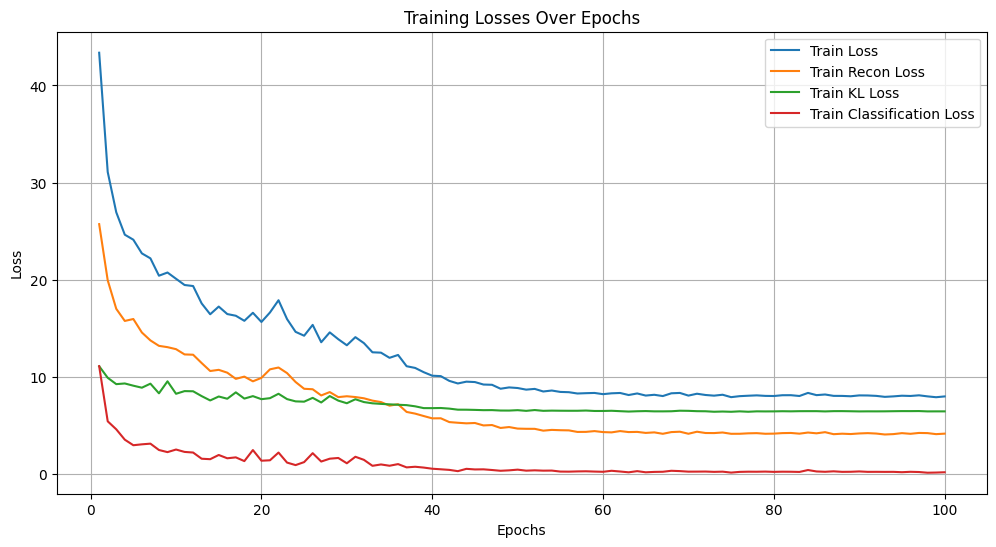

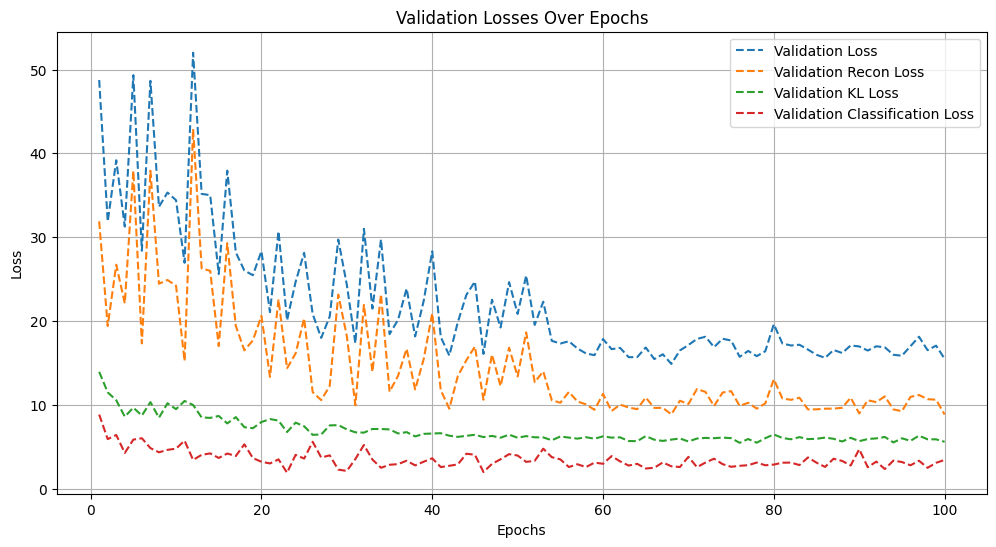

In [32]:
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)


# # Train the model
# for epoch in range(1, num_epochs + 1):
#     # avg_loss, avg_recon, avg_kl, avg_class, accuracy
#     train_loss, train_recon_loss, train_kl_loss, train_class_loss, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"])
    
#     val_loss, val_recon_loss, val_kl_loss, val_class_loss, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"])
#     scheduler.step(val_loss)
    
#     # Early stopping
#     if early_stopping([val_loss], stop_patience):
#         print(f"Early stopping triggered at epoch {epoch}")
#         break

import matplotlib.pyplot as plt

# Initialize lists to store loss values
epochs_list = []
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []
train_class_losses, val_class_losses = [], []

# Train the model
for epoch in range(1, num_epochs + 1):
    # avg_loss, avg_recon, avg_kl, avg_class, accuracy
    train_loss, train_recon_loss, train_kl_loss, train_class_loss, train_accuracy = train_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, val_recon_loss, val_kl_loss, val_class_loss, val_accuracy = validate_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    # Store values for visualization
    epochs_list.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon_loss)
    val_recon_losses.append(val_recon_loss)
    train_kl_losses.append(train_kl_loss)
    val_kl_losses.append(val_kl_loss)
    train_class_losses.append(train_class_loss)
    val_class_losses.append(val_class_loss)
    
    # Early stopping
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Train Loss', linestyle='-')
plt.plot(epochs_list, train_recon_losses, label='Train Recon Loss', linestyle='-')
plt.plot(epochs_list, train_kl_losses, label='Train KL Loss', linestyle='-')
plt.plot(epochs_list, train_class_losses, label='Train Classification Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, val_losses, label='Validation Loss', linestyle='--')
plt.plot(epochs_list, val_recon_losses, label='Validation Recon Loss', linestyle='--')
plt.plot(epochs_list, val_kl_losses, label='Validation KL Loss', linestyle='--')
plt.plot(epochs_list, val_class_losses, label='Validation Classification Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



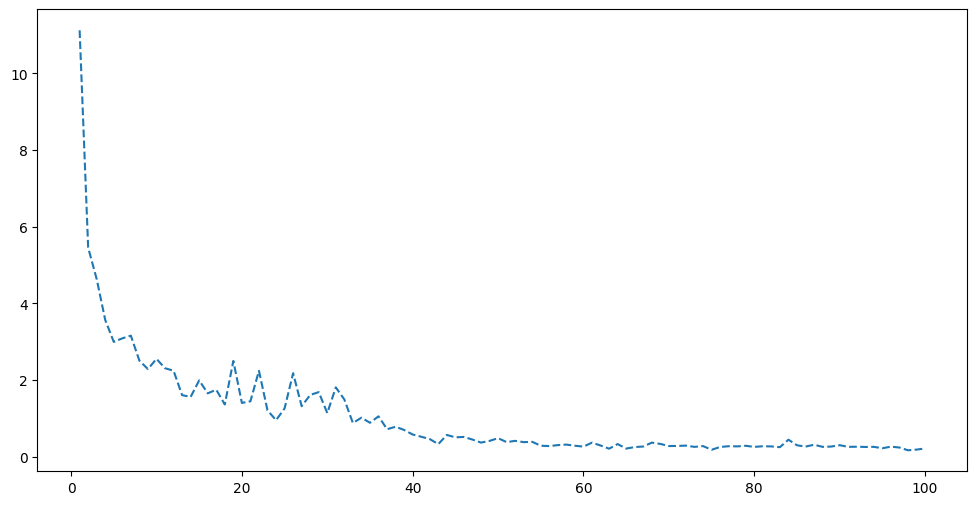

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_class_losses, label='Validation Loss', linestyle='--')

In [34]:
best_params['gamma']

1.028589573645326

In [44]:
result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 145,    5],
       [   4, 1579]])

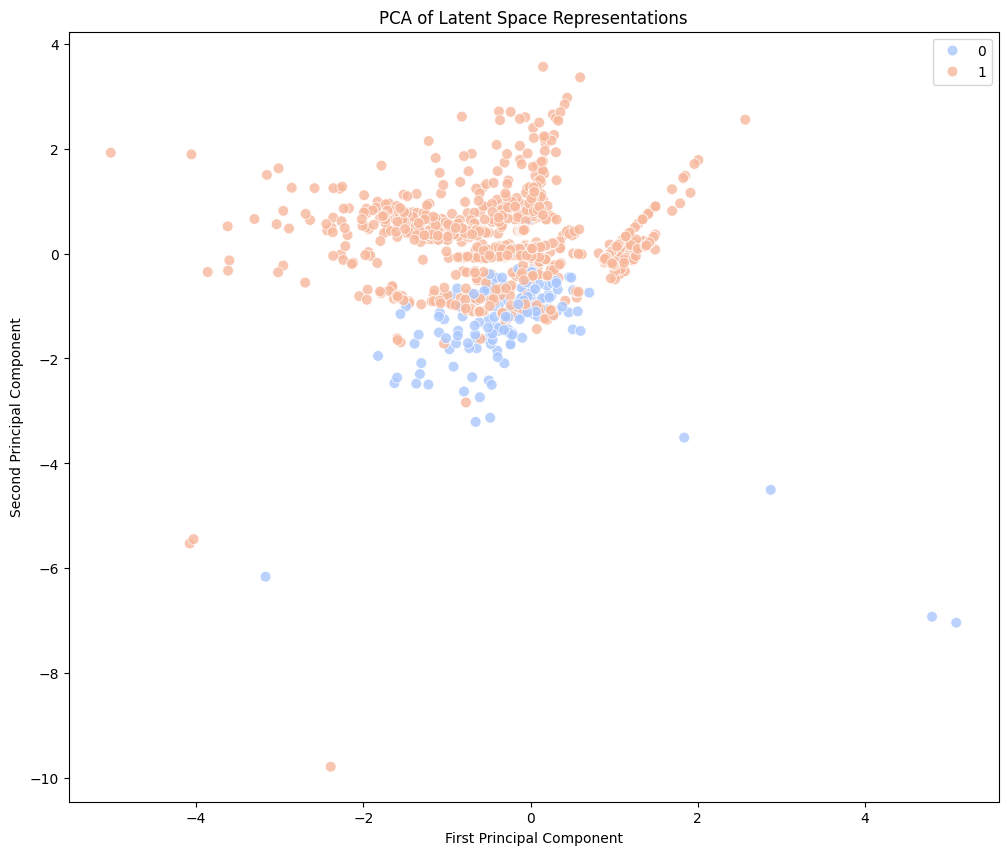

(150,)


In [43]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader, device)
visualize_latent_space_pca(val_latent, val_labels_np, best_model, device)

print(val_labels_np[val_labels_np == 0].shape)

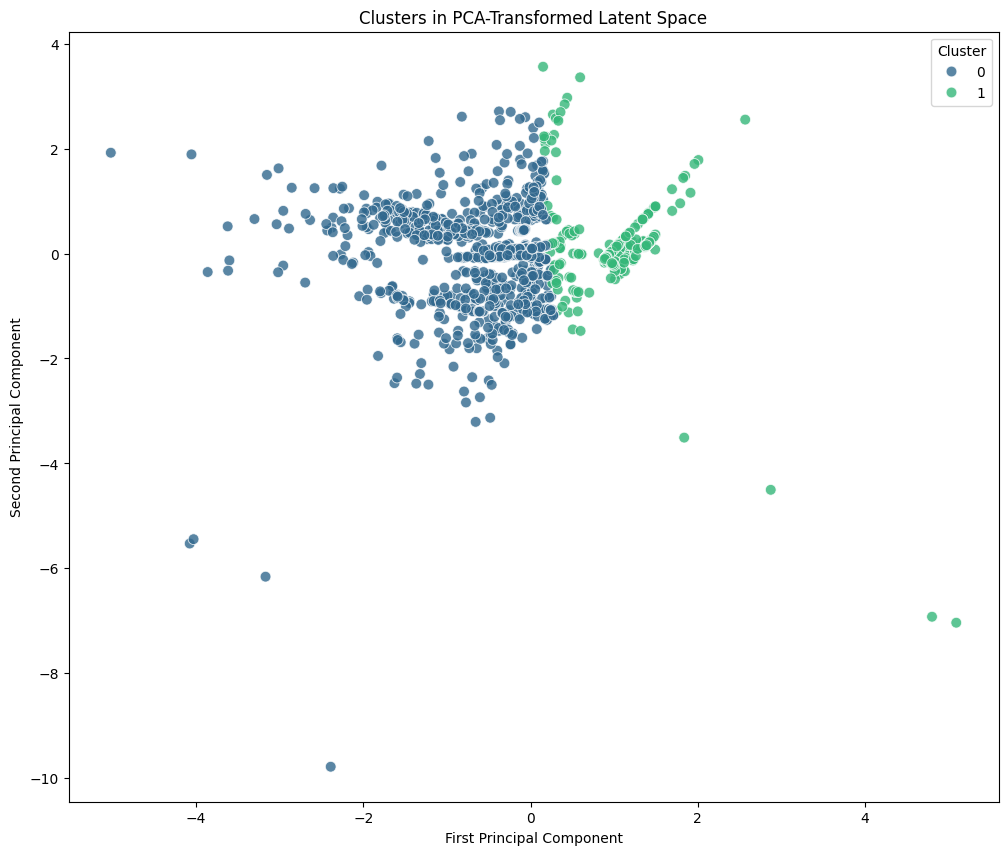

Silhouette Score: 0.3745388686656952
Adjusted Rand Index (ARI): -0.03474618280744274


In [45]:
def cluster_and_visualize(latent_representations, labels):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_2d)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=cluster_labels, palette='viridis', s=60, alpha=0.8)
    plt.title('Clusters in PCA-Transformed Latent Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(title="Cluster")
    plt.show()

    silhouette = silhouette_score(latent_2d, cluster_labels)
    print(f"Silhouette Score: {silhouette}")

    ari = adjusted_rand_score(labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

cluster_and_visualize(val_latent, val_labels_np)

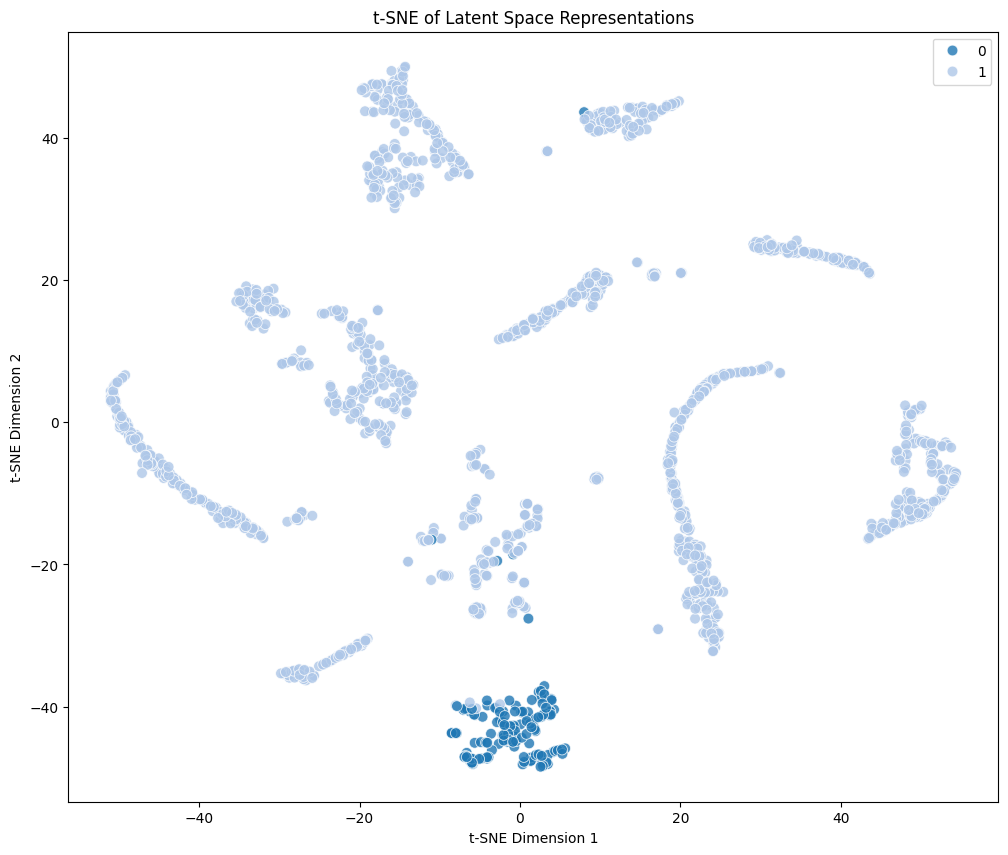

In [47]:
def visualize_latent_space_tsne(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)
    
    palette = sns.color_palette('Spectral', n_colors=len(set(labels)))
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='tab20', s=60, alpha=0.8)
    plt.title('t-SNE of Latent Space Representations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

visualize_latent_space_tsne(val_latent, val_labels_np)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


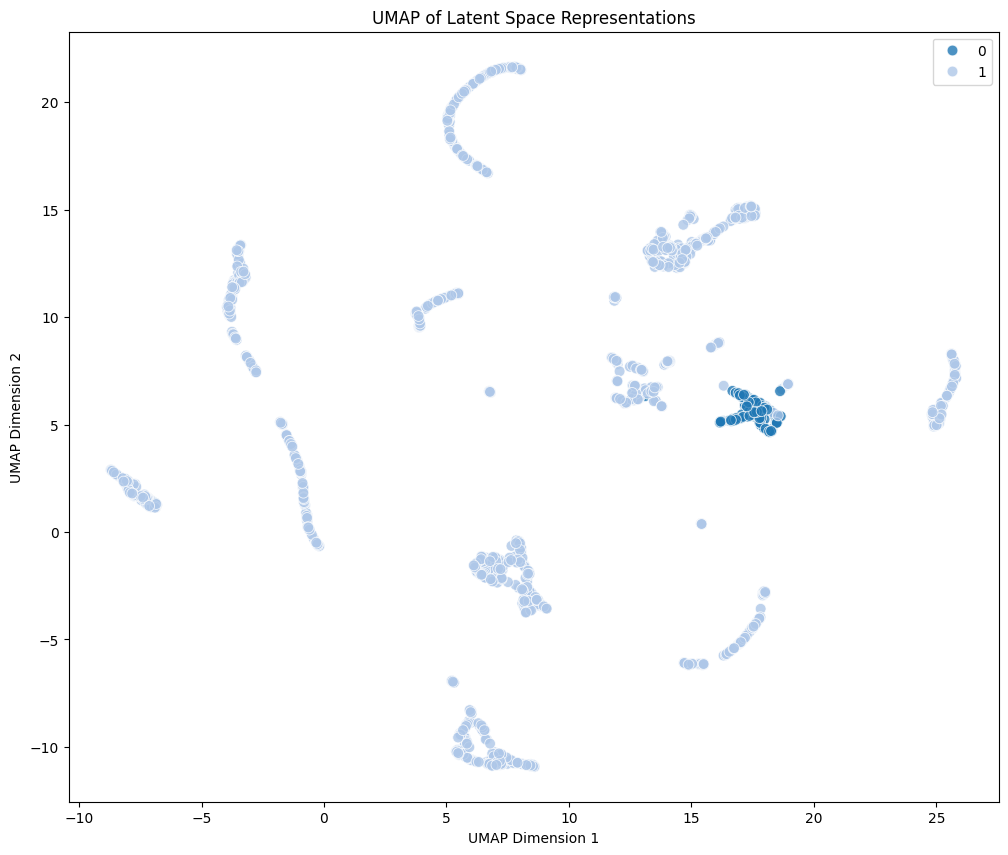

In [48]:
import umap

def visualize_latent_space_umap(latent_representations, labels):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)
    
    palette = sns.color_palette('tab20', n_colors=len(set(labels)))
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette=palette, s=60, alpha=0.8)
    plt.title('UMAP of Latent Space Representations')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

visualize_latent_space_umap(val_latent, val_labels_np)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr

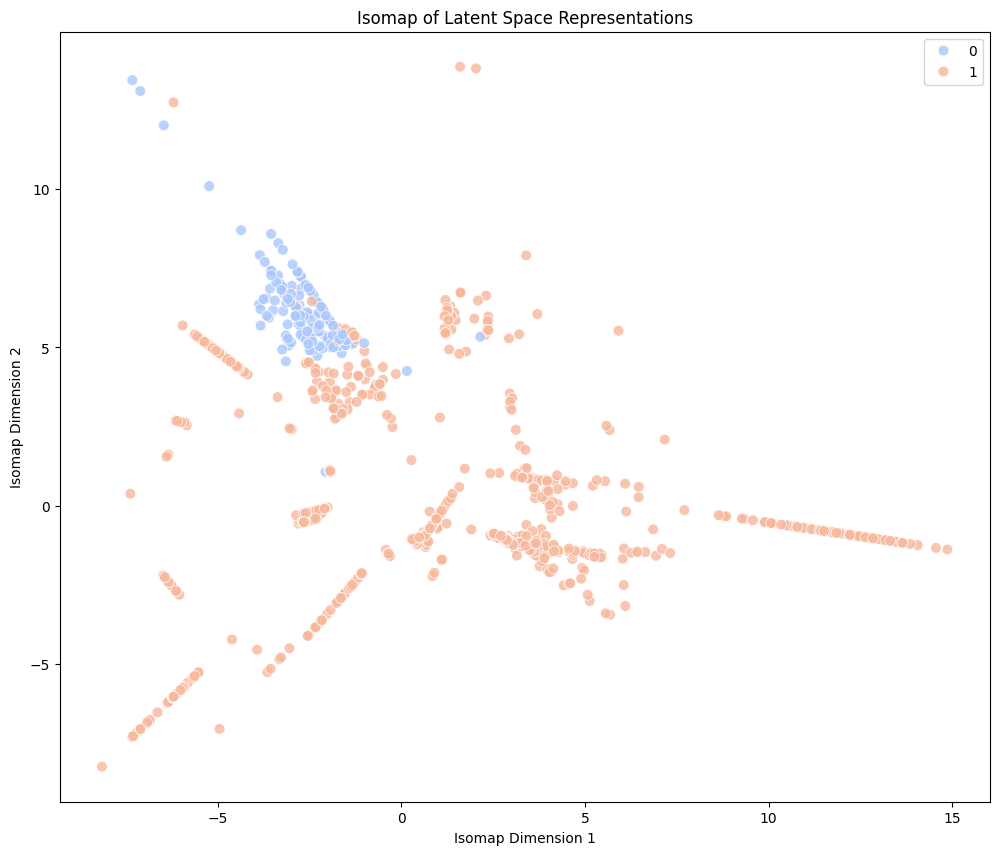

In [49]:
from sklearn.manifold import Isomap

def visualize_latent_space_isomap(latent_representations, labels):
    isomap = Isomap(n_components=2)
    latent_2d = isomap.fit_transform(latent_representations)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('Isomap of Latent Space Representations')
    plt.xlabel('Isomap Dimension 1')
    plt.ylabel('Isomap Dimension 2')
    plt.show()

visualize_latent_space_isomap(val_latent, val_labels_np)

In [52]:
from sklearn.metrics import mutual_info_score

def mutual_information(latent_representations, labels):
    mi = mutual_info_score(labels, np.argmax(latent_representations, axis=1))
    print(f"Mutual Information between Latent Variables and Labels: {mi}")

mutual_information(val_latent, val_labels_np)

Mutual Information between Latent Variables and Labels: 0.06281950407548911


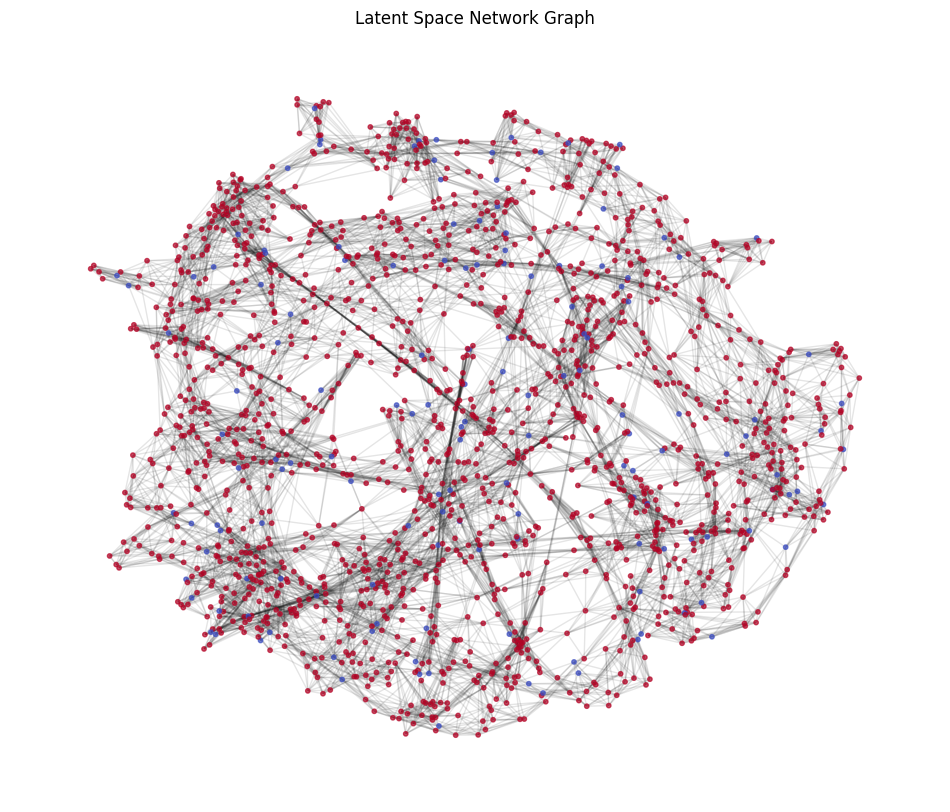

In [53]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def network_analysis(latent_representations, labels, n_neighbors=10):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(latent_representations)
    distances, indices = nbrs.kneighbors(latent_representations)
    
    G = nx.Graph()
    for i in range(len(latent_representations)):
        for j in indices[i]:
            if i != j:
                G.add_edge(i, j)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color=labels, cmap='coolwarm', alpha=0.7)
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.title('Latent Space Network Graph')
    plt.axis('off')
    plt.show()

network_analysis(val_latent, val_labels_np)

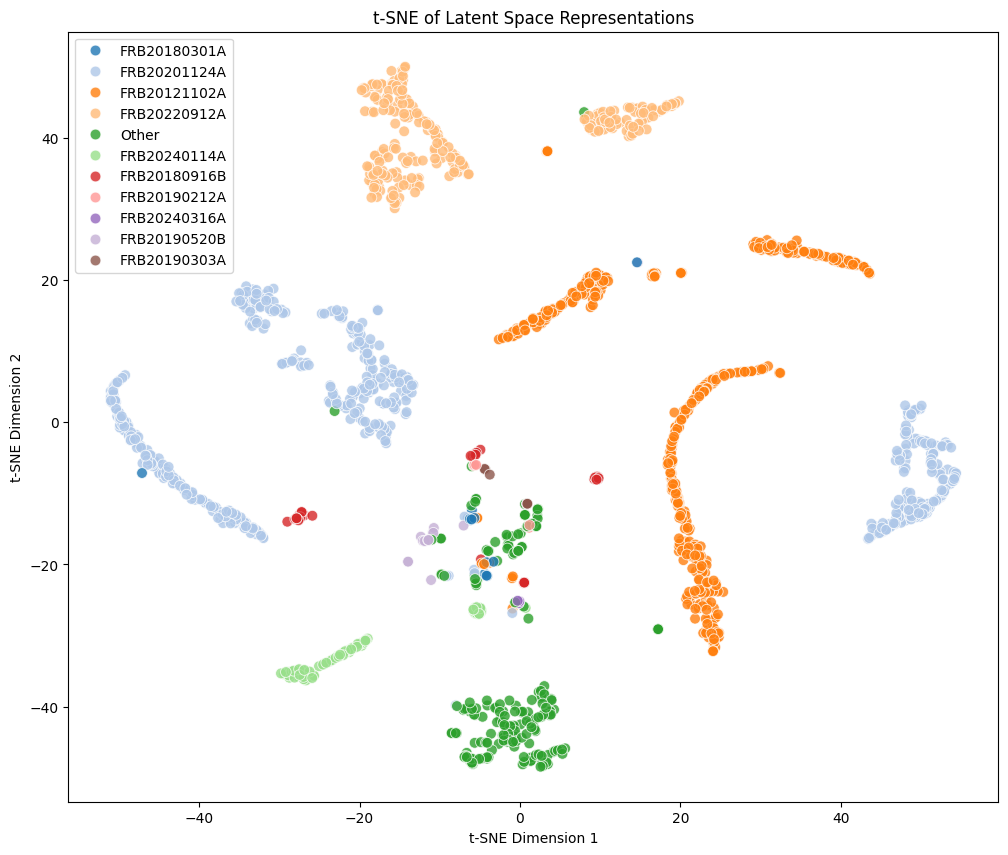

In [54]:
visualize_latent_space_tsne(val_latent, get_source_data_val_freq(10))

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


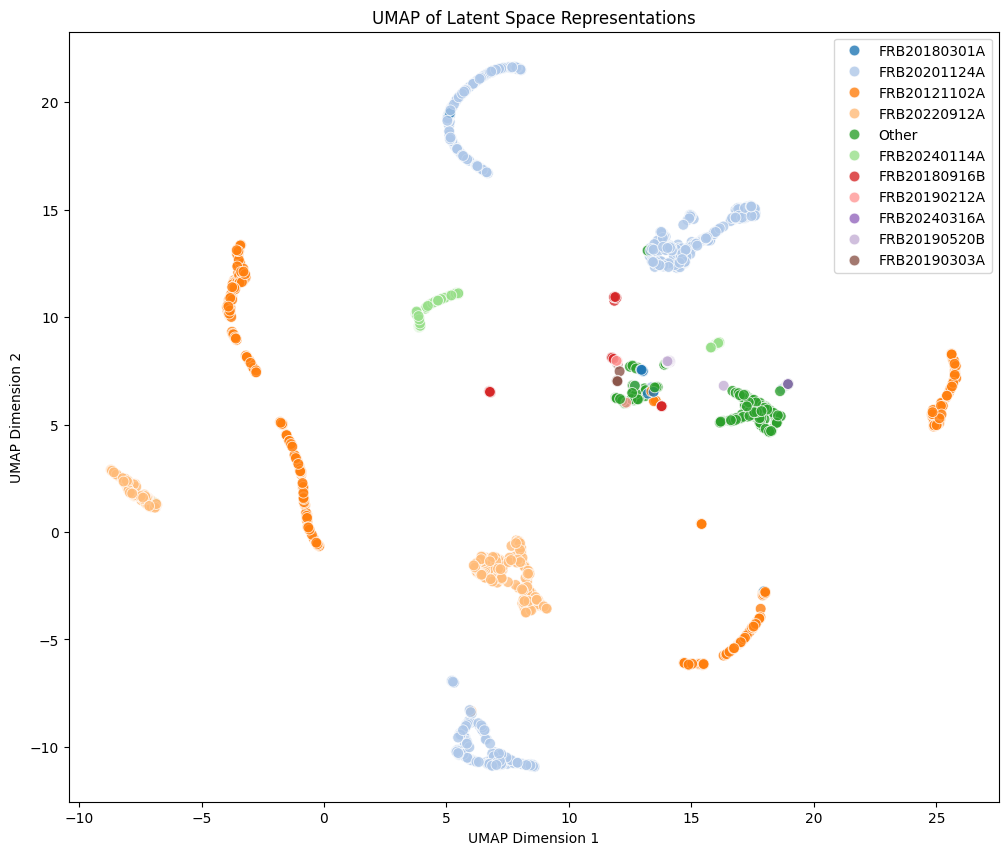

In [55]:
visualize_latent_space_umap(val_latent, get_source_data_val_freq(10))

In [56]:
def visualize_latent_space_tsne_interactive(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    tsne_df = pd.DataFrame({
        'TSNE-1': latent_2d[:, 0],
        'TSNE-2': latent_2d[:, 1],
        'Label': labels
    })

    fig = px.scatter(
        tsne_df, 
        x='TSNE-1', 
        y='TSNE-2', 
        color='Label', 
        hover_data=['Label'], 
        title='Interactive t-SNE of Latent Space Representations',
        width=800,
        height=800
    )

    fig.show()

visualize_latent_space_tsne_interactive(val_latent, get_source_data_val_freq(10))

In [64]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# Step 2: Filter the dataset to exclude these repeaters
filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
filtered_data_clean = frb_data_clean.loc[filtered_indices]
filtered_labels = labels.loc[filtered_indices]

# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)

def train_supervised_filtered(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_filtered):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_filtered(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_filtered:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False


In [77]:


# Step 7: Train the model with the filtered dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)


=== Final Evaluation ===
Validation Accuracy: 0.9672
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.96      0.99      0.97       150
    Repeater       0.98      0.95      0.97       124

    accuracy                           0.97       274
   macro avg       0.97      0.97      0.97       274
weighted avg       0.97      0.97      0.97       274

Confusion Matrix:
 [[148   2]
 [  6 118]]



=== PCA Visualization ===


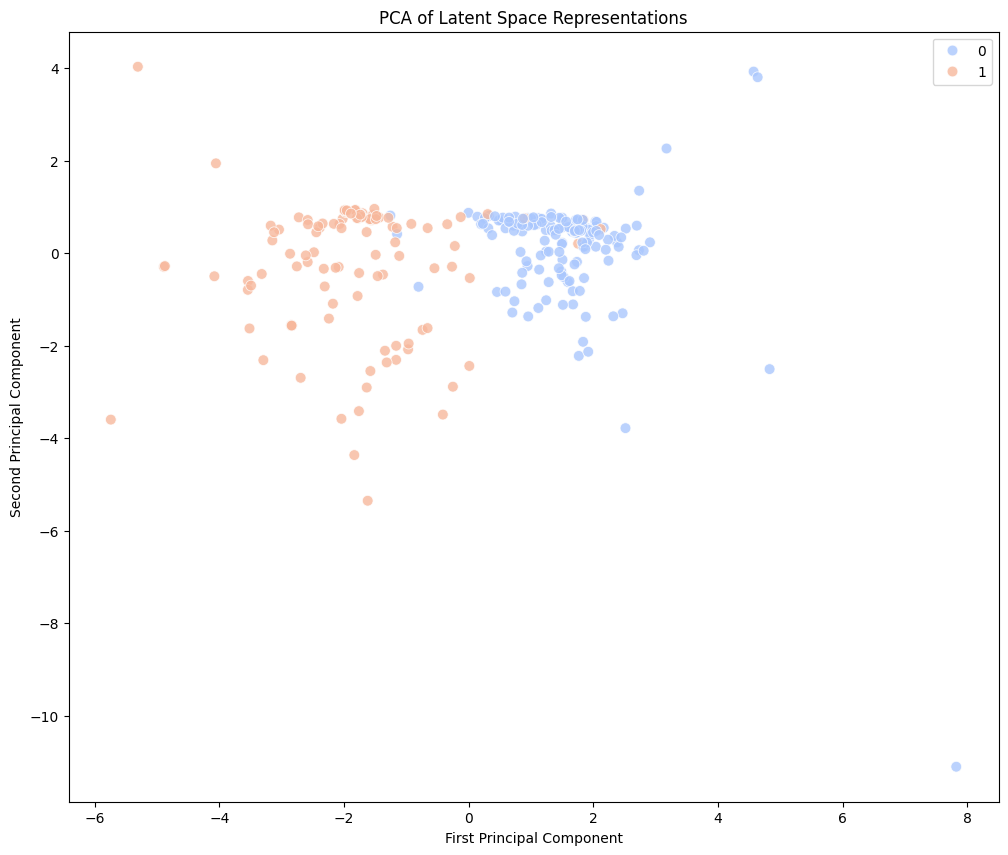


=== Clustering Analysis in Latent Space ===


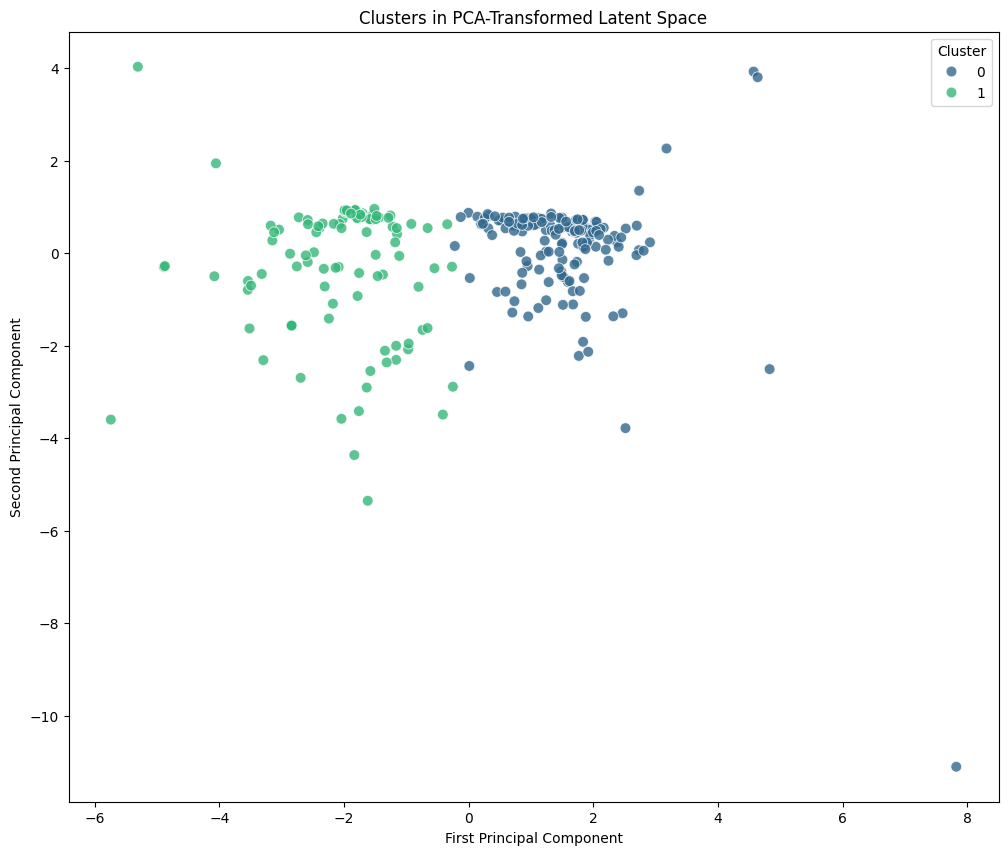

Silhouette Score: 0.5668269395828247
Adjusted Rand Index (ARI): 0.8318620194920086

=== t-SNE Visualization ===


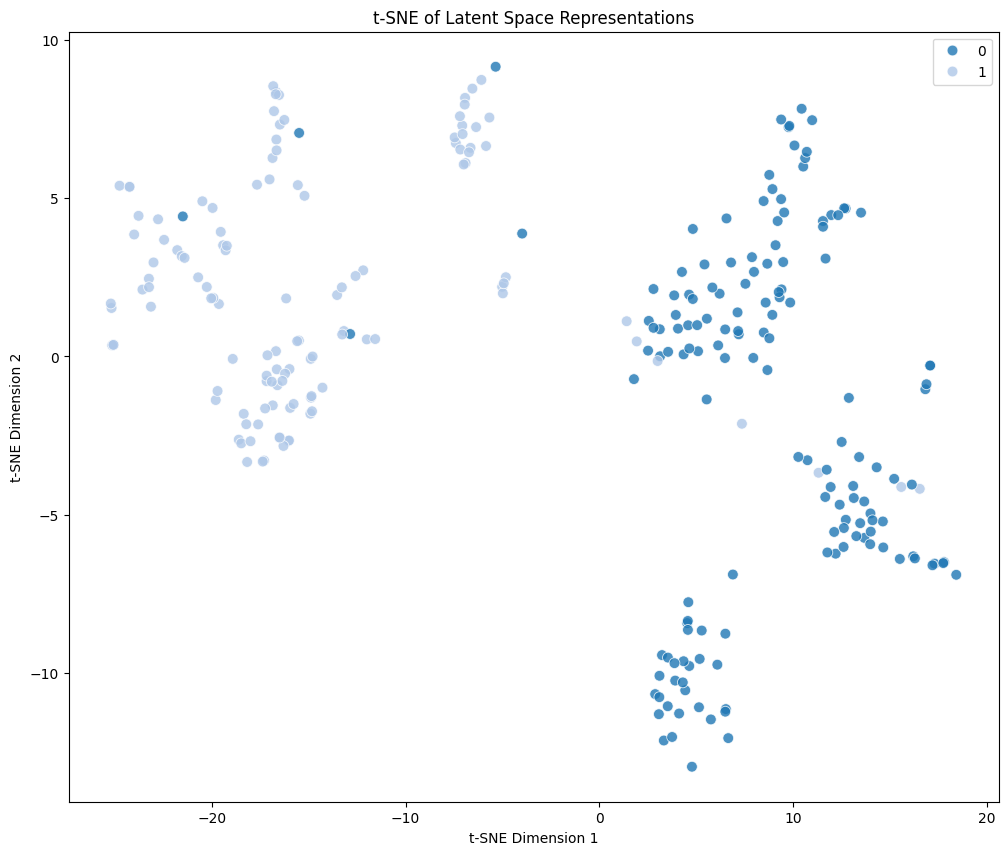


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



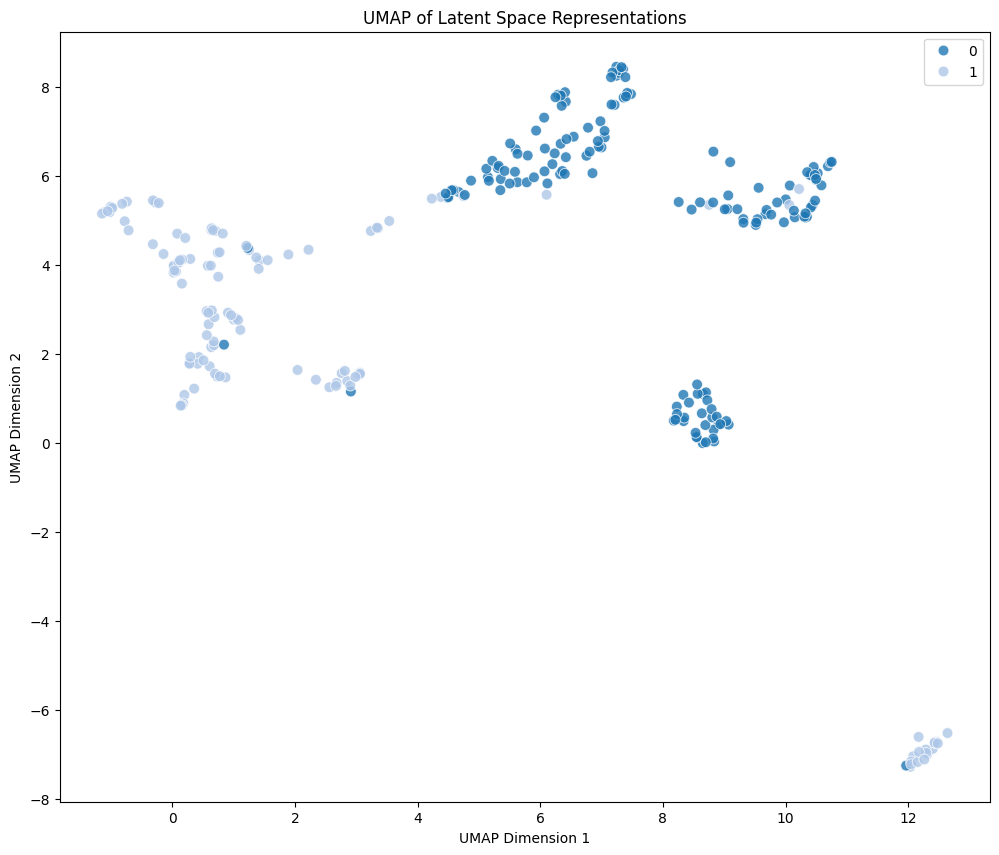


=== Isomap Visualization ===


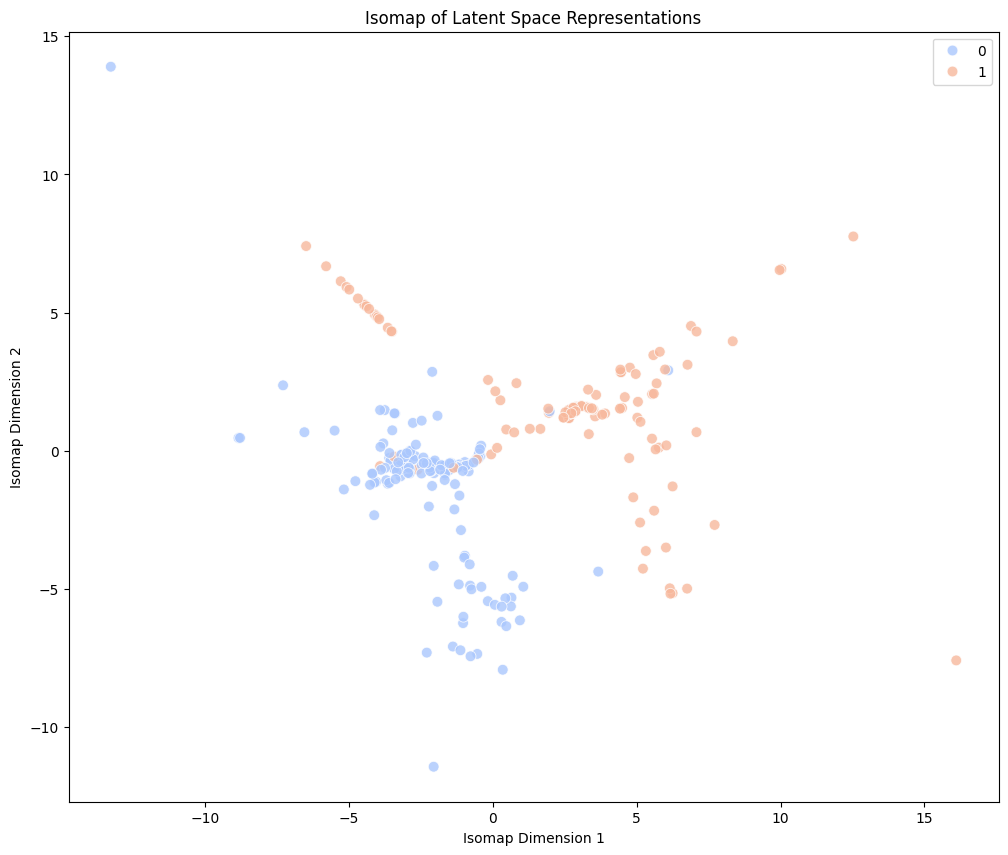

In [78]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(best_model, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, best_model, device)

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np)

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np)

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np)

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np)


In [73]:
# Step 1: Remove all repeaters from the dataset
non_repeater_indices = frb_data[frb_data['Repeater'] == 0].index
no_repeater_data_clean = frb_data_clean.loc[non_repeater_indices]
no_repeater_labels = labels.loc[non_repeater_indices]

# Step 2: Standardize the no_repeater dataset
scaler = StandardScaler()
no_repeater_data_scaled = scaler.fit_transform(no_repeater_data_clean)

# Step 3: Split the no_repeater dataset into train and validation sets
train_data_no_repeater, val_data_no_repeater, train_labels_no_repeater, val_labels_no_repeater = train_test_split(
    no_repeater_data_scaled, no_repeater_labels, test_size=0.2, random_state=42, stratify=no_repeater_labels
)

# Step 4: Convert to PyTorch tensors
train_tensor_no_repeater = torch.tensor(train_data_no_repeater, dtype=torch.float32)
val_tensor_no_repeater = torch.tensor(val_data_no_repeater, dtype=torch.float32)
train_labels_tensor_no_repeater = torch.tensor(train_labels_no_repeater.values, dtype=torch.long)
val_labels_tensor_no_repeater = torch.tensor(val_labels_no_repeater.values, dtype=torch.long)

# Step 5: Create datasets and dataloaders
batch_size = 64
train_dataset_no_repeater = TensorDataset(train_tensor_no_repeater, train_labels_tensor_no_repeater)
val_dataset_no_repeater = TensorDataset(val_tensor_no_repeater, val_labels_tensor_no_repeater)

train_loader_no_repeater = DataLoader(train_dataset_no_repeater, batch_size=batch_size, shuffle=True)
val_loader_no_repeater = DataLoader(val_dataset_no_repeater, batch_size=batch_size, shuffle=False)

def train_supervised_no_repeater(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_no_repeater):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = train_loss / len(train_loader_no_repeater.dataset)
    avg_recon = recon_loss_total / len(train_loader_no_repeater.dataset)
    avg_kl = kl_loss_total / len(train_loader_no_repeater.dataset)
    avg_class = classification_loss_total / len(train_loader_no_repeater.dataset)
    accuracy = correct / total
    
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_no_repeater(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_no_repeater:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader_no_repeater.dataset)
    avg_recon = recon_loss_total / len(val_loader_no_repeater.dataset)
    avg_kl = kl_loss_total / len(val_loader_no_repeater.dataset)
    avg_class = classification_loss_total / len(val_loader_no_repeater.dataset)
    accuracy = correct / total
    
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

# Step 7: Train the model with the no_repeater dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_no_repeater(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_no_repeater(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    
def evaluate_classifier_full_oneclass(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    # f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    # class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return conf_matrix, all_preds, all_labels

# Evaluate the model after training

conf_mat_no_repeaters, _, _ = evaluate_classifier_full_oneclass(best_model, val_loader_no_repeater, device)

conf_mat_no_repeaters

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



array([[150]])


=== PCA Visualization ===


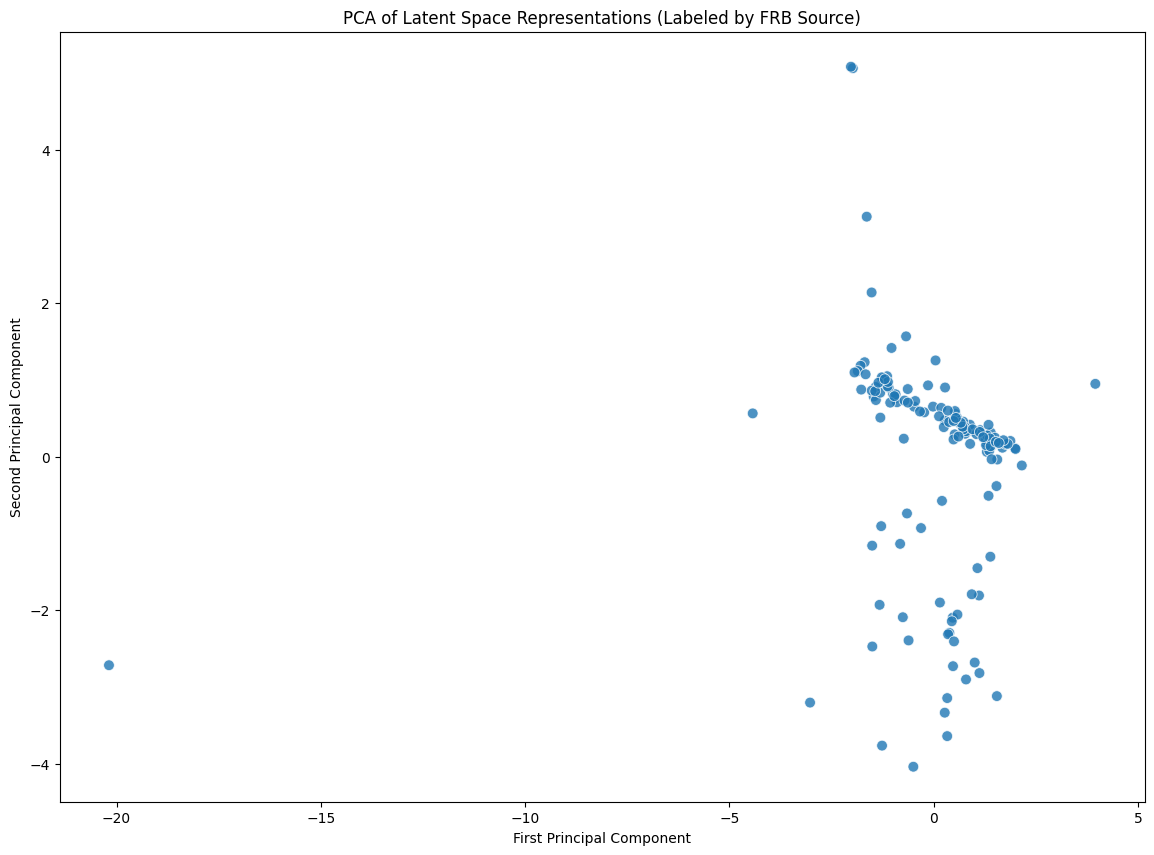


=== t-SNE Visualization ===


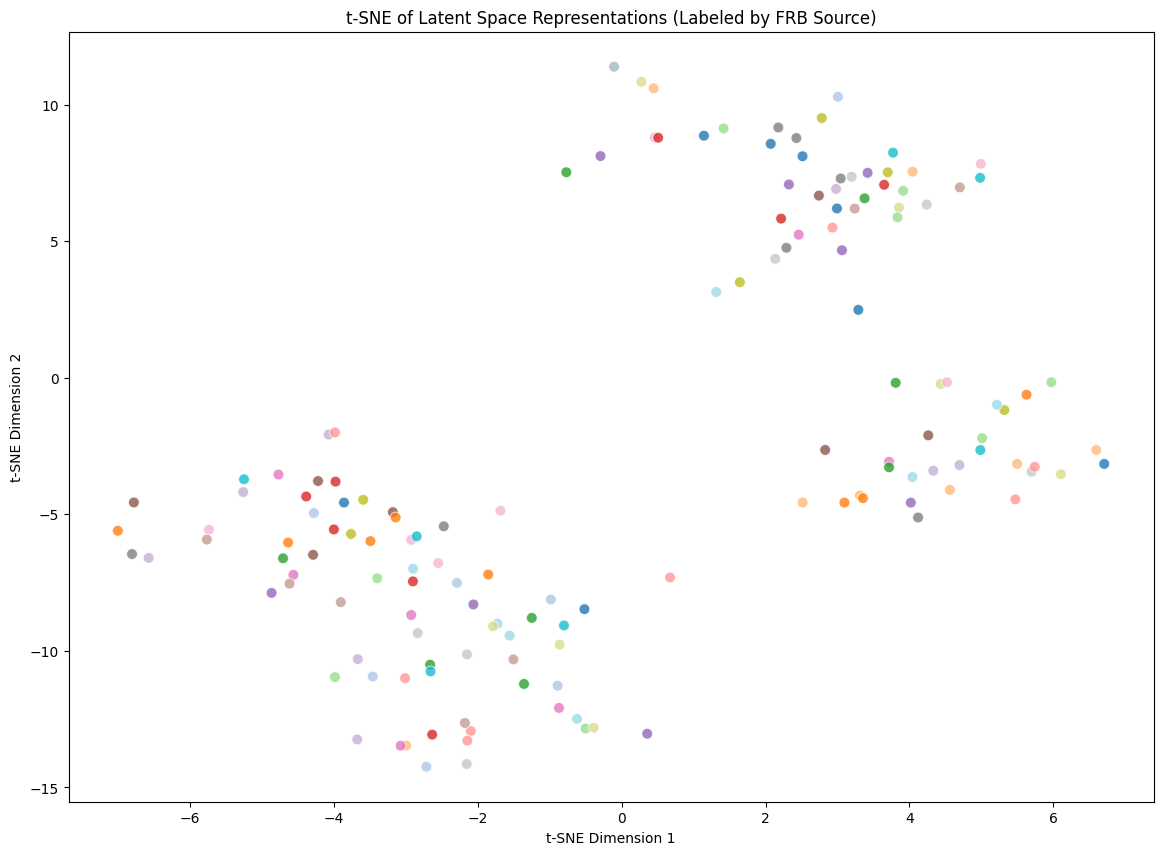


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



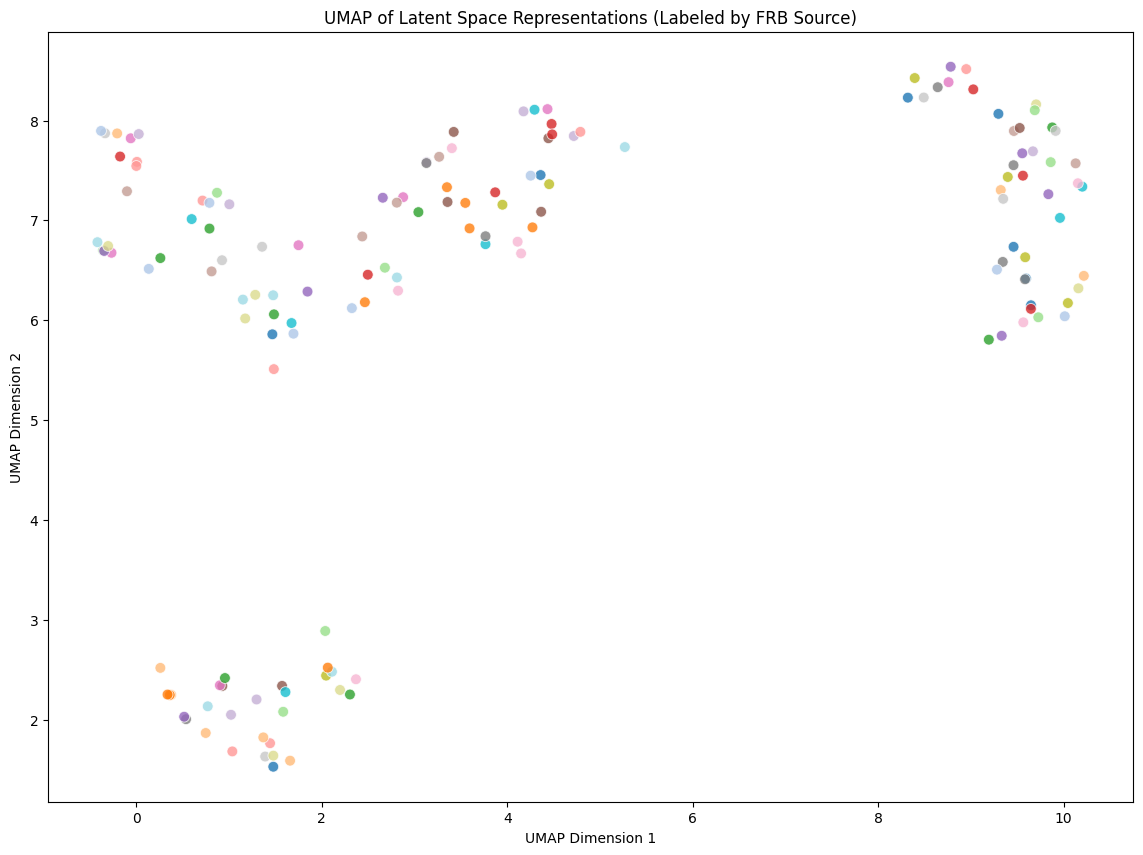

In [85]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(best_model, train_loader_no_repeater, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader_no_repeater, device)


def visualize_latent_space_pca_source_nolegend(latent_representations, sources):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('PCA of Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
def visualize_latent_space_tsne_nolegend(latent_representations, sources):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('t-SNE of Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
    
def visualize_latent_space_umap_source_nolegend(latent_representations, sources):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=sources, palette="tab20", s=60, alpha=0.8, legend=False)
    plt.title('UMAP of Latent Space Representations (Labeled by FRB Source)')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()




# Extract the source names for the validation set
val_sources_no_repeater = original_data.loc[val_labels_no_repeater.index, "Source"].values


# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca_source_nolegend(val_latent, val_labels_np)

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne_nolegend(val_latent, val_sources_no_repeater)

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap_source_nolegend(val_latent, val_sources_no_repeater)
